In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.auto import tqdm
from toolz import pluck, keyfilter
from sklearn.decomposition import PCA, NMF
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut, ShuffleSplit, KFold
from sklearn.metrics import r2_score
from aging.plotting import figure, legend, format_plots
import joblib

In [2]:
format_plots()

In [3]:
# beh_df = pd.read_parquet('/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet')
# beh_df = pd.read_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model.parquet")
# beh_df = pd.read_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v2.parquet")
# beh_df = pd.read_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v3.parquet")
# beh_df = pd.read_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v4.parquet")
beh_df = pd.read_parquet("/n/scratch/users/w/wg41/bio-age-model/2024-04-11/ontogeny-bio-age-model-v5.parquet")
meth_df = pd.read_parquet('/n/groups/datta/win/longtogeny/data/epigenetics/analysis/epi_df.parquet')

In [4]:
beh_df.head()

bio_age_00  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    7.540541   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22    5.657658   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03    4.468468   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47    4.270270   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09    5.063063   

                                                                                                 bio_age_01  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22    5.063063   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03    3.378378   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47    4.171171   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09    4.468468   

                                                                                                 bio_age_02  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22    4.765766   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03    3.477477   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47    3.675676   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09    4.567568   

                                                                                                 bio_age_03  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    7.045045   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22    5.459459   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03    3.972973   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47    4.171171   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09    4.765766   

                                                                                                 bio_age_04  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_01_02 4M_01_02     otgy_4M_01   2bb5e7fa-02cd-4694-accf-fed9651b1beb 2023-12-01 08:00:22    4.765766   
    4M_01_03 4M_01_03     otgy_4M_01   7daed982-62e5-4695-971f-c229381d7521 2023-12-01 11:04:03    3.477477   
    4M_01_04 4M_01_04     otgy_4M_01   43e12fcc-2119-4e15-b11c-add440ca5f74 2023-12-01 07:51:47    3.378378   
    4M_02_01 4M_02_01     otgy_4M_02   6568fdb5-82b5-4241-8ccb-572ae49bd87a 2023-12-01 12:53:09    4.369369   

                                                                                                 bio_age_05  \
age mouse    subject_name session_name uuid                                 date                

In [5]:
meth_df = meth_df.astype(float).sort_index(level='age')

In [6]:
beh_reindexed = beh_df.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')], :].copy()
beh_reindexed.head()

bio_age_00  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    7.540541   
    4M_02_03 4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38    6.054054   
    4M_03_01 4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51    5.063063   
    4M_04_03 4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40    3.279279   
8   8M_01_01 8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04   11.405405   

                                                                                                 bio_age_01  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_02_03 4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38    5.162162   
    4M_03_01 4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51    4.468468   
    4M_04_03 4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40    2.387387   
8   8M_01_01 8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04   10.612613   

                                                                                                 bio_age_02  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_02_03 4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38    5.162162   
    4M_03_01 4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51    4.369369   
    4M_04_03 4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40    2.288288   
8   8M_01_01 8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04   10.414414   

                                                                                                 bio_age_03  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    7.045045   
    4M_02_03 4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38    5.756757   
    4M_03_01 4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51    4.963964   
    4M_04_03 4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40    2.684685   
8   8M_01_01 8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04   11.108108   

                                                                                                 bio_age_04  \
age mouse    subject_name session_name uuid                                 date                              
4   4M_01_01 4M_01_01     otgy_4M_01   e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 2023-12-01 10:54:30    6.648649   
    4M_02_03 4M_02_03     otgy_4M_02   32221902-9ee7-4d36-a7f4-e76375e3084e 2023-12-01 12:54:38    5.261261   
    4M_03_01 4M_03_01     otgy_4M_03   d217e548-3541-4f7a-8b3a-448f4544d543 2023-12-01 14:43:51    4.072072   
    4M_04_03 4M_04_03     otgy_4M_04   74731140-1b31-4027-9ebb-c1f21bb1cffa 2023-12-01 16:08:40    2.189189   
8   8M_01_01 8M_01_01     otgy_8M_01   f6753e99-2eb6-47d7-85d6-962aa1b9f945 2023-12-02 10:57:04   10.513514   

                                                                                                 bio_age_05  \
age mouse    subject_name session_name uuid                                 date                

In [7]:
beh_reindexed['bio_age'] = beh_reindexed[[f"bio_age_{i:02d}" for i in range(6)]].mean(1)

In [8]:
meth_df.head()

cg00101675_BC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.787497   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.796943   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.778463   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.759235   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.822929   

                                                           cg00116289_BC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.881712   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.866094   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.887471   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.910044   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.865924   

                                                           cg00211372_TC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.937067   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.913154   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.932768   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.936462   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.938248   

                                                           cg00531009_BC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.875649   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.846786   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.871338   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.871426   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.884436   

                                                           cg00747726_TC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.856235   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.856632   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.877107   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.835605   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.876528   

                                                           cg00896209_TC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.855913   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.860746   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.863451   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.859340   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.863671   

                                                           cg00910419_BC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.040740   
4_02_03  32221902-9ee7-4d36-a7f4-e76375e3084e 4   3               0.046025   
4_03_01  d217e548-3541-4f7a-8b3a-448f4544d543 4   2               0.043710   
4_04_03  74731140-1b31-4027-9ebb-c1f21bb1cffa 4   1               0.037378   
8_01_01  f6753e99-2eb6-47d7-85d6-962aa1b9f945 8   9               0.043320   

                                                           cg00920372_BC21  \
mouse_id uuid                                 age bio_age                    
4_01_01  e6ad4e15-0ce1-4833-a751-09aa15bfa2e5 4   4               0.581371

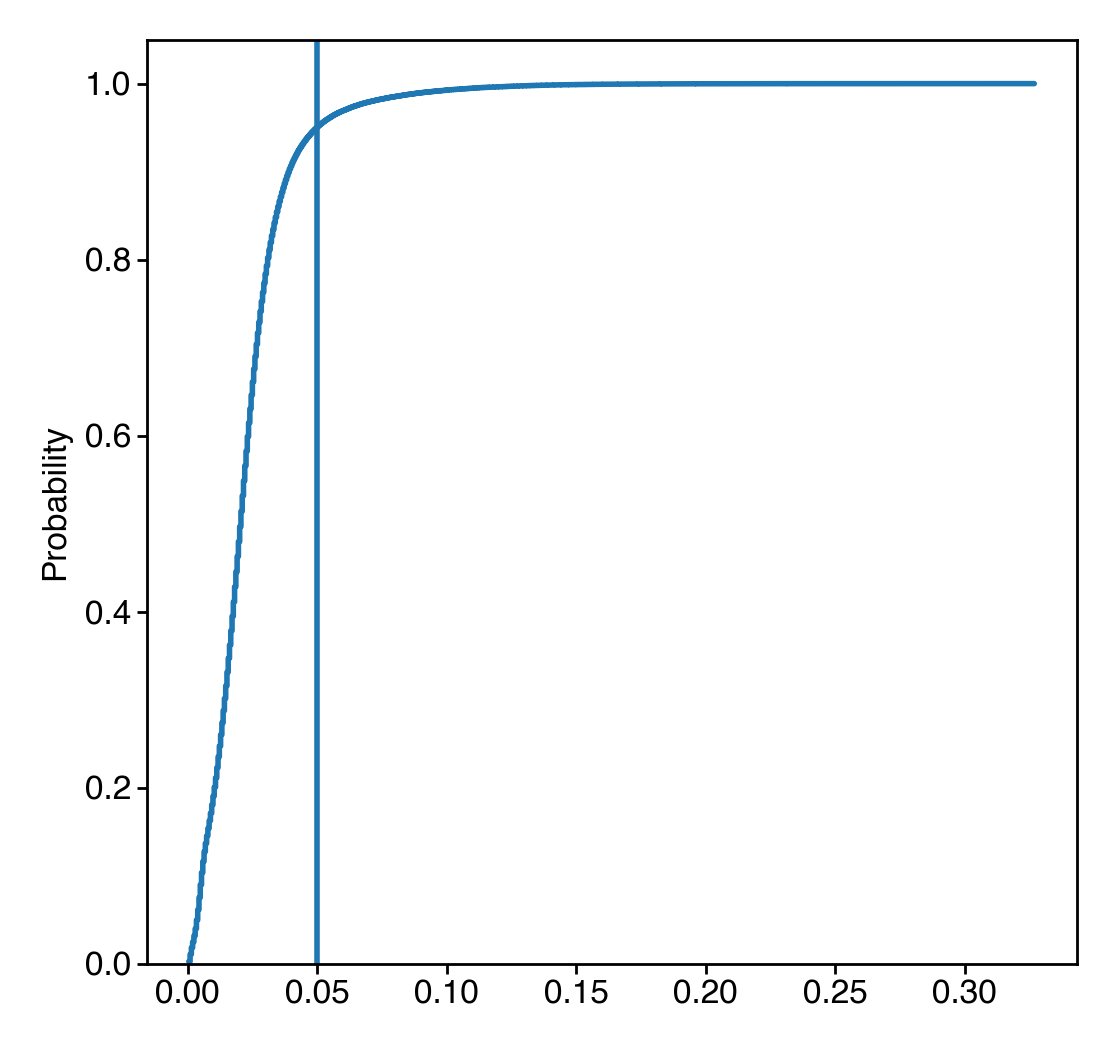

In [9]:
ax = sns.histplot(meth_df.std().sort_values(), cumulative=True, stat='probability', element='step', fill=False)
ax.axvline(0.05)

In [10]:
keep_genes = meth_df.std() > 0.03
keep_genes = keep_genes.index[keep_genes]

In [11]:
meth_df = meth_df[keep_genes]

In [12]:
pca = PCA(n_components=10)
pc_scores = pca.fit_transform(meth_df)

In [13]:
age = beh_reindexed.index.get_level_values('age')

In [14]:
pd.Series(pc_scores[:, 0]).corr(pd.Series(age.to_numpy()), method='spearman')

0.9269532005580674

In [15]:
pd.Series(pc_scores[:, 0]).corr(pd.Series(beh_reindexed['bio_age'].to_numpy()), method='spearman')

0.8104347826086956

In [16]:
r2_score(
    age.to_numpy(),
    cross_val_predict(
        PLSRegression(n_components=2),
        meth_df,
        age.to_numpy()[:, None],
        cv=KFold(n_splits=8, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)

0.948453615718496

In [17]:
r2_score(
    beh_reindexed['bio_age'].to_numpy(),
    cross_val_predict(
        PLSRegression(n_components=2),
        meth_df,
        beh_reindexed['bio_age'].to_numpy()[:, None],
        cv=KFold(n_splits=8, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)

0.8579214323945681

In [18]:
resid = beh_reindexed['bio_age'].to_numpy() - age.to_numpy()
r2_score(
    resid,
    cross_val_predict(
        PLSRegression(n_components=2),
        meth_df,
        resid[:, None],
        cv=KFold(n_splits=8, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)

0.002676443538875195

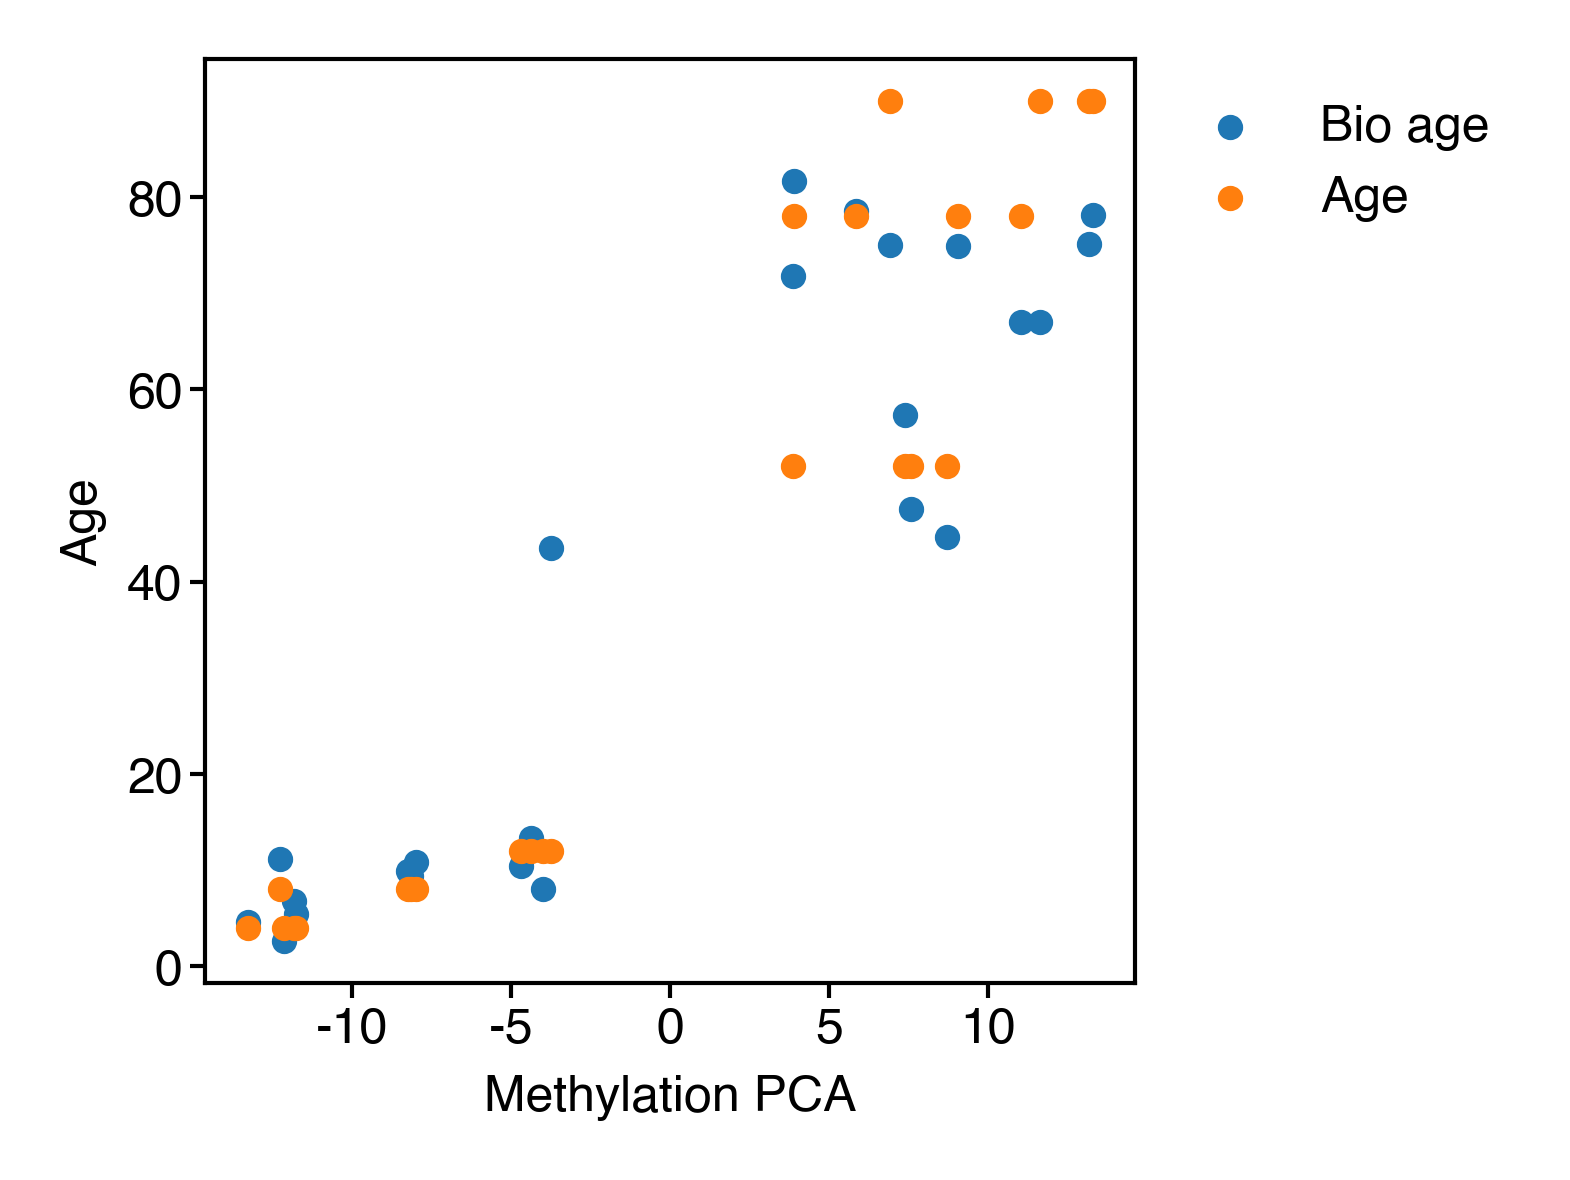

In [19]:
fig = figure(2, 2)
plt.scatter(pc_scores[:, 0], beh_reindexed['bio_age'], s=5, label="Bio age")
plt.scatter(pc_scores[:, 0], age, s=5, label="Age")
plt.ylabel("Age")
plt.xlabel("Methylation PCA")
legend()

In [63]:
pos_idx = np.where(pca.components_[0] > 0.01)[0]
neg_idx = np.where(pca.components_[0] < -0.004)[0]

In [64]:
len(pos_idx)

3002

In [65]:
len(neg_idx)

1310

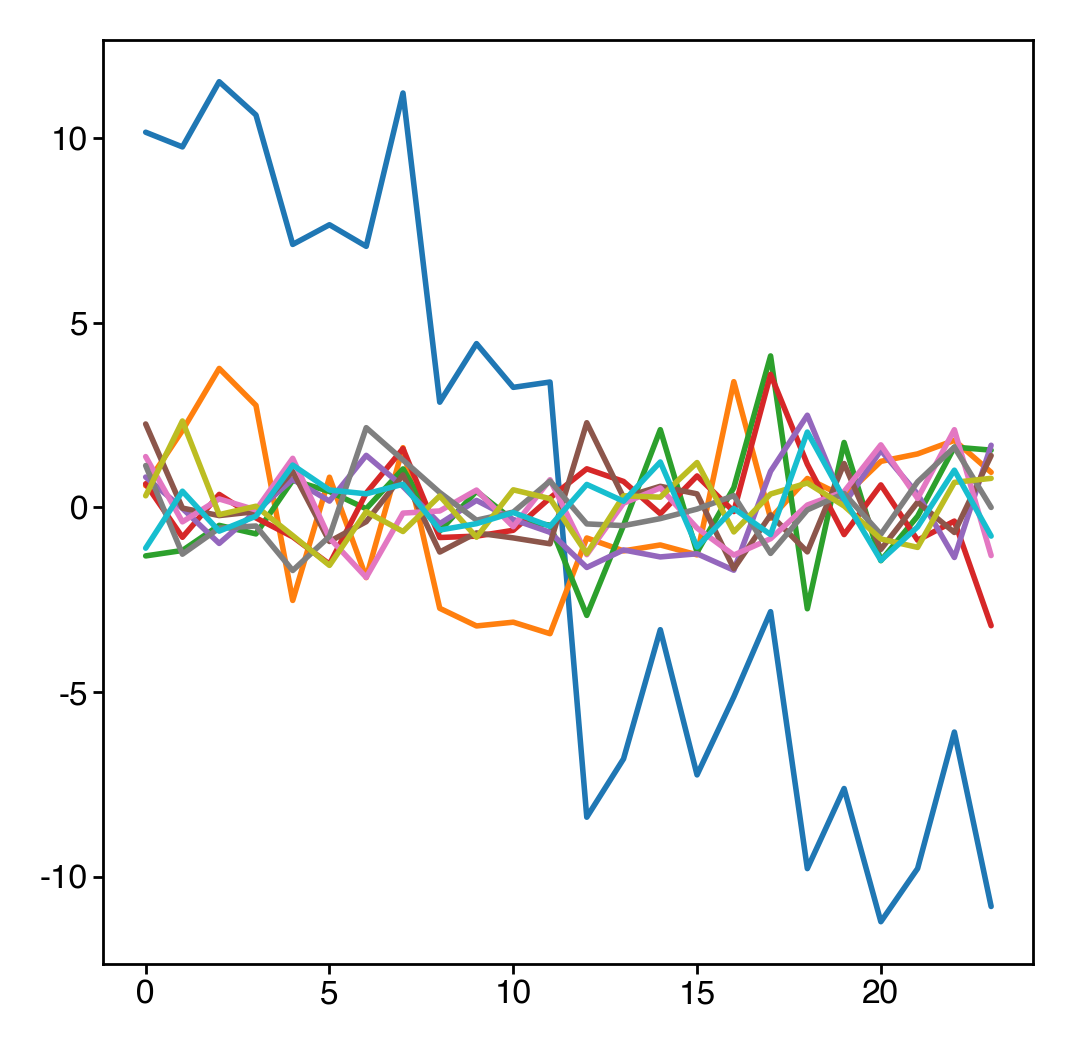

In [66]:
plt.plot(pc_scores)

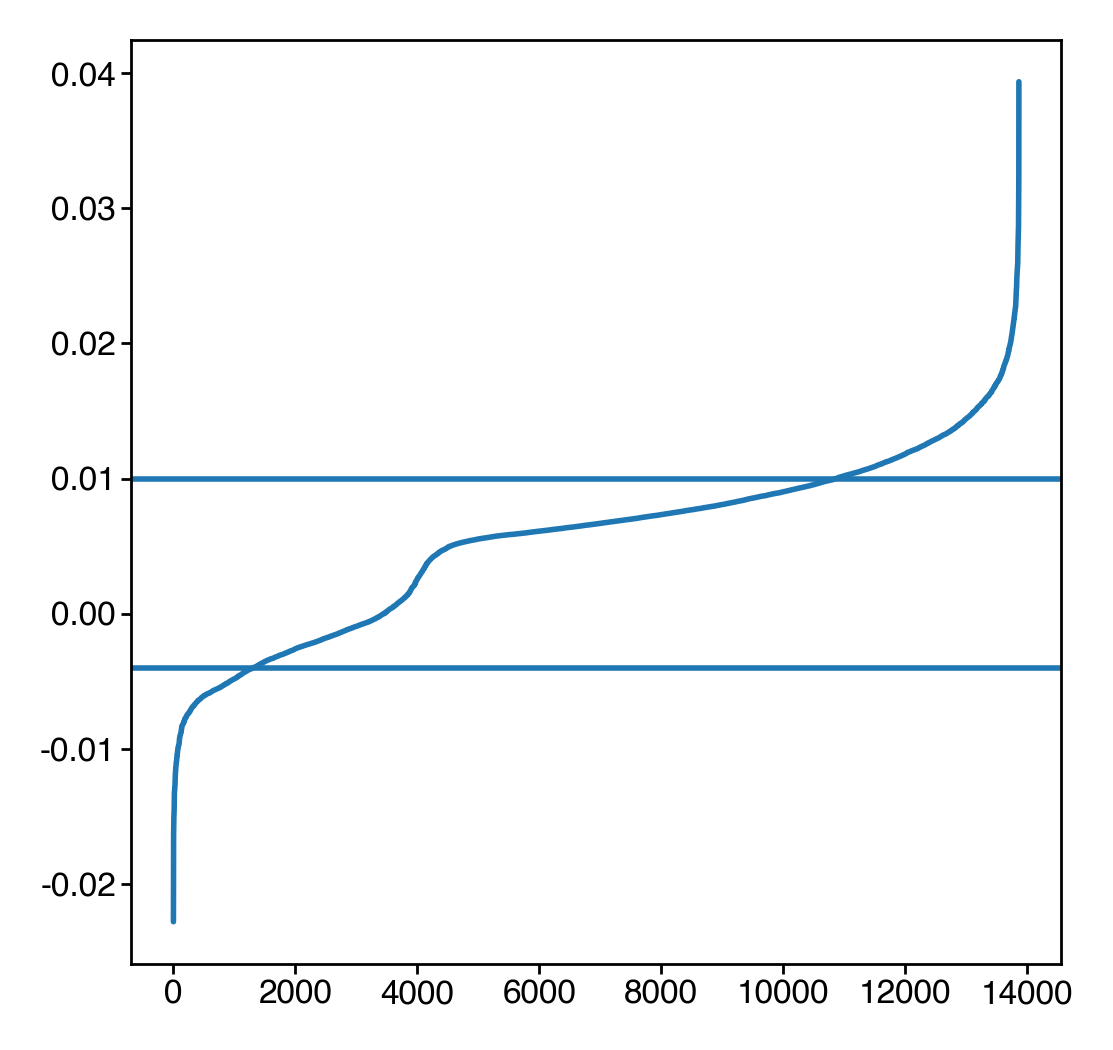

In [67]:
plt.plot(np.sort(pca.components_[0]))
plt.axhline(-0.004)
plt.axhline(0.01)

In [68]:
nmf = NMF(n_components=3)
scores = nmf.fit_transform(meth_df)

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


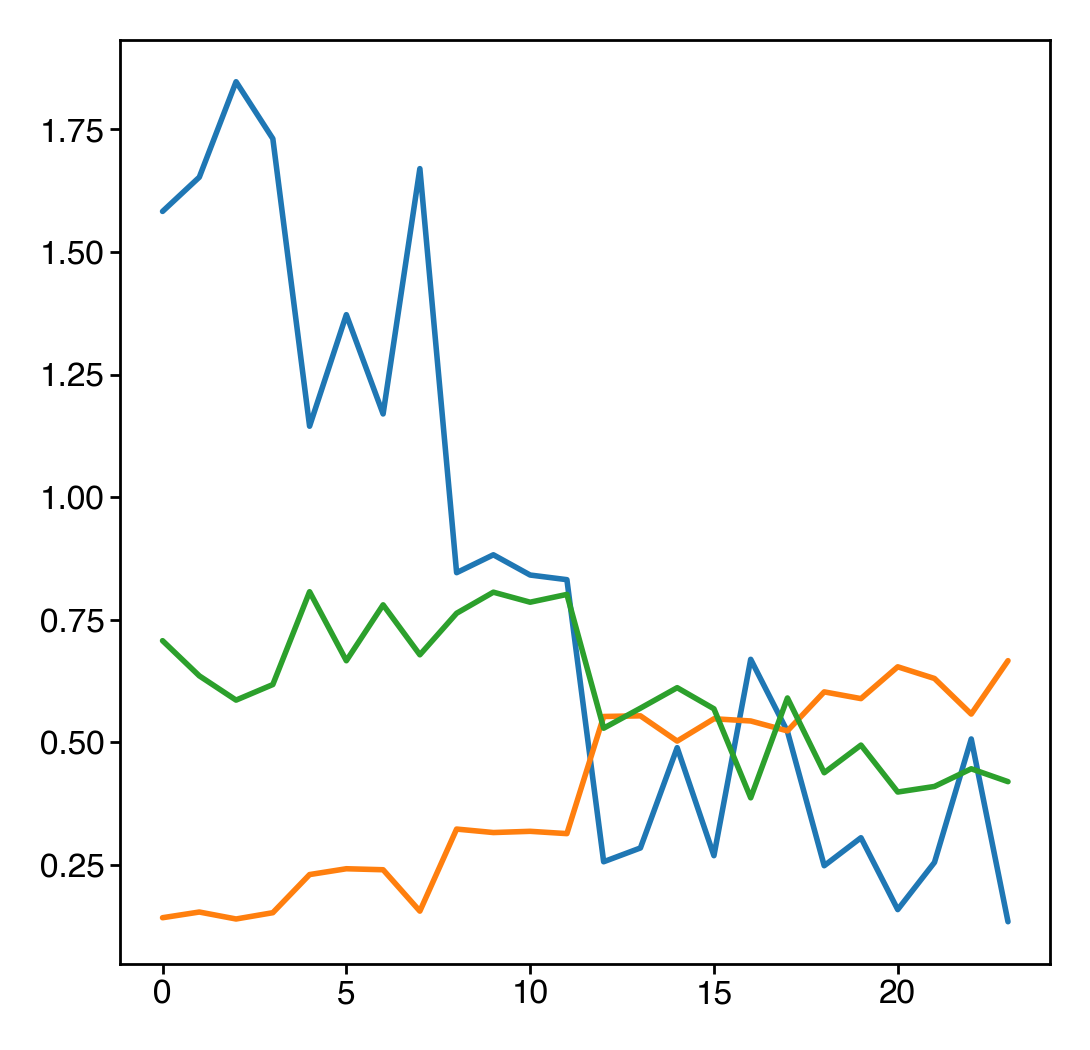

In [69]:
plt.plot(scores)

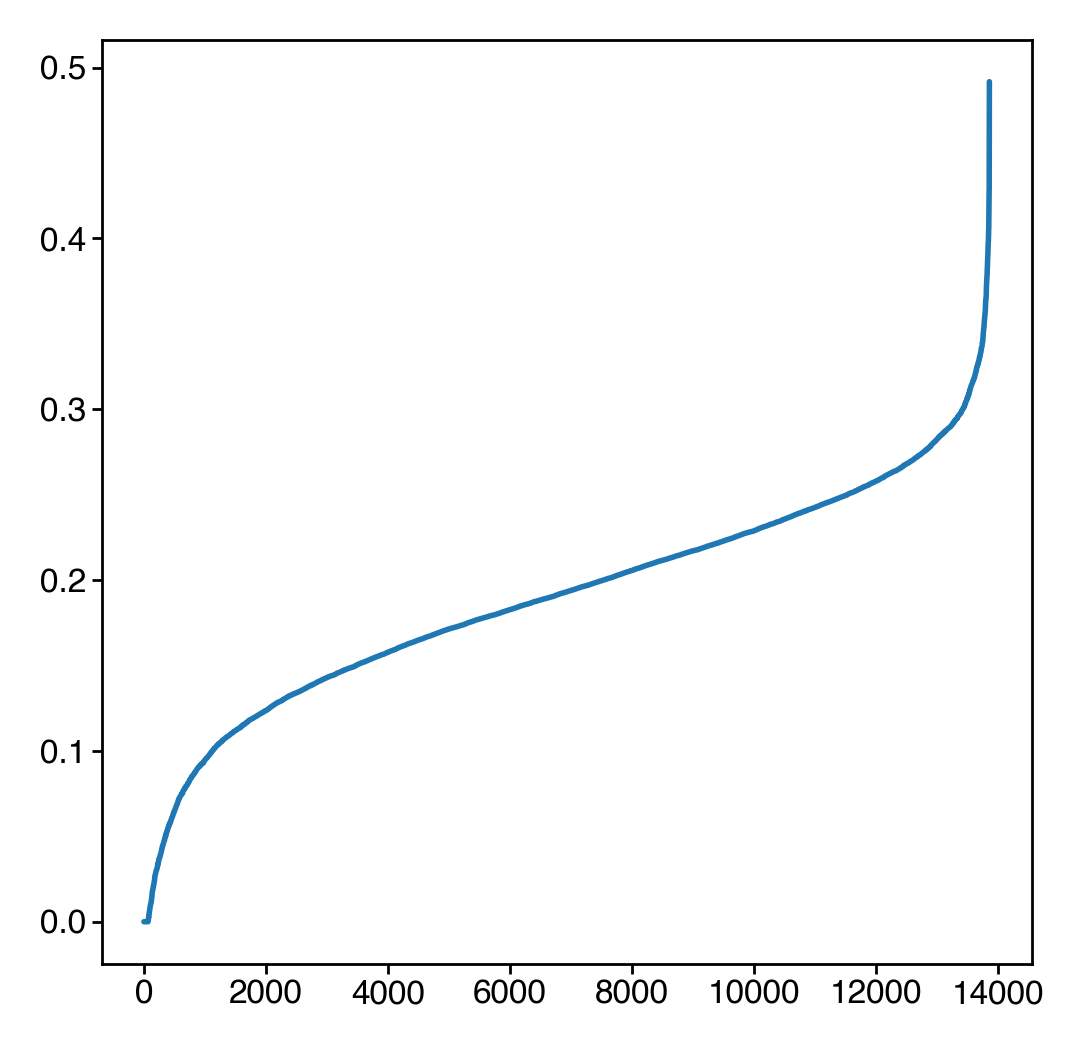

In [70]:
plt.plot(np.sort(nmf.components_[0]))

In [71]:
pca.components_.shape

(10, 13864)

In [72]:
meth_df.shape

(24, 13864)

In [73]:
meth_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 24 entries, ('4_01_01', 'e6ad4e15-0ce1-4833-a751-09aa15bfa2e5', 4, 4) to ('90_04_01', '3b97044c-14c6-416f-be9e-6d3899d2b04e', 90, 55)
Columns: 13864 entries, cg12174936_BC11 to rs48521828_BC11
dtypes: float64(13864)
memory usage: 2.5+ MB


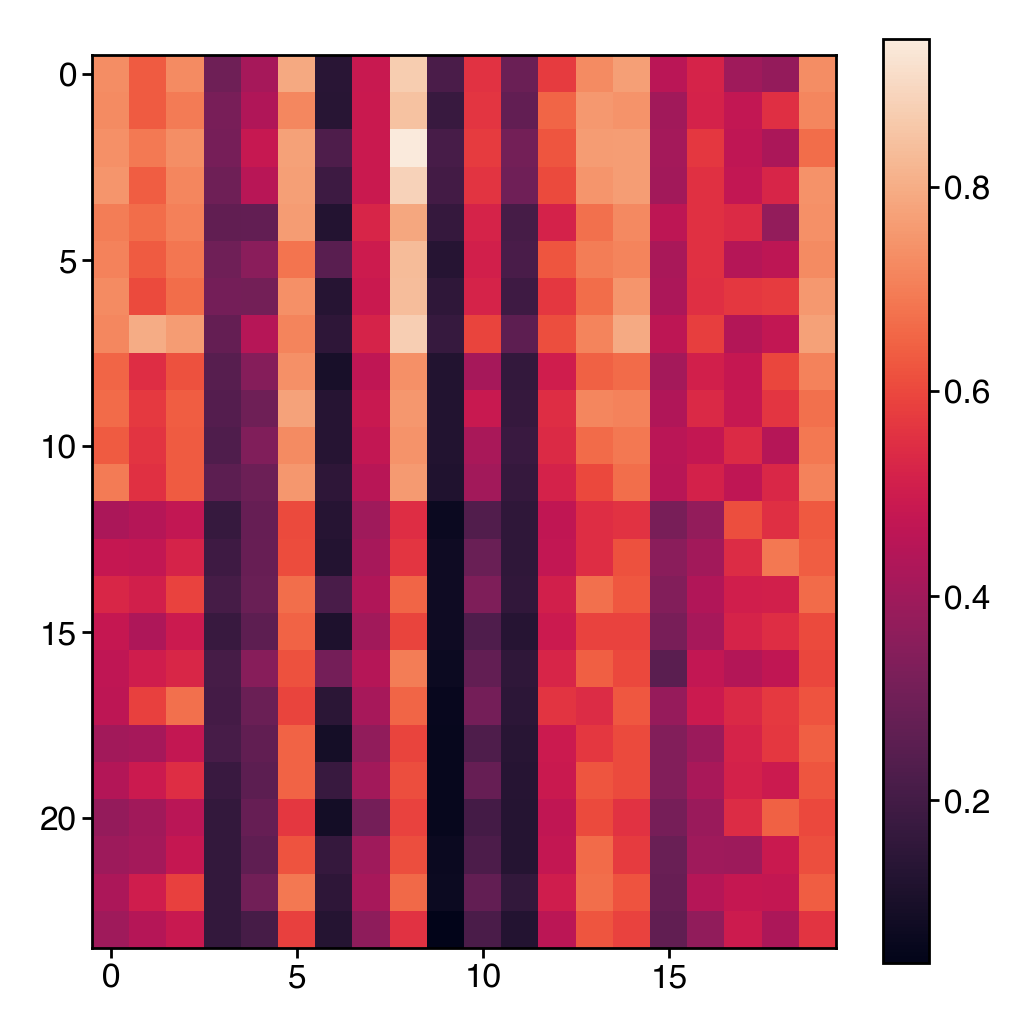

In [74]:
plt.imshow(meth_df[meth_df.columns[:20]])
plt.colorbar()

## Find parameter set that outperforms chron. age

In [24]:
beh_df = pd.read_parquet('/n/scratch/users/w/wg41/bio-age-model/ontogeny-predictions.parquet')

In [13]:
files = sorted(Path('/n/scratch/users/w/wg41/bio-age-model').glob('ontogeny-gridsearch*.p'))

In [14]:
len(files)

123

In [43]:
r2_outs = []
for f in tqdm(files):
    tmp = joblib.load(f)
    param_norm = np.mean([np.linalg.norm(v['params']['bio_basis_weights'], axis=1).mean() for v in keyfilter(lambda k: isinstance(k, int), tmp).values()])

    bdf = pd.DataFrame([pd.Series(x, index=beh_df.index) for x in pluck('bio_ages', keyfilter(lambda k: isinstance(k, int), tmp).values())]).T.mean(1)
    bdf = bdf.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')]]

    _r2 = r2_score(
        bdf,
        cross_val_predict(
            PLSRegression(n_components=2),
            pc_scores,
            bdf.to_numpy()[:, None],
            cv=LeaveOneOut(),
        ).squeeze(),
    )
    r2_outs.append({**tmp['grid_params'], 'heldout_r2': _r2, 'param_norm': param_norm})
r2_outs = pd.DataFrame(r2_outs)

  0%|          | 0/123 [00:00<?, ?it/s]

In [44]:
r2_outs

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm
0       1.0          0.001          4    0.887485    0.000053
1       1.0          0.300          4    0.887864    1.507282
2       1.0          1.000          4    0.886299    2.677185
3       1.0         10.000          4    0.886385    3.167210
4       1.0        100.000          4    0.886233    3.175262
..      ...            ...        ...         ...         ...
118    41.0          0.001         16    0.882952    0.000026
119    41.0          0.300         16    0.526988    1.677737
120    41.0          1.000         16    0.546124    5.536819
121    41.0         10.000         16    0.580054   10.880791
122    41.0        100.000         16    0.589885   11.986835

[123 rows x 5 columns]

In [50]:
r2_outs.query('heldout_r2 > 0.896')

Empty DataFrame
Columns: [age_sd, bio_params_sd, n_splines, heldout_r2, param_norm]
Index: []

<Axes: xlabel='bio_params_sd', ylabel='age_sd'>

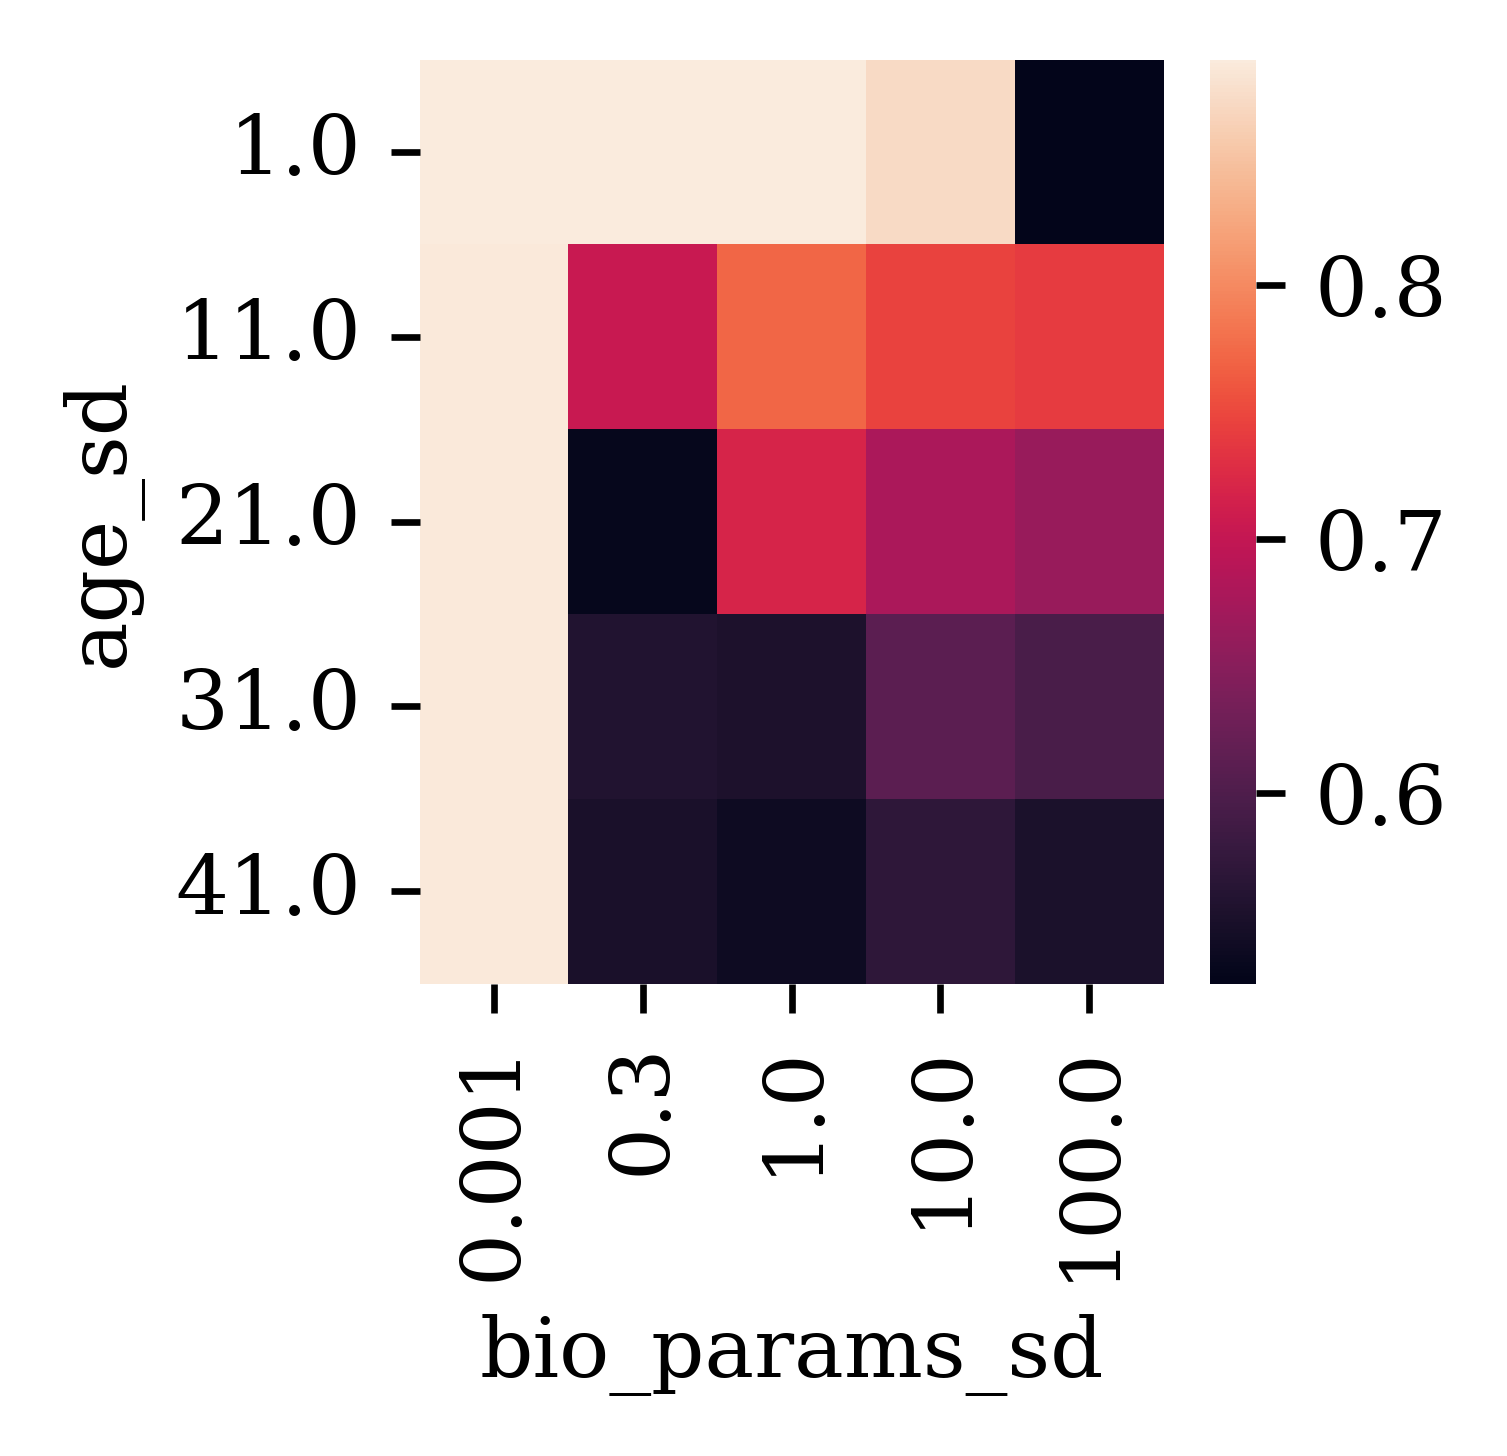

In [46]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='age_sd', columns='bio_params_sd'))

<Axes: xlabel='n_splines', ylabel='age_sd'>

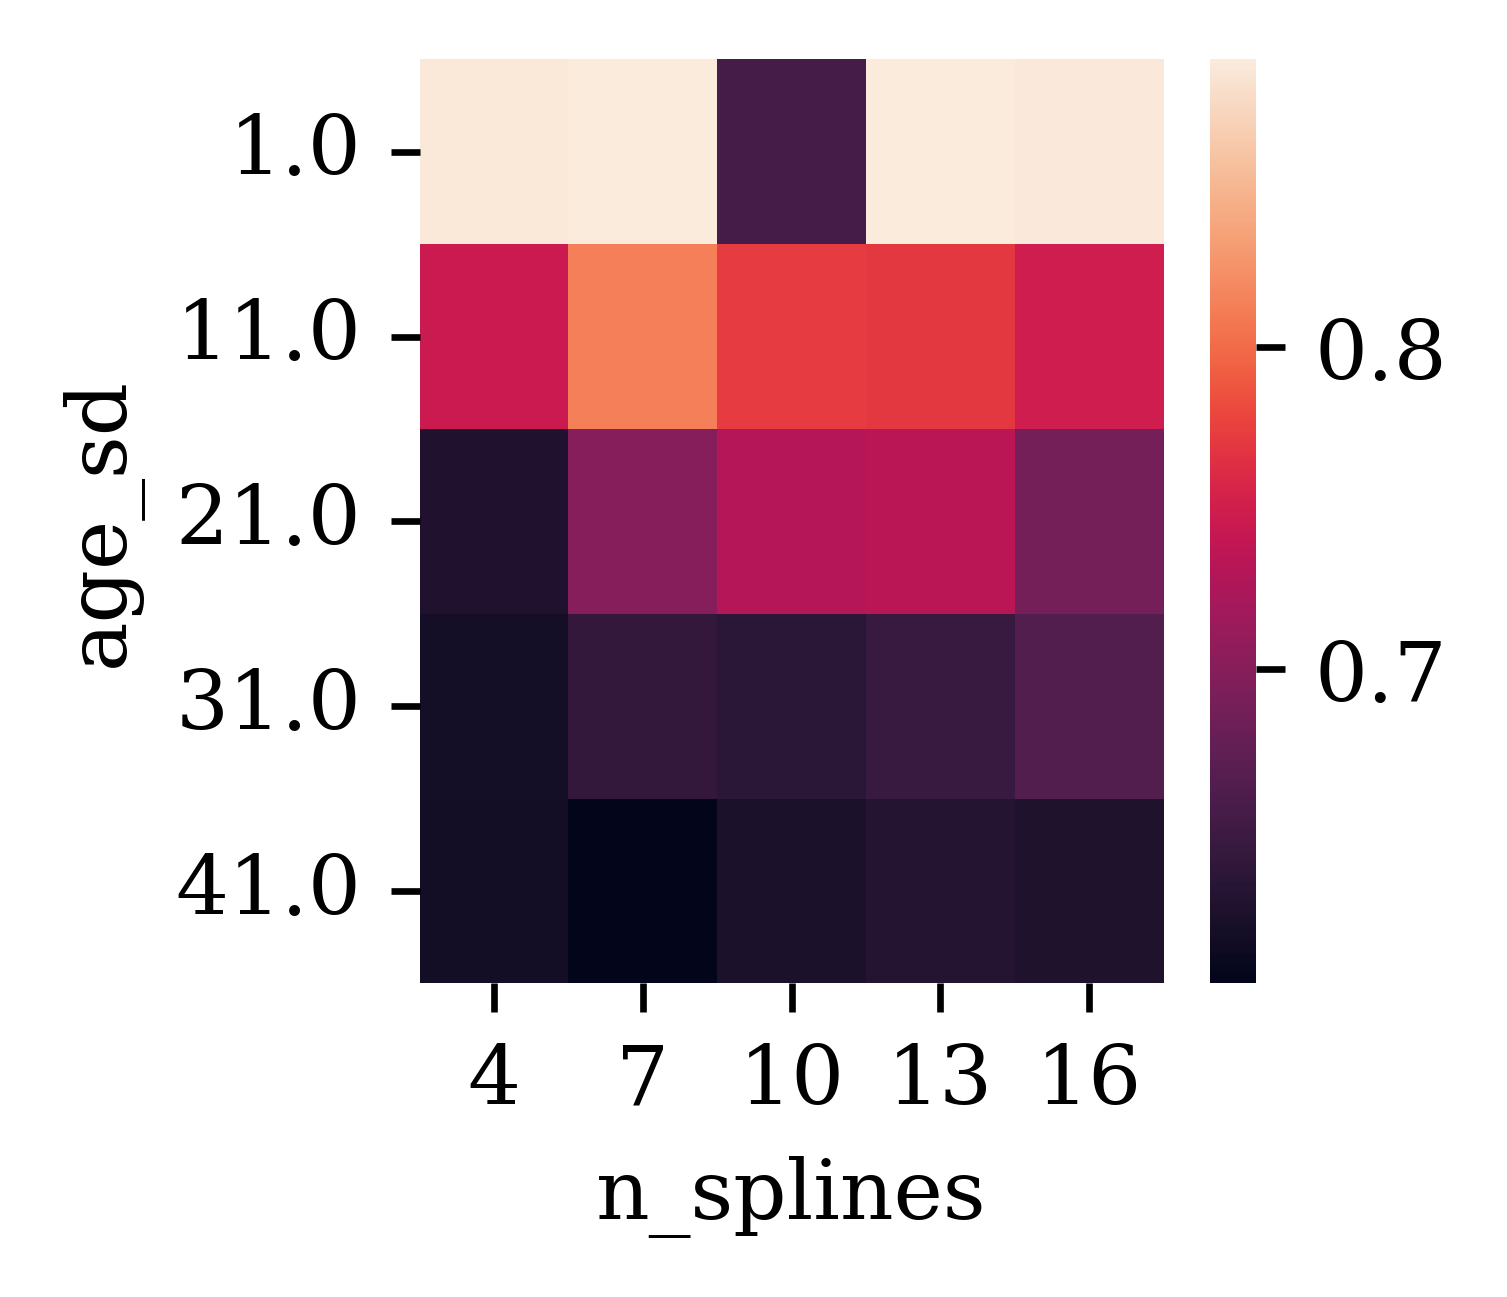

In [47]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='age_sd', columns='n_splines'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

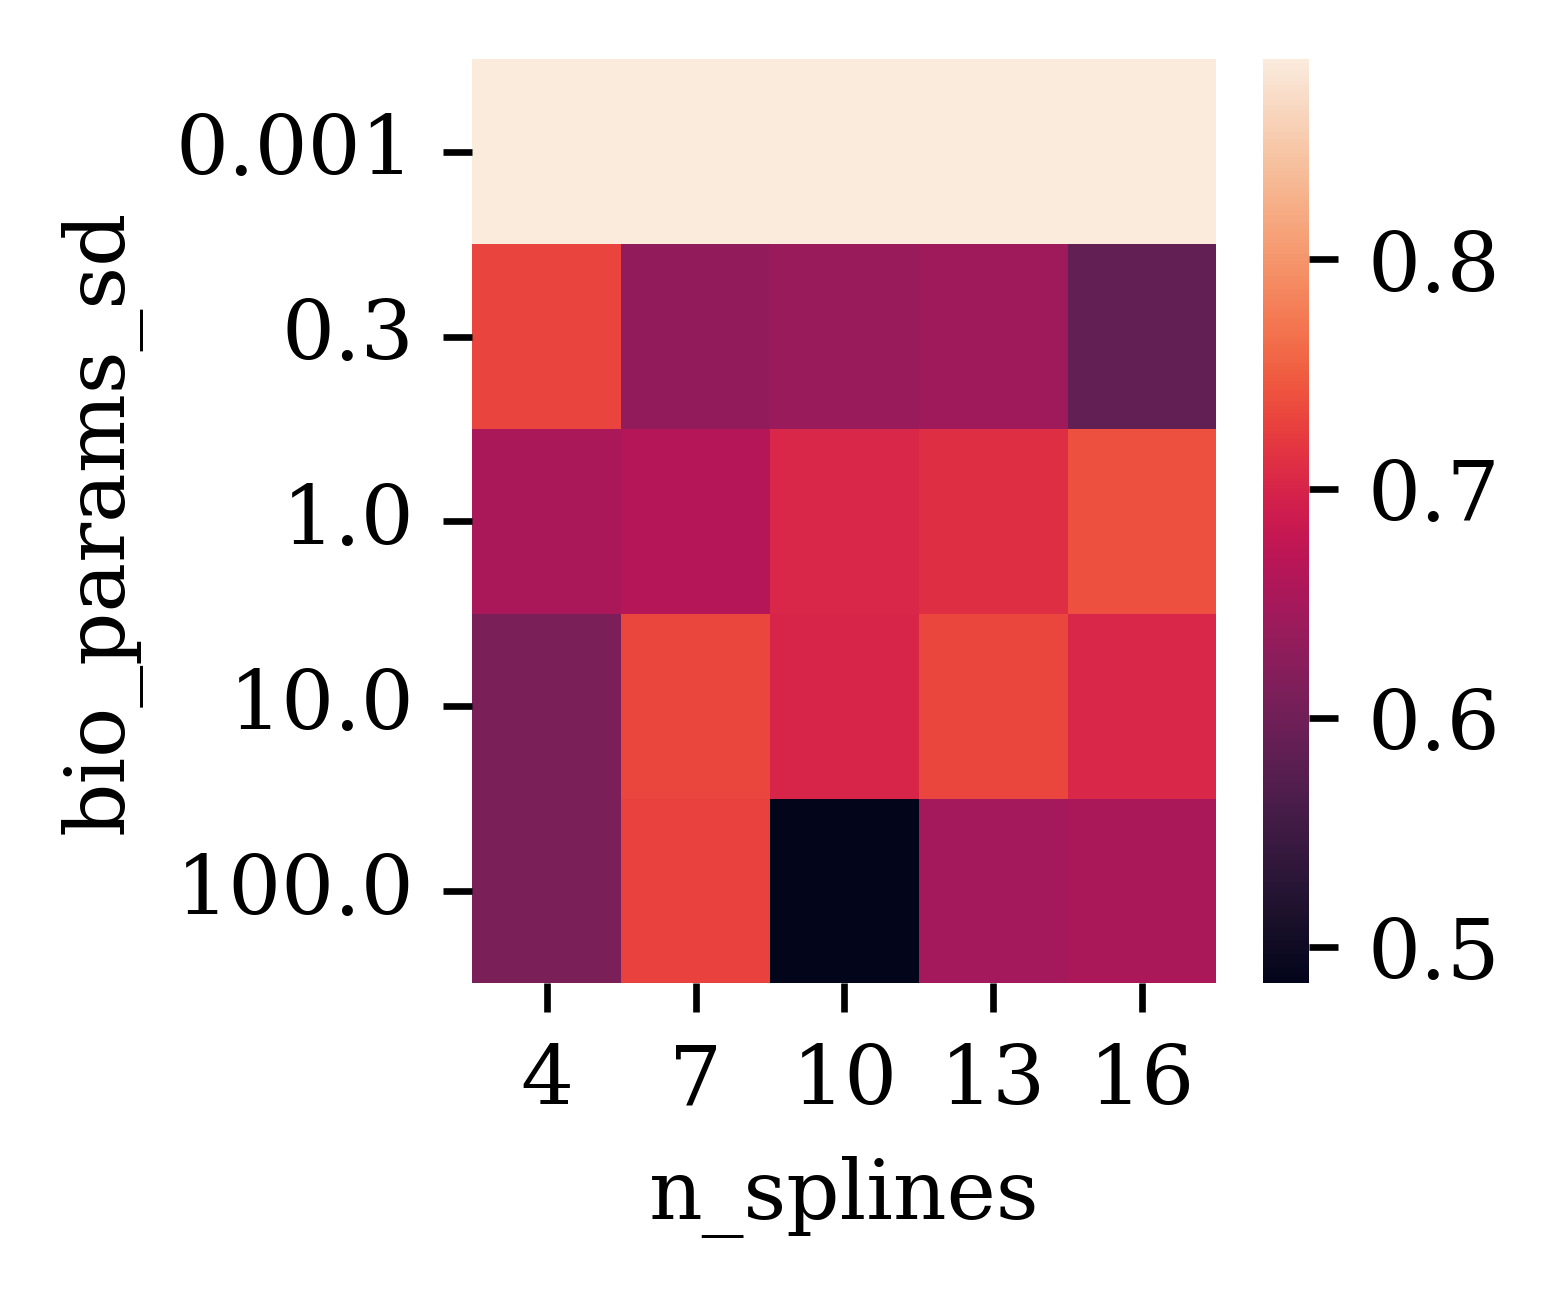

In [48]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='bio_params_sd', columns='n_splines'))

In [20]:
files = sorted(Path('/n/scratch/users/w/wg41/bio-age-model').glob('ontogeny-high-resolution*.p'))

In [21]:
len(files)

462

In [53]:
r2_outs = []
for f in tqdm(files):
    tmp = joblib.load(f)
    param_norm = np.mean([np.linalg.norm(v['params']['bio_basis_weights'], axis=1).mean() for v in keyfilter(lambda k: isinstance(k, int), tmp).values()])

    bdf = pd.DataFrame([pd.Series(x, index=beh_df.index) for x in pluck('bio_ages', keyfilter(lambda k: isinstance(k, int), tmp).values())]).T.mean(1)
    bdf = bdf.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')]]

    _r2 = r2_score(
        bdf,
        cross_val_predict(
            PLSRegression(n_components=2),
            pc_scores,
            bdf.to_numpy()[:, None],
            cv=LeaveOneOut(),
        ).squeeze(),
    )
    r2_outs.append({**tmp['grid_params'], 'heldout_r2': _r2, 'param_norm': param_norm})
r2_outs = pd.DataFrame(r2_outs)

  0%|          | 0/444 [00:00<?, ?it/s]

In [54]:
r2_outs

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm
0      15.0          10.00          8    0.707748    6.443750
1      27.0           5.00          9    0.677414    6.553155
2      15.0           0.01          5    0.887117    0.005042
3      18.0           0.10          8    0.705114    0.387866
4      27.0           3.00          9    0.684120    6.334558
..      ...            ...        ...         ...         ...
439    21.0           0.30          4    0.631822    1.690213
440     9.0           0.01          9    0.886092    0.004133
441    24.0           0.20          9    0.530316    1.020662
442    27.0           0.01          5    0.884360    0.004937
443    27.0           0.50          4    0.596191    2.559216

[444 rows x 5 columns]

In [55]:
r2_outs.query('heldout_r2 > 0.896')

Empty DataFrame
Columns: [age_sd, bio_params_sd, n_splines, heldout_r2, param_norm]
Index: []

<Axes: xlabel='bio_params_sd', ylabel='age_sd'>

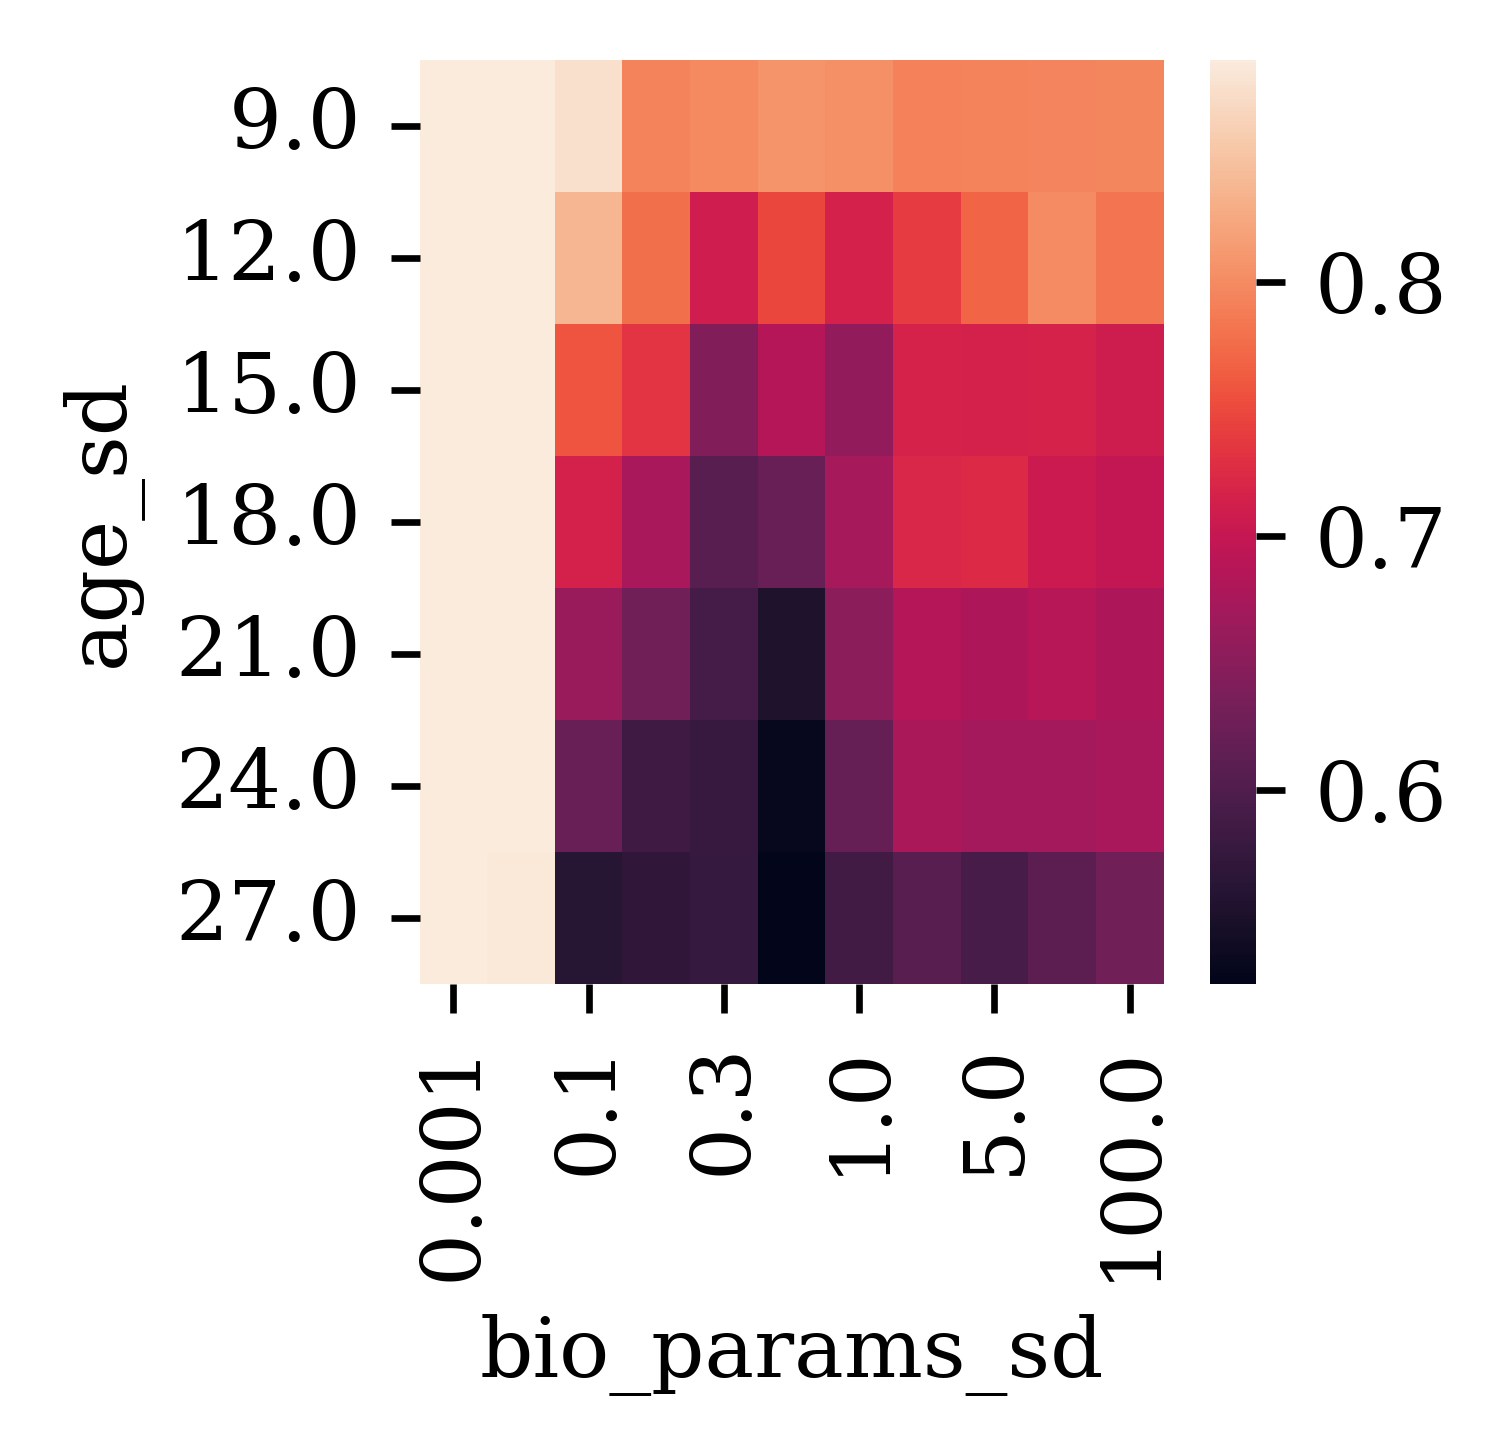

In [56]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='age_sd', columns='bio_params_sd'))

<Axes: xlabel='n_splines', ylabel='age_sd'>

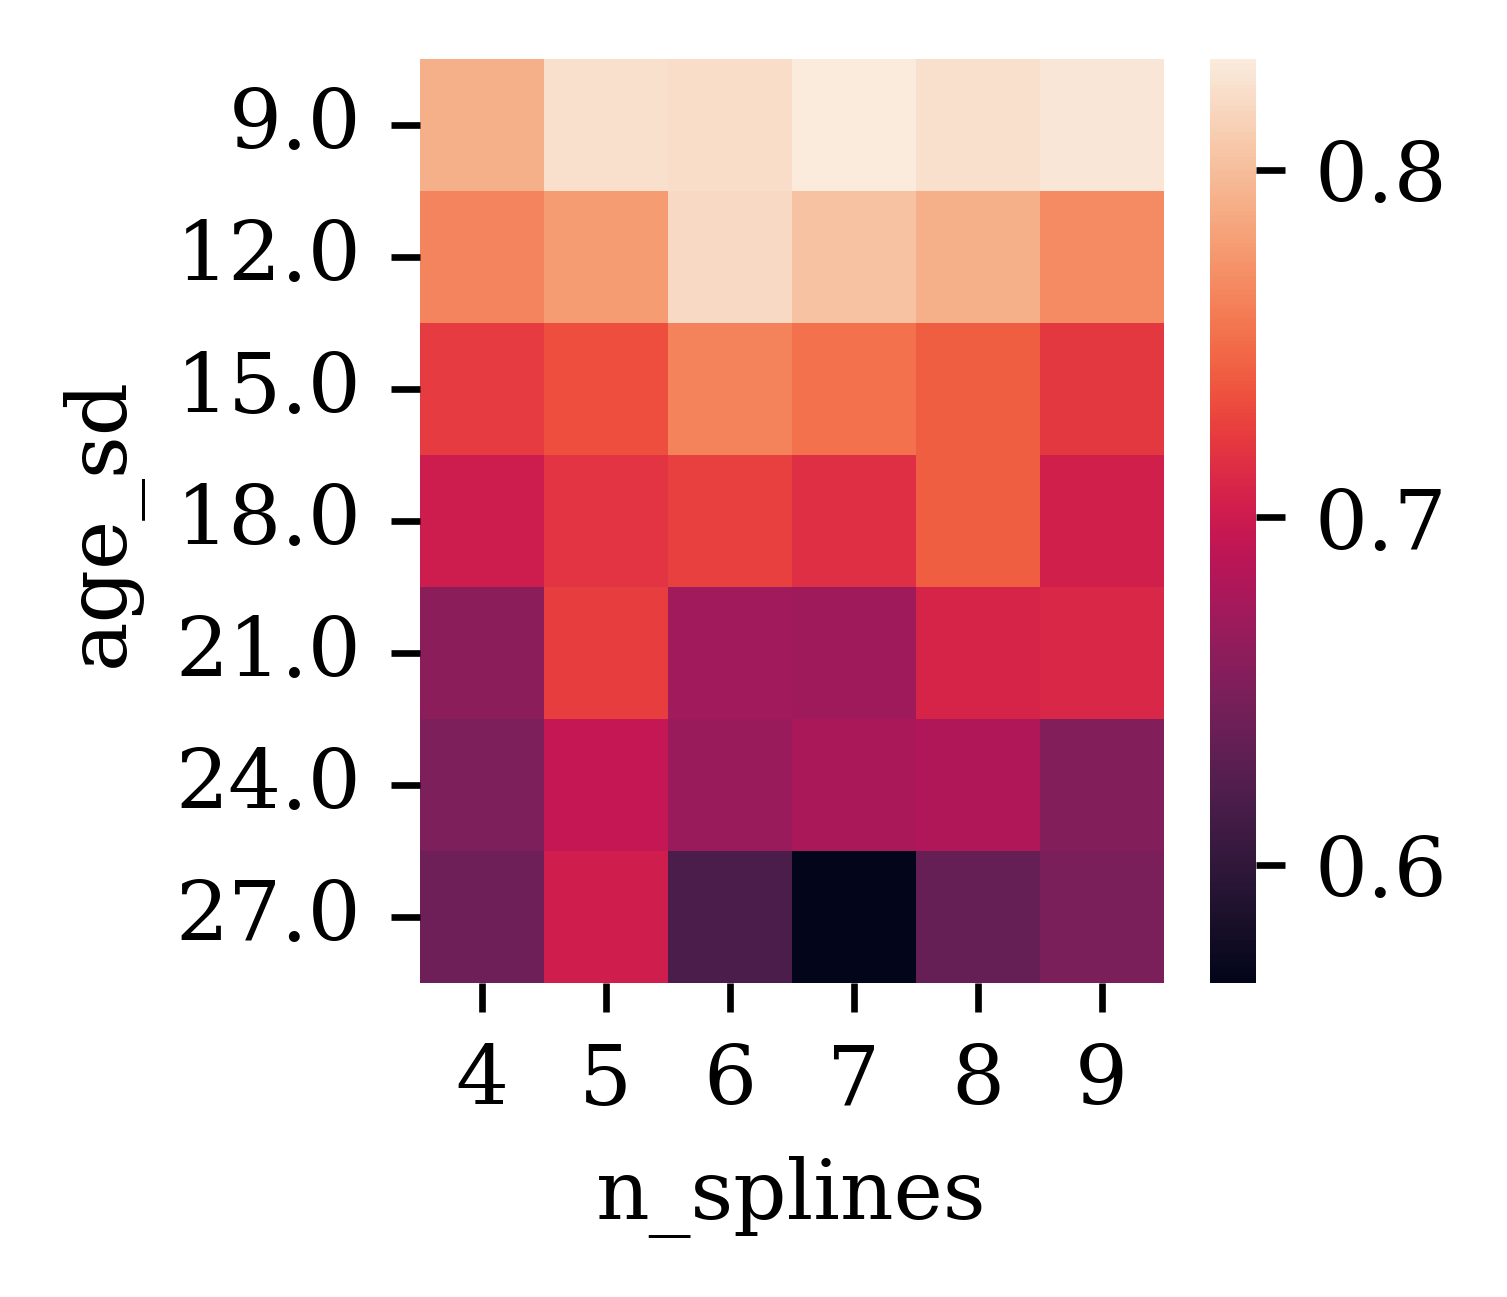

In [57]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='age_sd', columns='n_splines'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

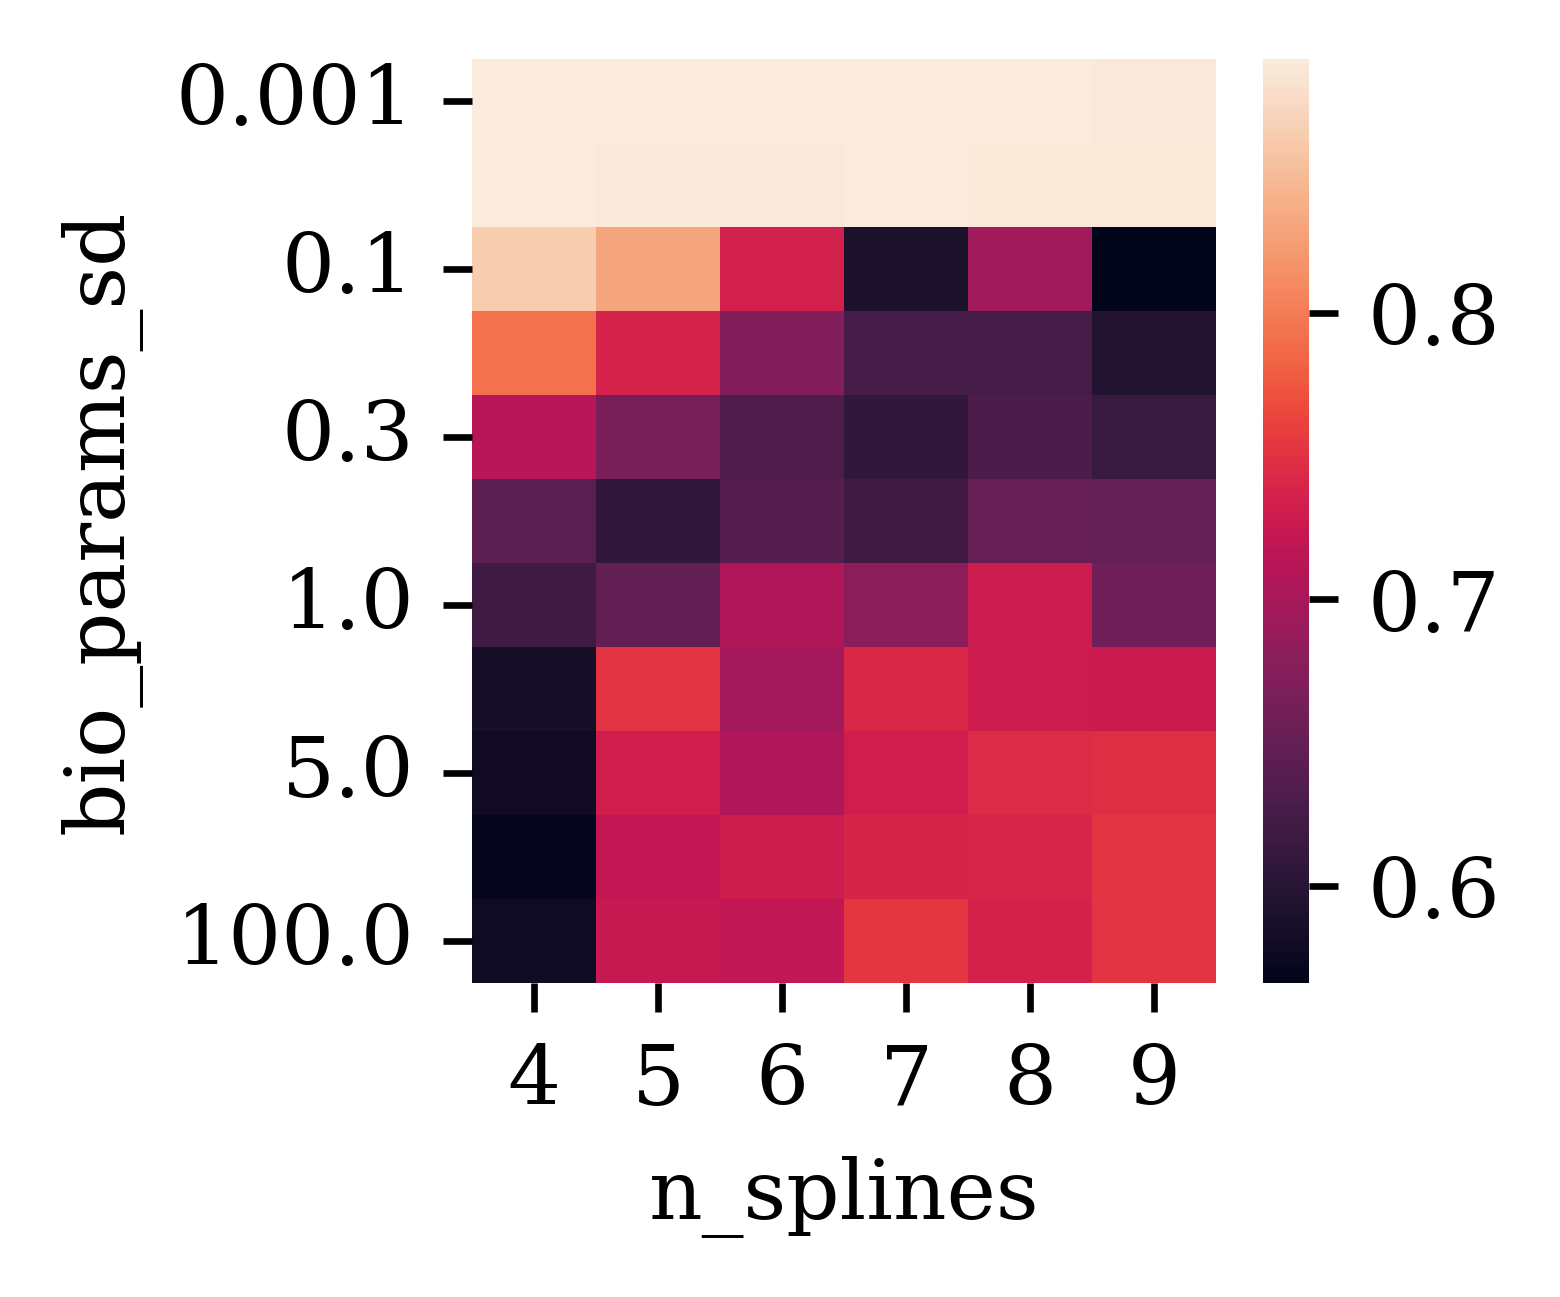

In [58]:
figure(2, 2)
sns.heatmap(pd.pivot_table(r2_outs, values='heldout_r2', index='bio_params_sd', columns='n_splines'))

In [60]:
r2_outs.query('heldout_r2 > 0.89')

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm
52     24.0           0.01          4    0.890626    0.005145
119     9.0           0.10          9    0.894066    0.349722
150    15.0           0.20          4    0.895312    1.013297
306    15.0           0.01          4    0.890452    0.005218

In [28]:
r2_outs = []
for f in tqdm(files):
    tmp = joblib.load(f)
    param_norm = np.mean([np.linalg.norm(v['params']['bio_basis_weights'], axis=1).mean() for v in keyfilter(lambda k: isinstance(k, int), tmp).values()])

    bdf = pd.DataFrame([pd.Series(x, index=beh_df.index) for x in pluck('bio_ages', keyfilter(lambda k: isinstance(k, int), tmp).values())]).T.mean(1)
    bdf = bdf.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values('uuid')]]

    _r2 = r2_score(
        bdf,
        cross_val_predict(
            PLSRegression(n_components=2),
            pc_scores,
            bdf.to_numpy()[:, None],
            cv=LeaveOneOut(),
        ).squeeze(),
    )
    if _r2 > 0.85:
        # _r2_full = r2_score(
        #     bdf,
        #     cross_val_predict(
        #         PLSRegression(n_components=2),
        #         meth_df,
        #         bdf.to_numpy()[:, None],
        #         cv=LeaveOneOut(),
        #     ).squeeze(),
        # )
        resid = bdf.to_numpy() - age.to_numpy()
        _r2_full = r2_score(
            resid,
            cross_val_predict(
                PLSRegression(n_components=2),
                meth_df,
                resid[:, None],
                cv=LeaveOneOut(),
                n_jobs=-1,
            ).squeeze(),
        )
        print(f"{_r2=:0.4f}, {_r2_full=:0.4f}")
        r2_outs.append({**tmp['grid_params'], 'heldout_r2': _r2, 'param_norm': param_norm, 'heldout_full_r2': _r2_full})
r2_outs = pd.DataFrame(r2_outs)

  0%|          | 0/462 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


_r2=0.8946, _r2_full=0.8431
_r2=0.8944, _r2_full=0.4543
_r2=0.8945, _r2_full=-0.4464
_r2=0.8618, _r2_full=0.1386
_r2=0.8914, _r2_full=0.8748
_r2=0.8942, _r2_full=-0.6867
_r2=0.8960, _r2_full=-0.4893
_r2=0.8786, _r2_full=0.0839
_r2=0.8895, _r2_full=0.1349
_r2=0.8957, _r2_full=-0.1432
_r2=0.8924, _r2_full=0.8369
_r2=0.8976, _r2_full=-0.3846
_r2=0.8956, _r2_full=-0.3956
_r2=0.8939, _r2_full=0.7820
_r2=0.8938, _r2_full=-0.0372
_r2=0.8956, _r2_full=0.8099
_r2=0.8943, _r2_full=-0.7210
_r2=0.8799, _r2_full=0.0337
_r2=0.8960, _r2_full=-0.4728
_r2=0.8957, _r2_full=-0.0423
_r2=0.8953, _r2_full=-0.1303
_r2=0.8938, _r2_full=-0.3794
_r2=0.8957, _r2_full=0.8397
_r2=0.8940, _r2_full=0.7193
_r2=0.8903, _r2_full=0.8328
_r2=0.8948, _r2_full=0.7377
_r2=0.8890, _r2_full=-0.0735
_r2=0.8528, _r2_full=0.4886
_r2=0.8957, _r2_full=-0.3436
_r2=0.8959, _r2_full=-0.5792
_r2=0.8946, _r2_full=-0.1768
_r2=0.8951, _r2_full=0.2173
_r2=0.8864, _r2_full=0.0991
_r2=0.8954, _r2_full=0.8423
_r2=0.8523, _r2_full=0.8750
_r2=

KeyboardInterrupt: 

In [29]:
r2_outs = pd.DataFrame(r2_outs)


In [32]:
r2_outs.head()

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm  heldout_full_r2
0    15.0          0.010          5    0.894561    0.005042         0.843054
1     9.0          0.010          5    0.894413    0.005101         0.454260
2    27.0          0.001          6    0.894479    0.000046        -0.446414
3    12.0          0.300          4    0.861799    1.628237         0.138559
4    27.0          0.010          6    0.891406    0.004735         0.874820

<Axes: xlabel='n_splines', ylabel='age_sd'>

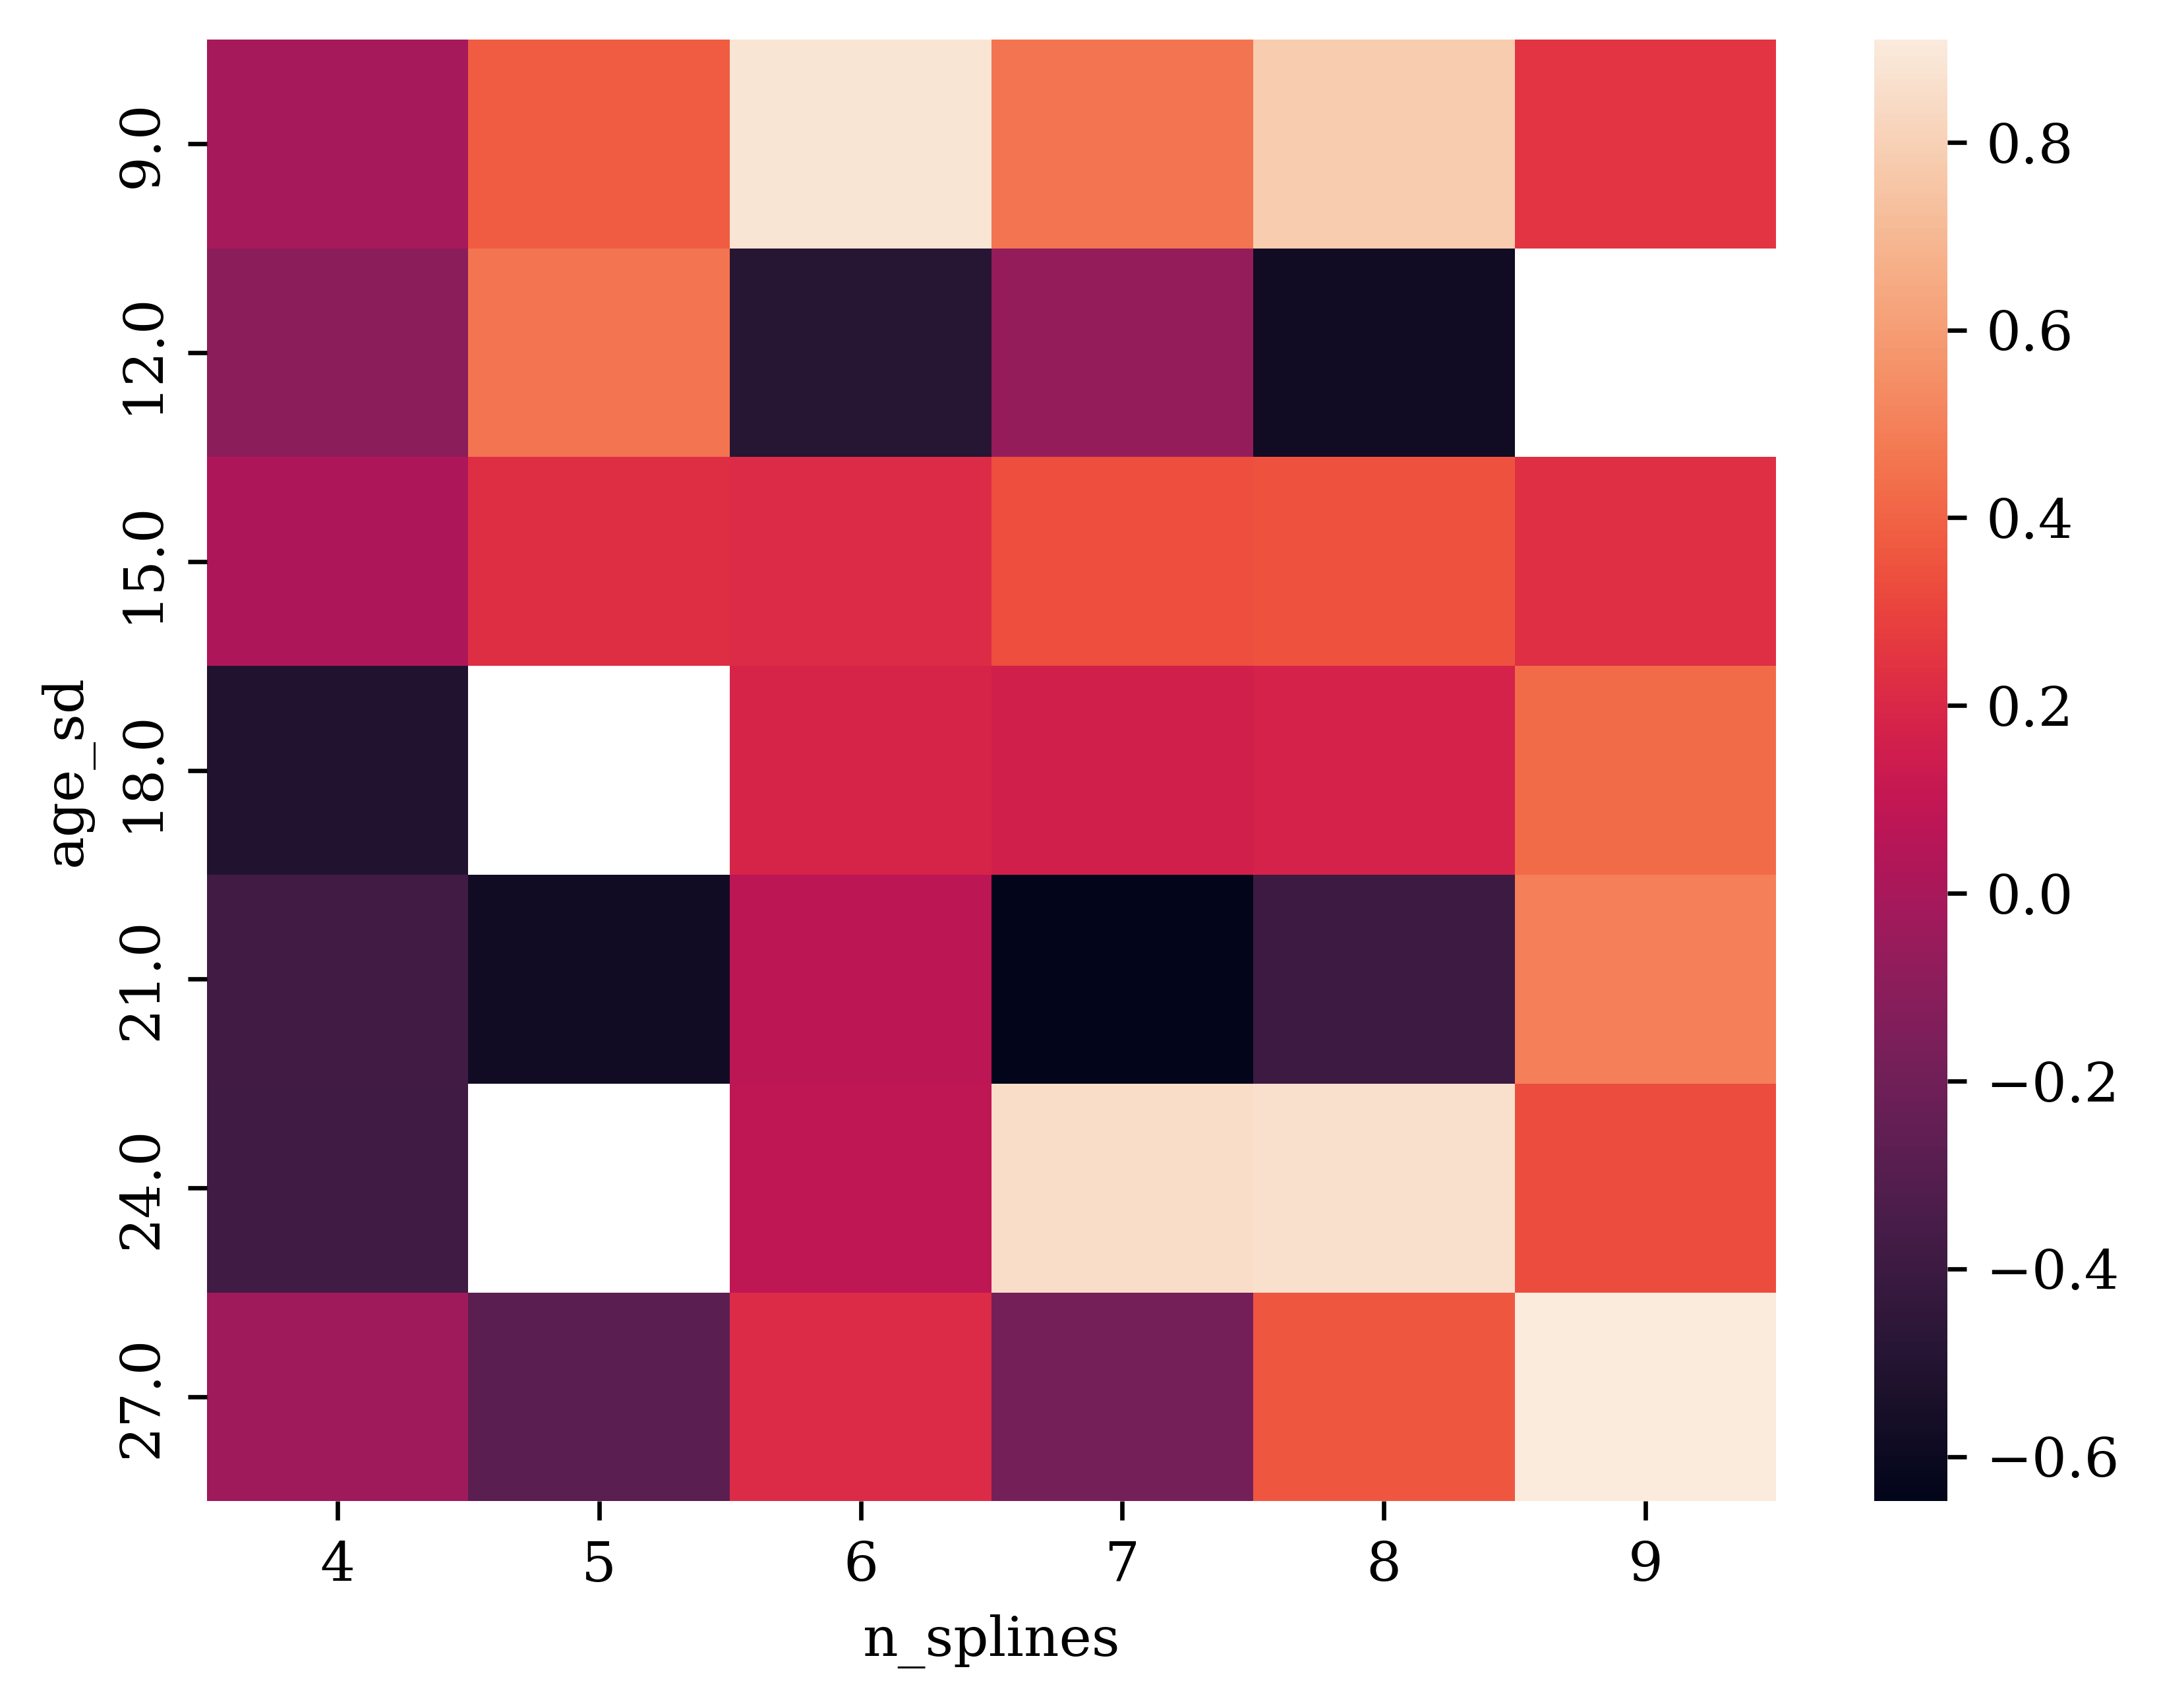

In [33]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='age_sd', values='heldout_full_r2'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

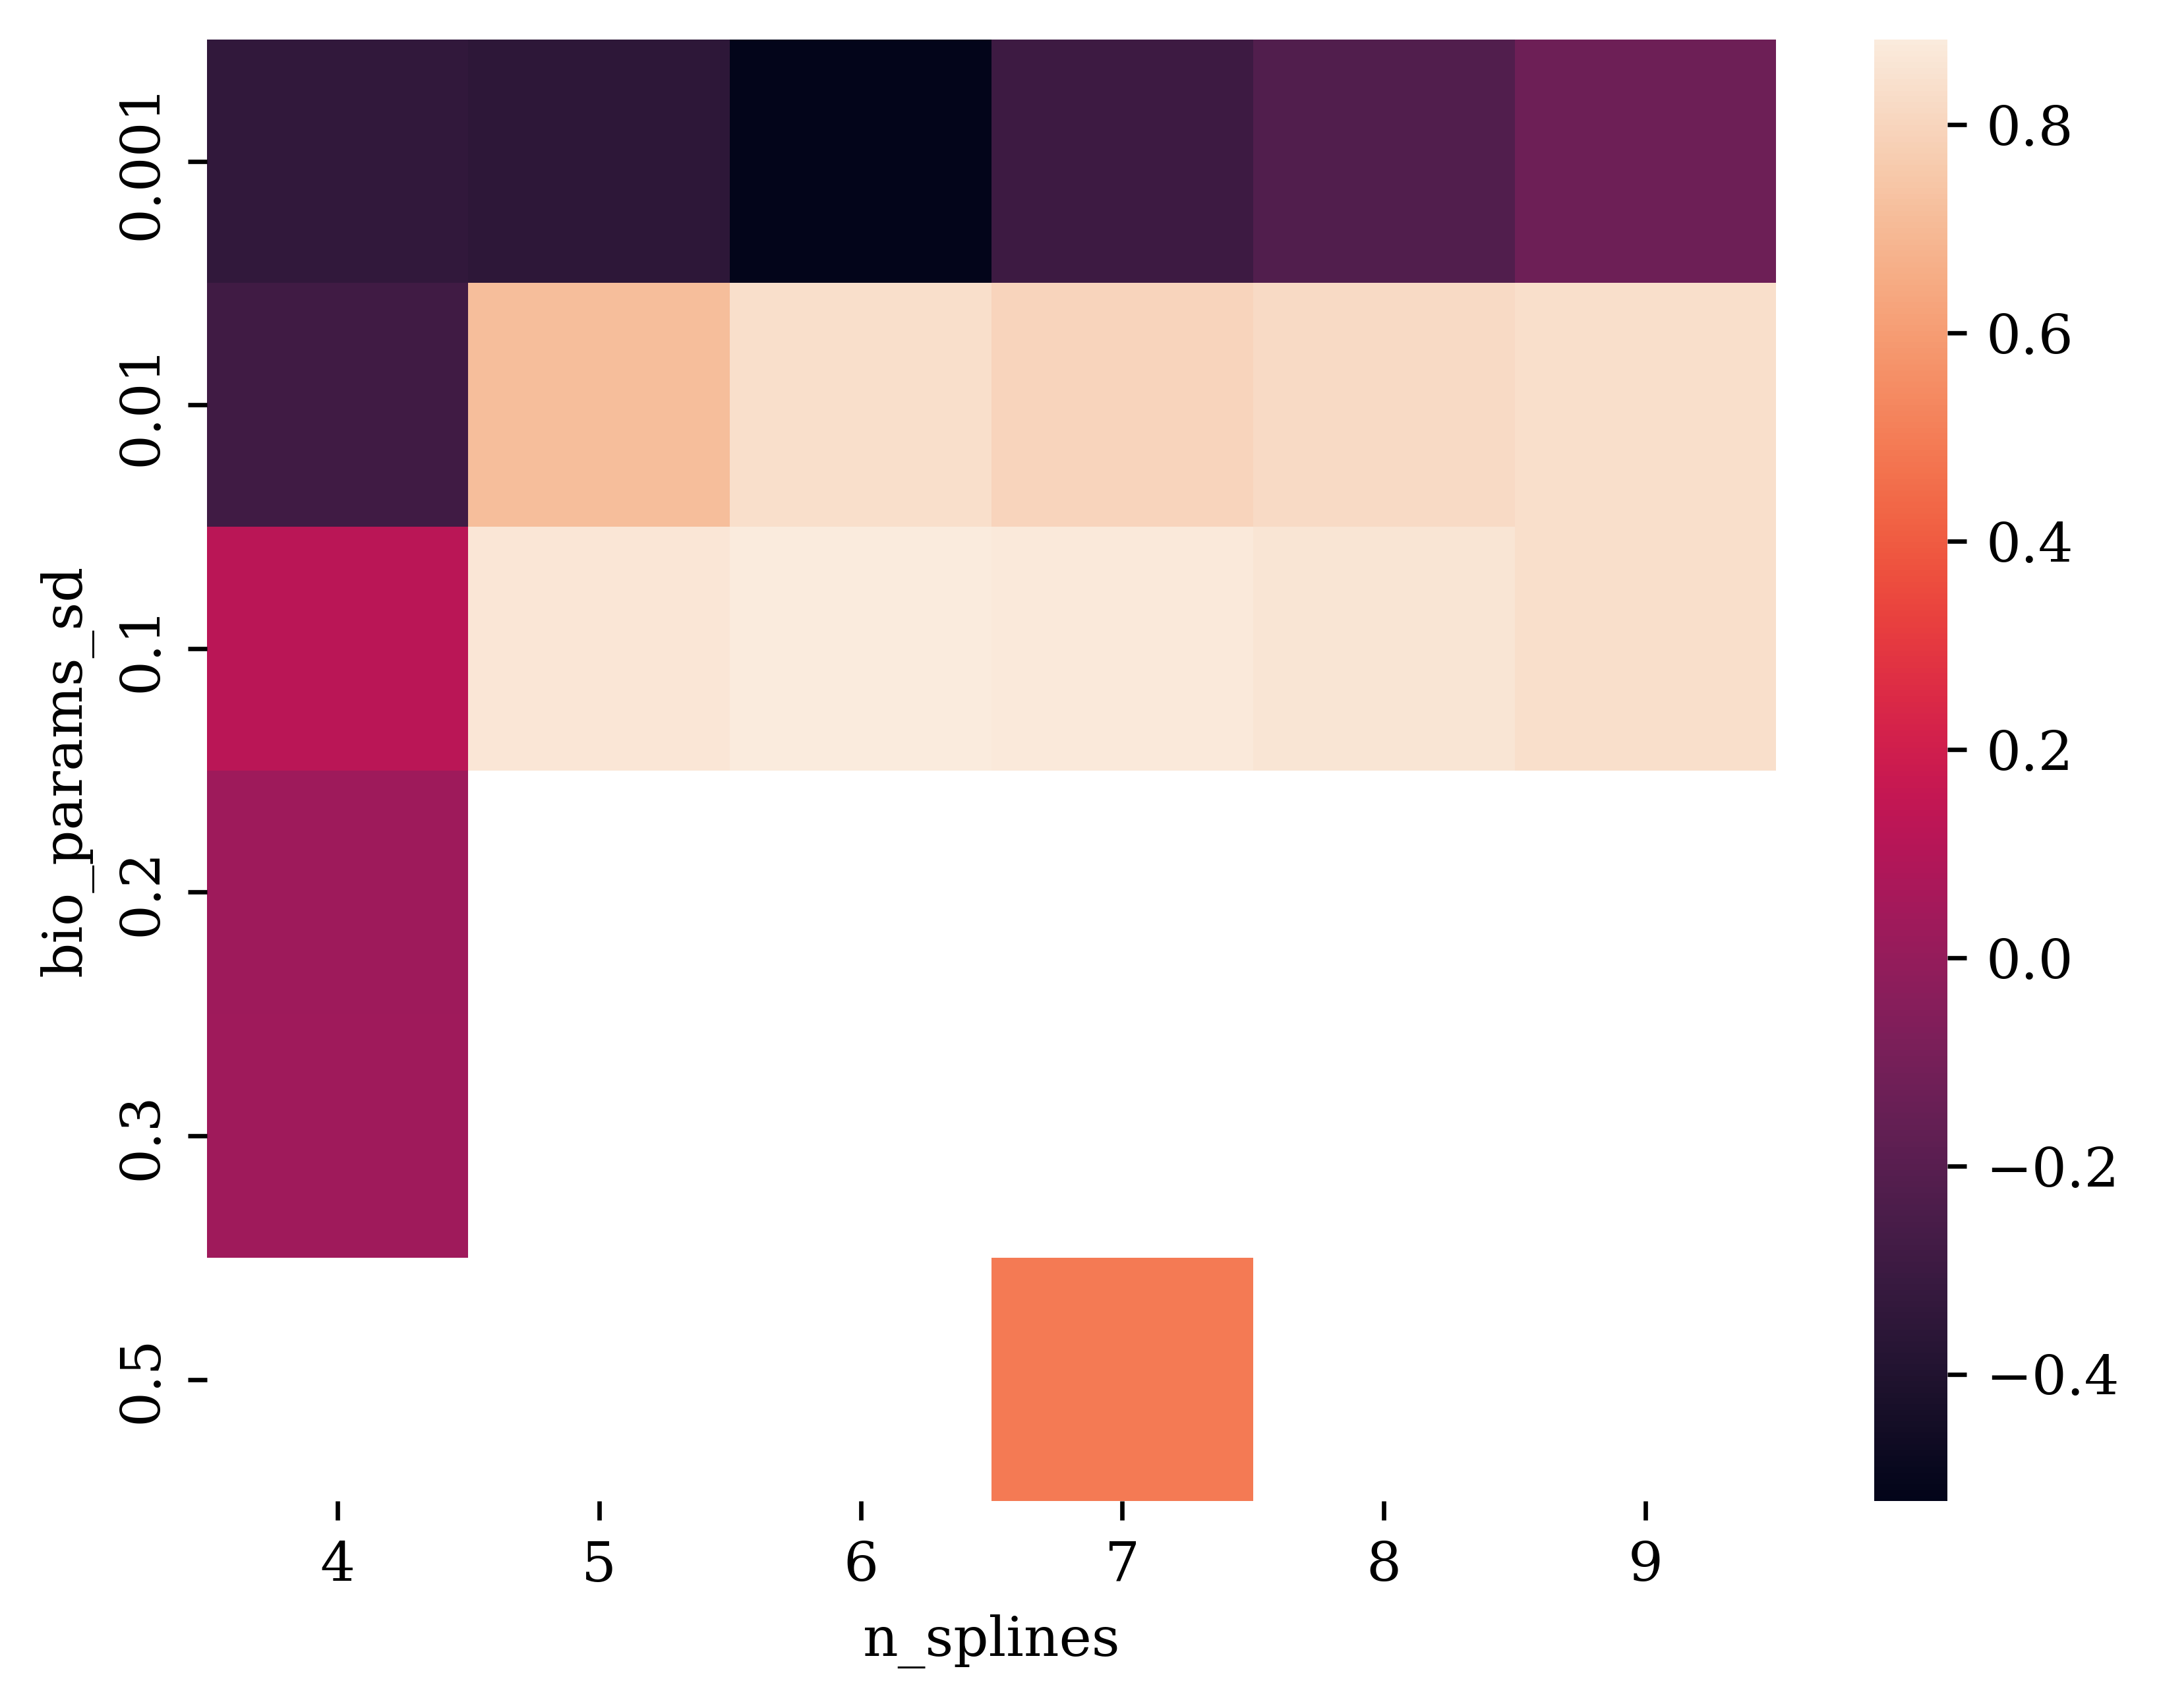

In [35]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='bio_params_sd', values='heldout_full_r2'))

<Axes: xlabel='n_splines', ylabel='age_sd'>

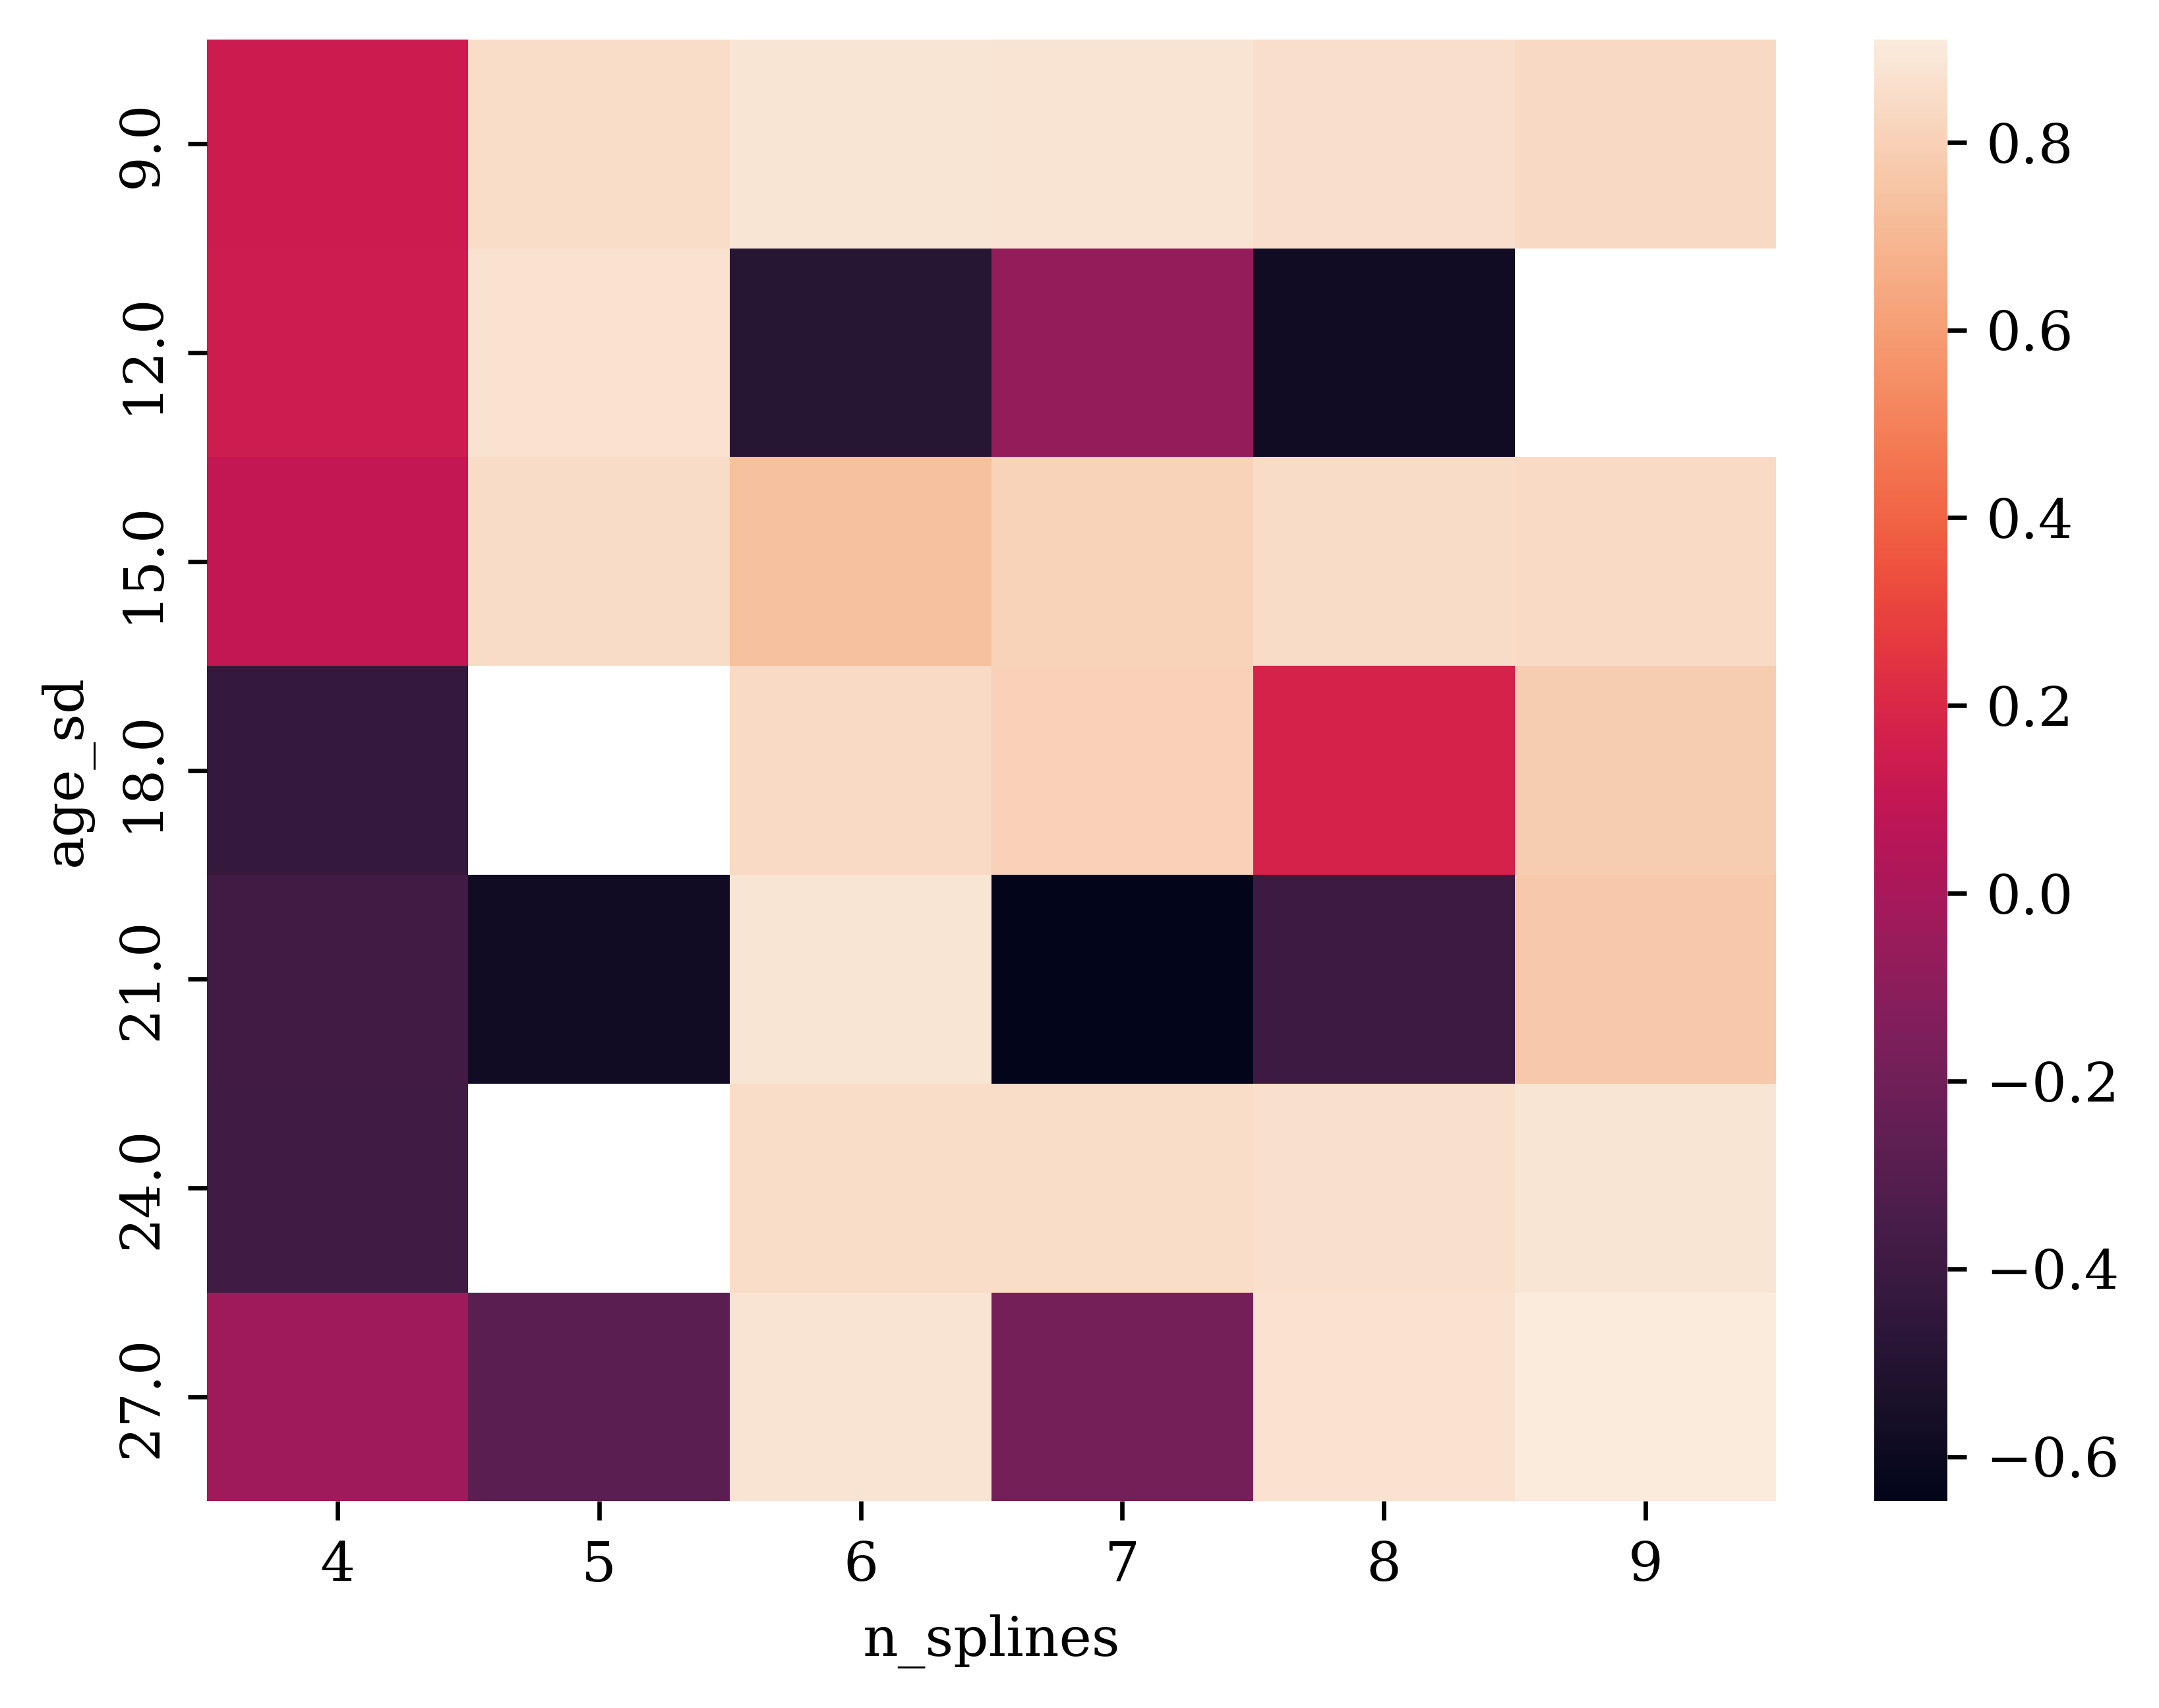

In [34]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='age_sd', values='heldout_full_r2', aggfunc='max'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

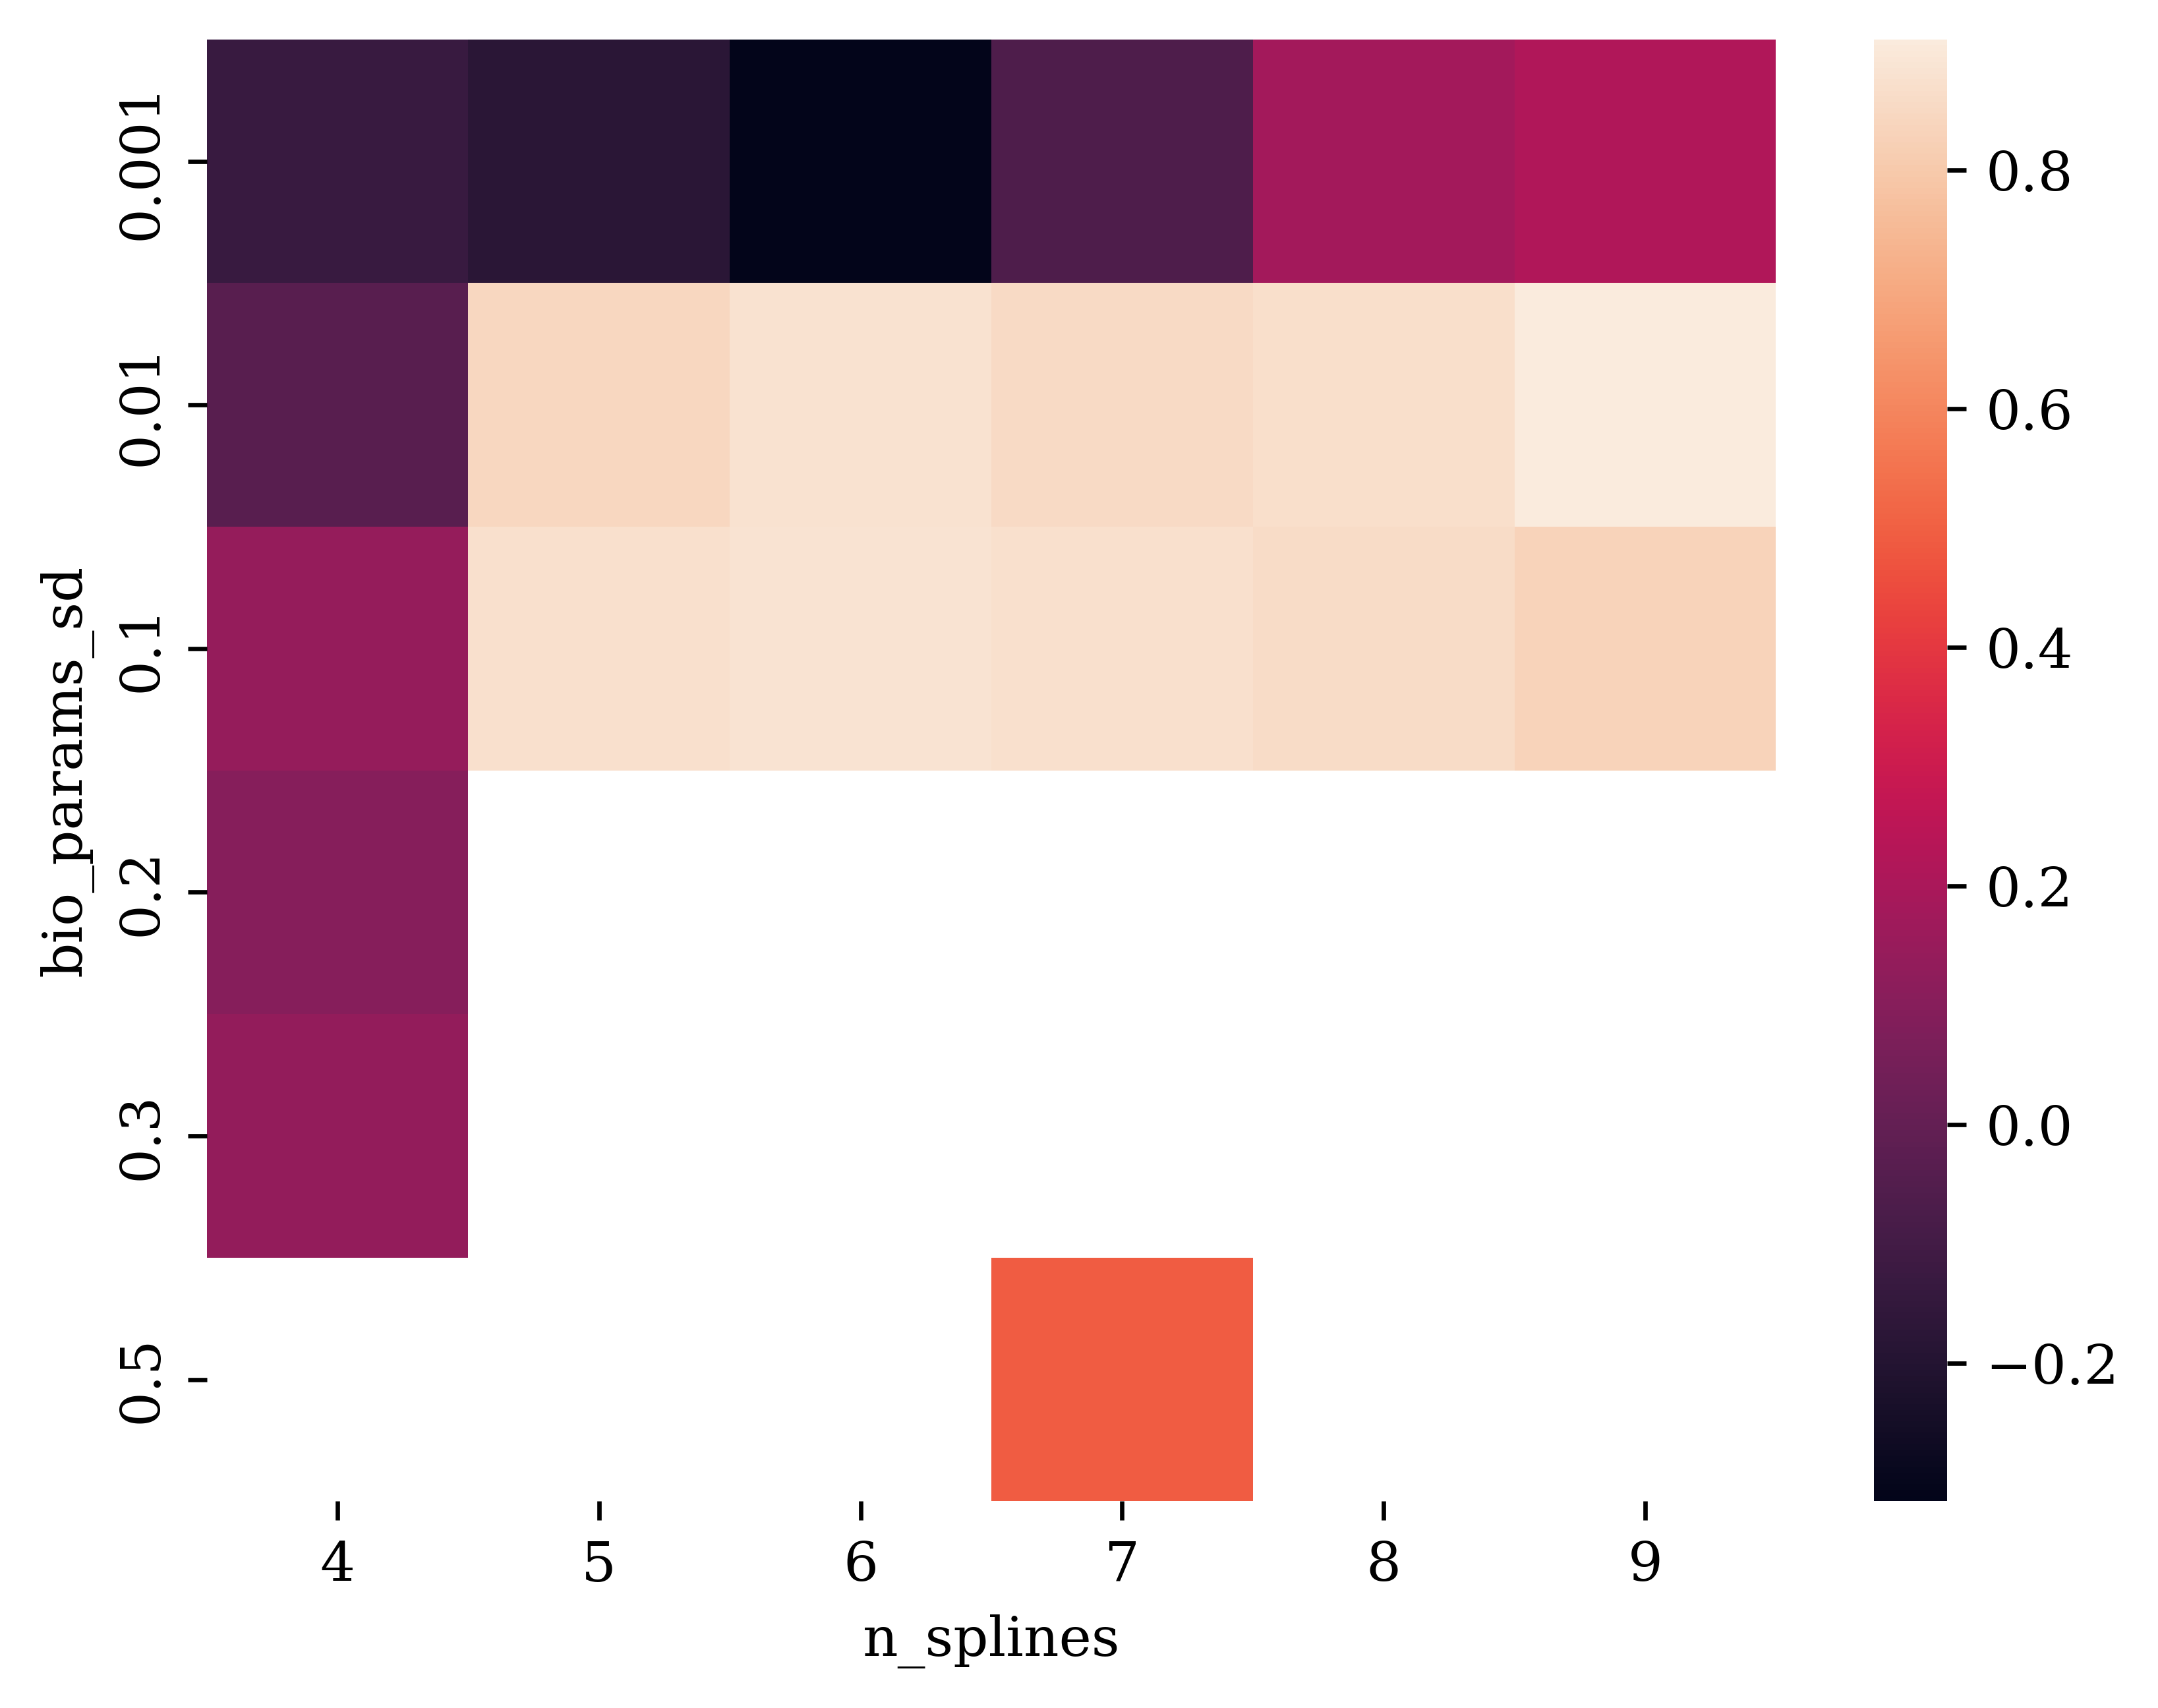

In [36]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='bio_params_sd', values='heldout_full_r2', aggfunc='max'))

In [31]:
r2_outs['heldout_full_r2'].hist()

<Axes: >

## Try filtering out low variance methylation sites

In [75]:
r2_score(
    age.to_numpy(),
    cross_val_predict(
        PLSRegression(n_components=2),
        meth_df,
        age.to_numpy()[:, None],
        cv=KFold(n_splits=8, shuffle=True, random_state=0),
        n_jobs=-1,
    ).squeeze(),
)

0.9471362585106741

In [136]:
r2_outs = []
for f in tqdm(files):
    tmp = joblib.load(f)
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )

    bdf = pd.DataFrame(
        [
            pd.Series(x, index=beh_df.index)
            for x in pluck(
                "bio_ages", keyfilter(lambda k: isinstance(k, int), tmp).values()
            )
        ]
    ).T.mean(1)
    bdf = bdf.loc[pd.IndexSlice[:, :, :, :, meth_df.index.get_level_values("uuid")]]

    _r2 = r2_score(
        bdf,
        cross_val_predict(
            PLSRegression(n_components=2),
            filt_pc_scores,
            bdf.to_numpy()[:, None],
            cv=KFold(n_splits=8, shuffle=True, random_state=0),
        ).squeeze(),
    )
    resid = bdf.to_numpy() - age.to_numpy()
    _r2_full = r2_score(
        resid,
        cross_val_predict(
            PLSRegression(n_components=2),
            filt_meth_df,
            resid[:, None],
            cv=KFold(n_splits=8, shuffle=True, random_state=0),
            n_jobs=-1,
        ).squeeze(),
    )
    r2_outs.append(
        {
            **tmp["grid_params"],
            "heldout_r2": _r2,
            "param_norm": param_norm,
            "heldout_full_r2": _r2_full,
            "heldout_bambi_ll": heldout_ll,
            "heldout_bambi_r2": heldout_r2,
        }
    )
    if _r2_full > 0.8 and heldout_r2 > 0:
        print(f"{_r2=:0.4f}, {_r2_full=:0.4f}, {heldout_r2=:0.2f}")
r2_outs = pd.DataFrame(r2_outs)

  0%|          | 0/462 [00:00<?, ?it/s]

/home/wg41/miniconda3/envs/aging/lib/python3.10/site-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


_r2=0.9523, _r2_full=0.8434, heldout_r2=-1.36
_r2=0.9076, _r2_full=0.9207, heldout_r2=-0.45
_r2=0.7789, _r2_full=0.8475, heldout_r2=0.18
_r2=0.6308, _r2_full=0.7277, heldout_r2=0.36
_r2=0.9531, _r2_full=0.8730, heldout_r2=-1.37
_r2=0.6815, _r2_full=0.7854, heldout_r2=0.38
_r2=0.9529, _r2_full=0.8252, heldout_r2=-1.37
_r2=0.9534, _r2_full=0.7999, heldout_r2=-1.37
_r2=0.8139, _r2_full=0.9300, heldout_r2=-0.39
_r2=0.8923, _r2_full=0.8420, heldout_r2=0.16
_r2=0.9533, _r2_full=0.8516, heldout_r2=-1.37
_r2=0.7264, _r2_full=0.7953, heldout_r2=0.18
_r2=0.8464, _r2_full=0.9265, heldout_r2=-0.39
_r2=0.9186, _r2_full=0.8222, heldout_r2=0.14
_r2=0.6658, _r2_full=0.8632, heldout_r2=0.21
_r2=0.6161, _r2_full=0.8229, heldout_r2=0.39
_r2=0.9491, _r2_full=0.9013, heldout_r2=-0.54
_r2=0.7364, _r2_full=0.7626, heldout_r2=0.38
_r2=0.9023, _r2_full=0.9190, heldout_r2=-0.45
_r2=0.9353, _r2_full=0.8975, heldout_r2=-0.56
_r2=0.7089, _r2_full=0.8573, heldout_r2=0.21
_r2=0.8273, _r2_full=0.9287, heldout_r2=-0.4

In [110]:
r2_outs = pd.DataFrame(r2_outs)


In [111]:
r2_outs

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm  \
0      15.0          10.00          8    0.835398    6.443750   
1      27.0           5.00          9    0.788349    6.553155   
2      15.0           0.01          5    0.952287    0.005042   
3      18.0           0.10          8    0.907575    0.387866   
4      27.0           3.00          9    0.757198    6.334558   
..      ...            ...        ...         ...         ...   
107    24.0           0.20          4    0.746338    1.025765   
108    15.0           1.00          7    0.849305    4.306890   
109    24.0           3.00          6    0.719480    4.970345   
110    24.0           0.20          7    0.683617    1.012348   
111     9.0           3.00          7    0.895835    5.496306   

     heldout_full_r2  heldout_bambi_ll  heldout_bambi_r2  
0          -0.276402        -391984.50          0.557366  
1           0.002414        -392092.50          0.560768  
2           0.843365        -399106.00         -1.364656  
3           0.920728        -397231.50         -0.449146  
4           0.109458        -392033.50          0.566294  
..               ...               ...               ...  
107         0.033107        -394895.50          0.330309  
108        -0.262338        -391948.50          0.547636  
109         0.016817        -392078.75          0.551297  
110         0.846206        -394869.00          0.186513  
111         0.023839        -392033.00          0.552656  

[112 rows x 8 columns]

<Axes: xlabel='n_splines', ylabel='age_sd'>

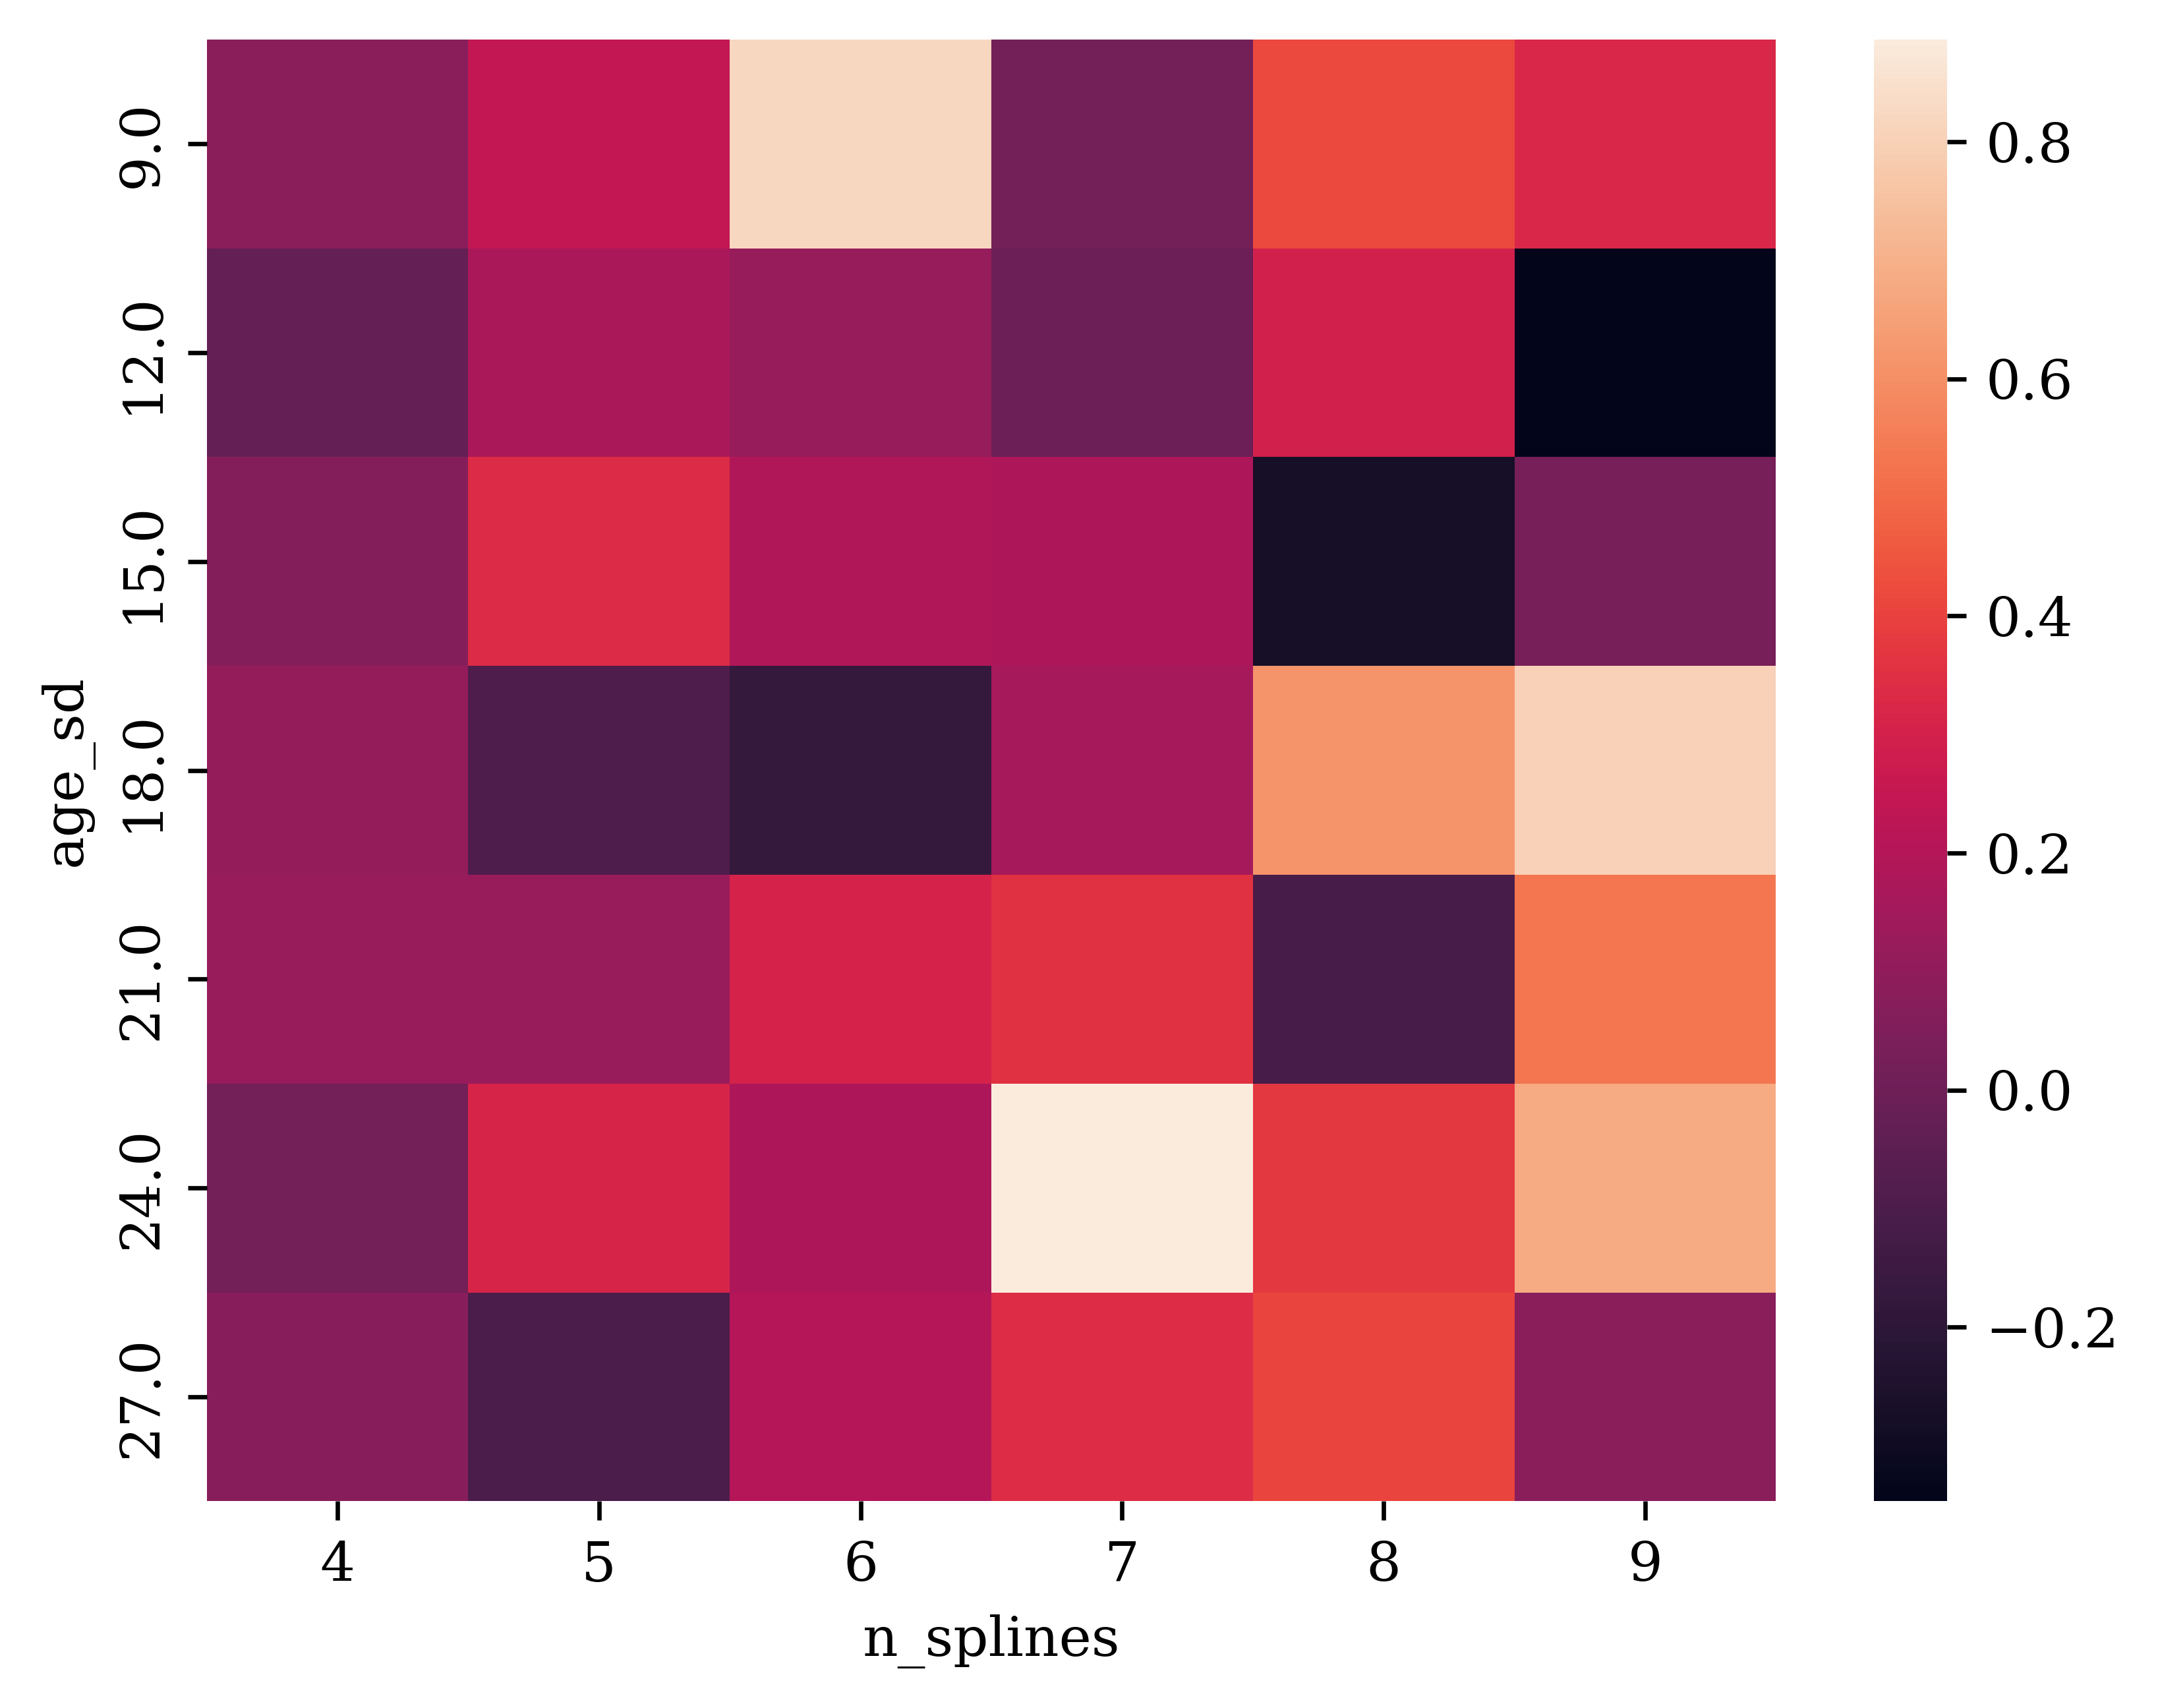

In [112]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='age_sd', values='heldout_full_r2'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

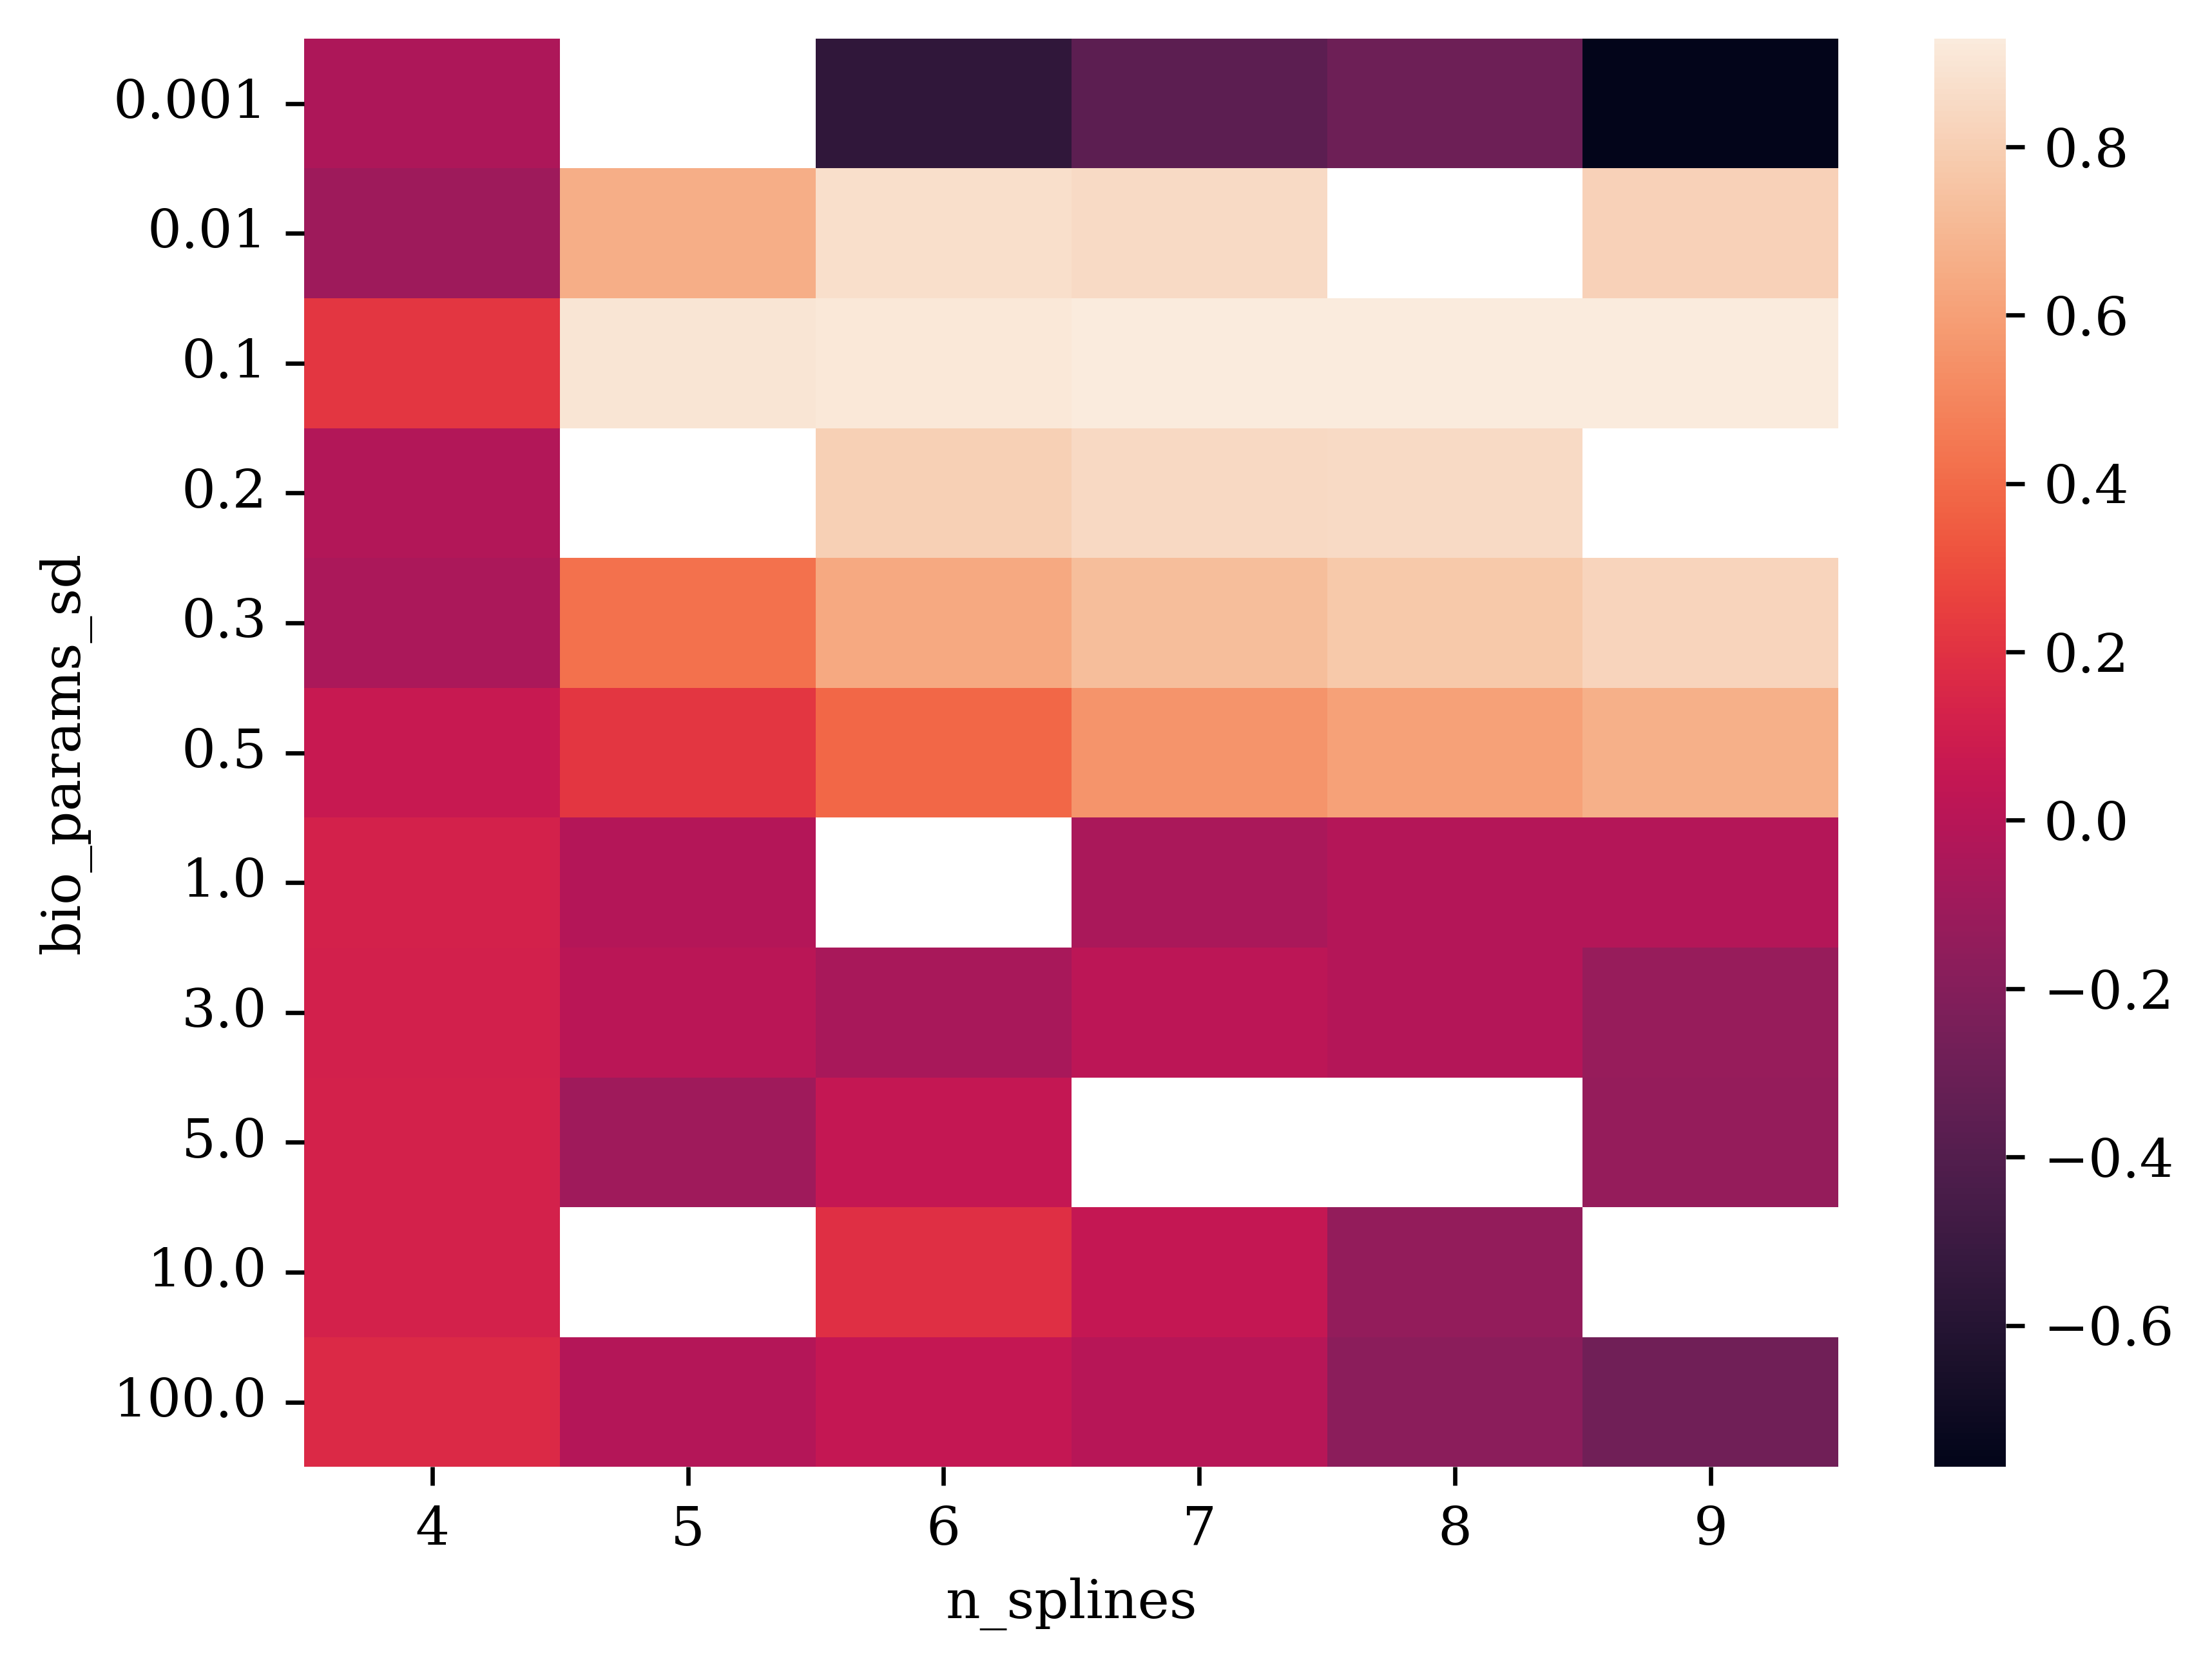

In [113]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='bio_params_sd', values='heldout_full_r2'))

<Axes: xlabel='n_splines', ylabel='bio_params_sd'>

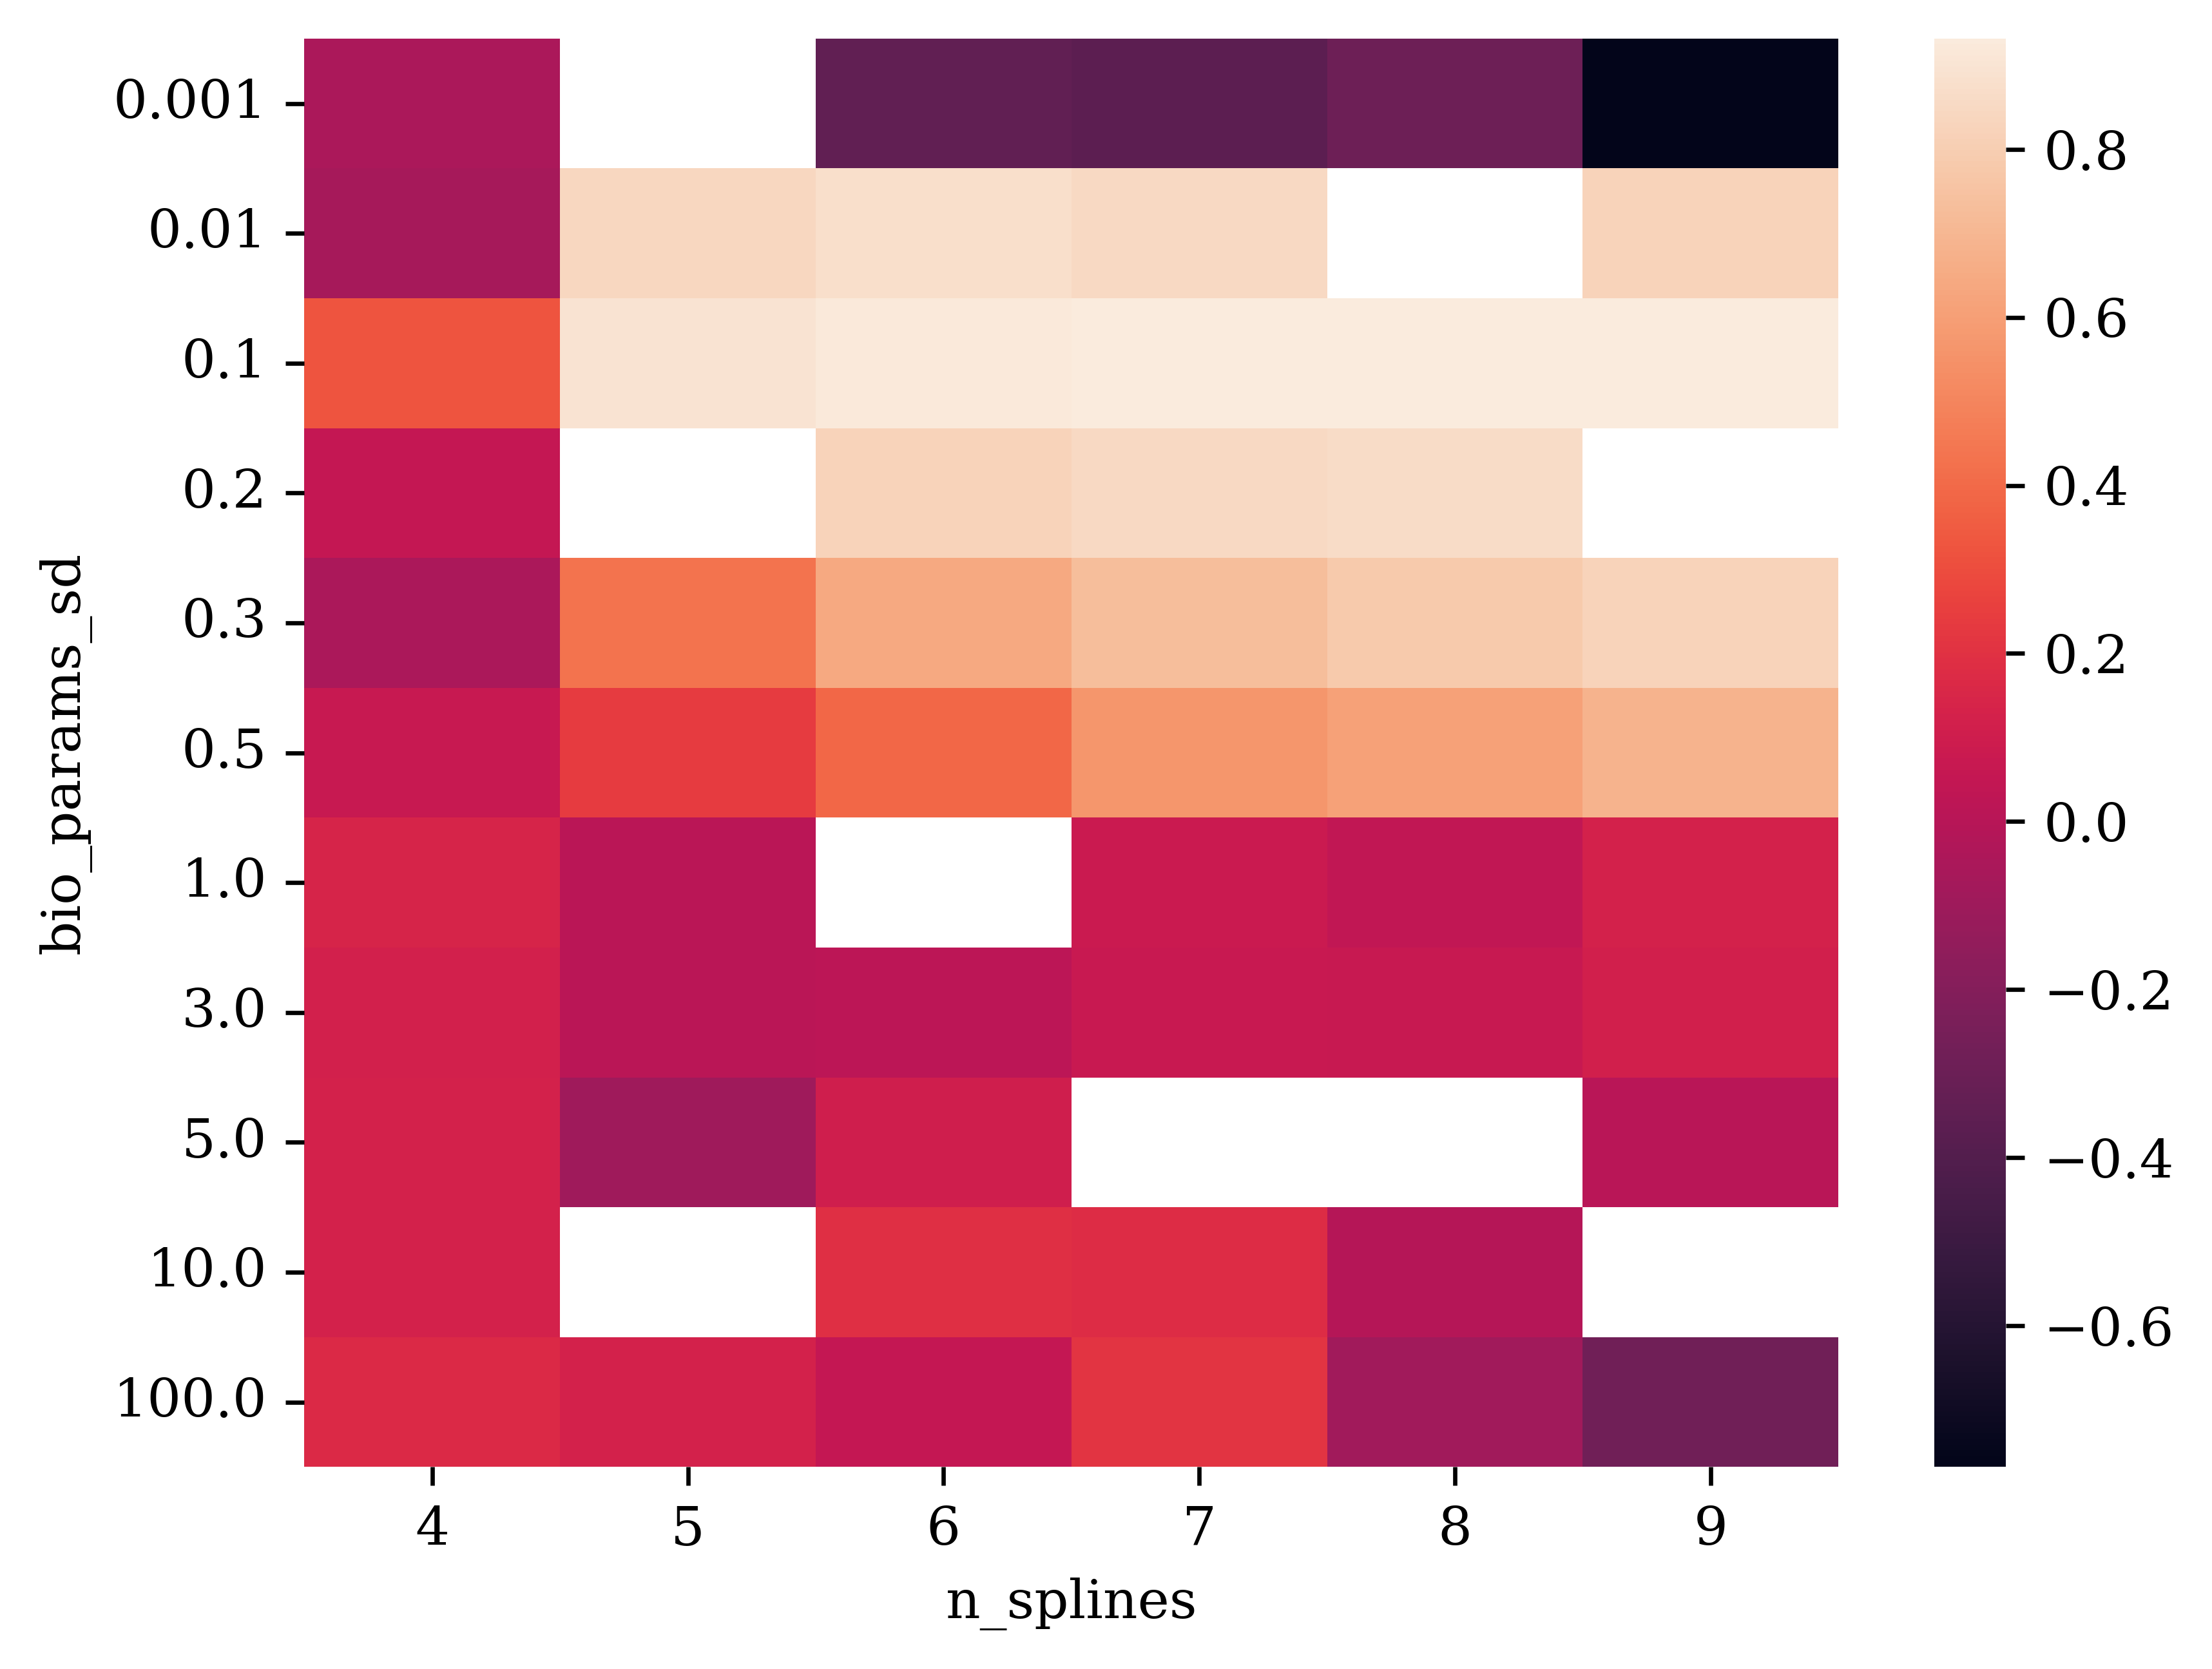

In [114]:
sns.heatmap(pd.pivot_table(r2_outs, columns='n_splines', index='bio_params_sd', values='heldout_full_r2', aggfunc='max'))

In [115]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='bio_params_sd', values='heldout_full_r2'))

<Axes: xlabel='age_sd', ylabel='bio_params_sd'>

In [116]:
ax = pd.pivot_table(r2_outs.query('age_sd == 12'), columns='n_splines', index='bio_params_sd', values='heldout_bambi_ll')[5].plot()
ax.set(xscale='log')

[None]

In [117]:
ax = pd.pivot_table(r2_outs.query('age_sd == 12'), columns='n_splines', index='bio_params_sd', values='heldout_bambi_ll').loc[[0.1, 1]].T.plot()

[None]

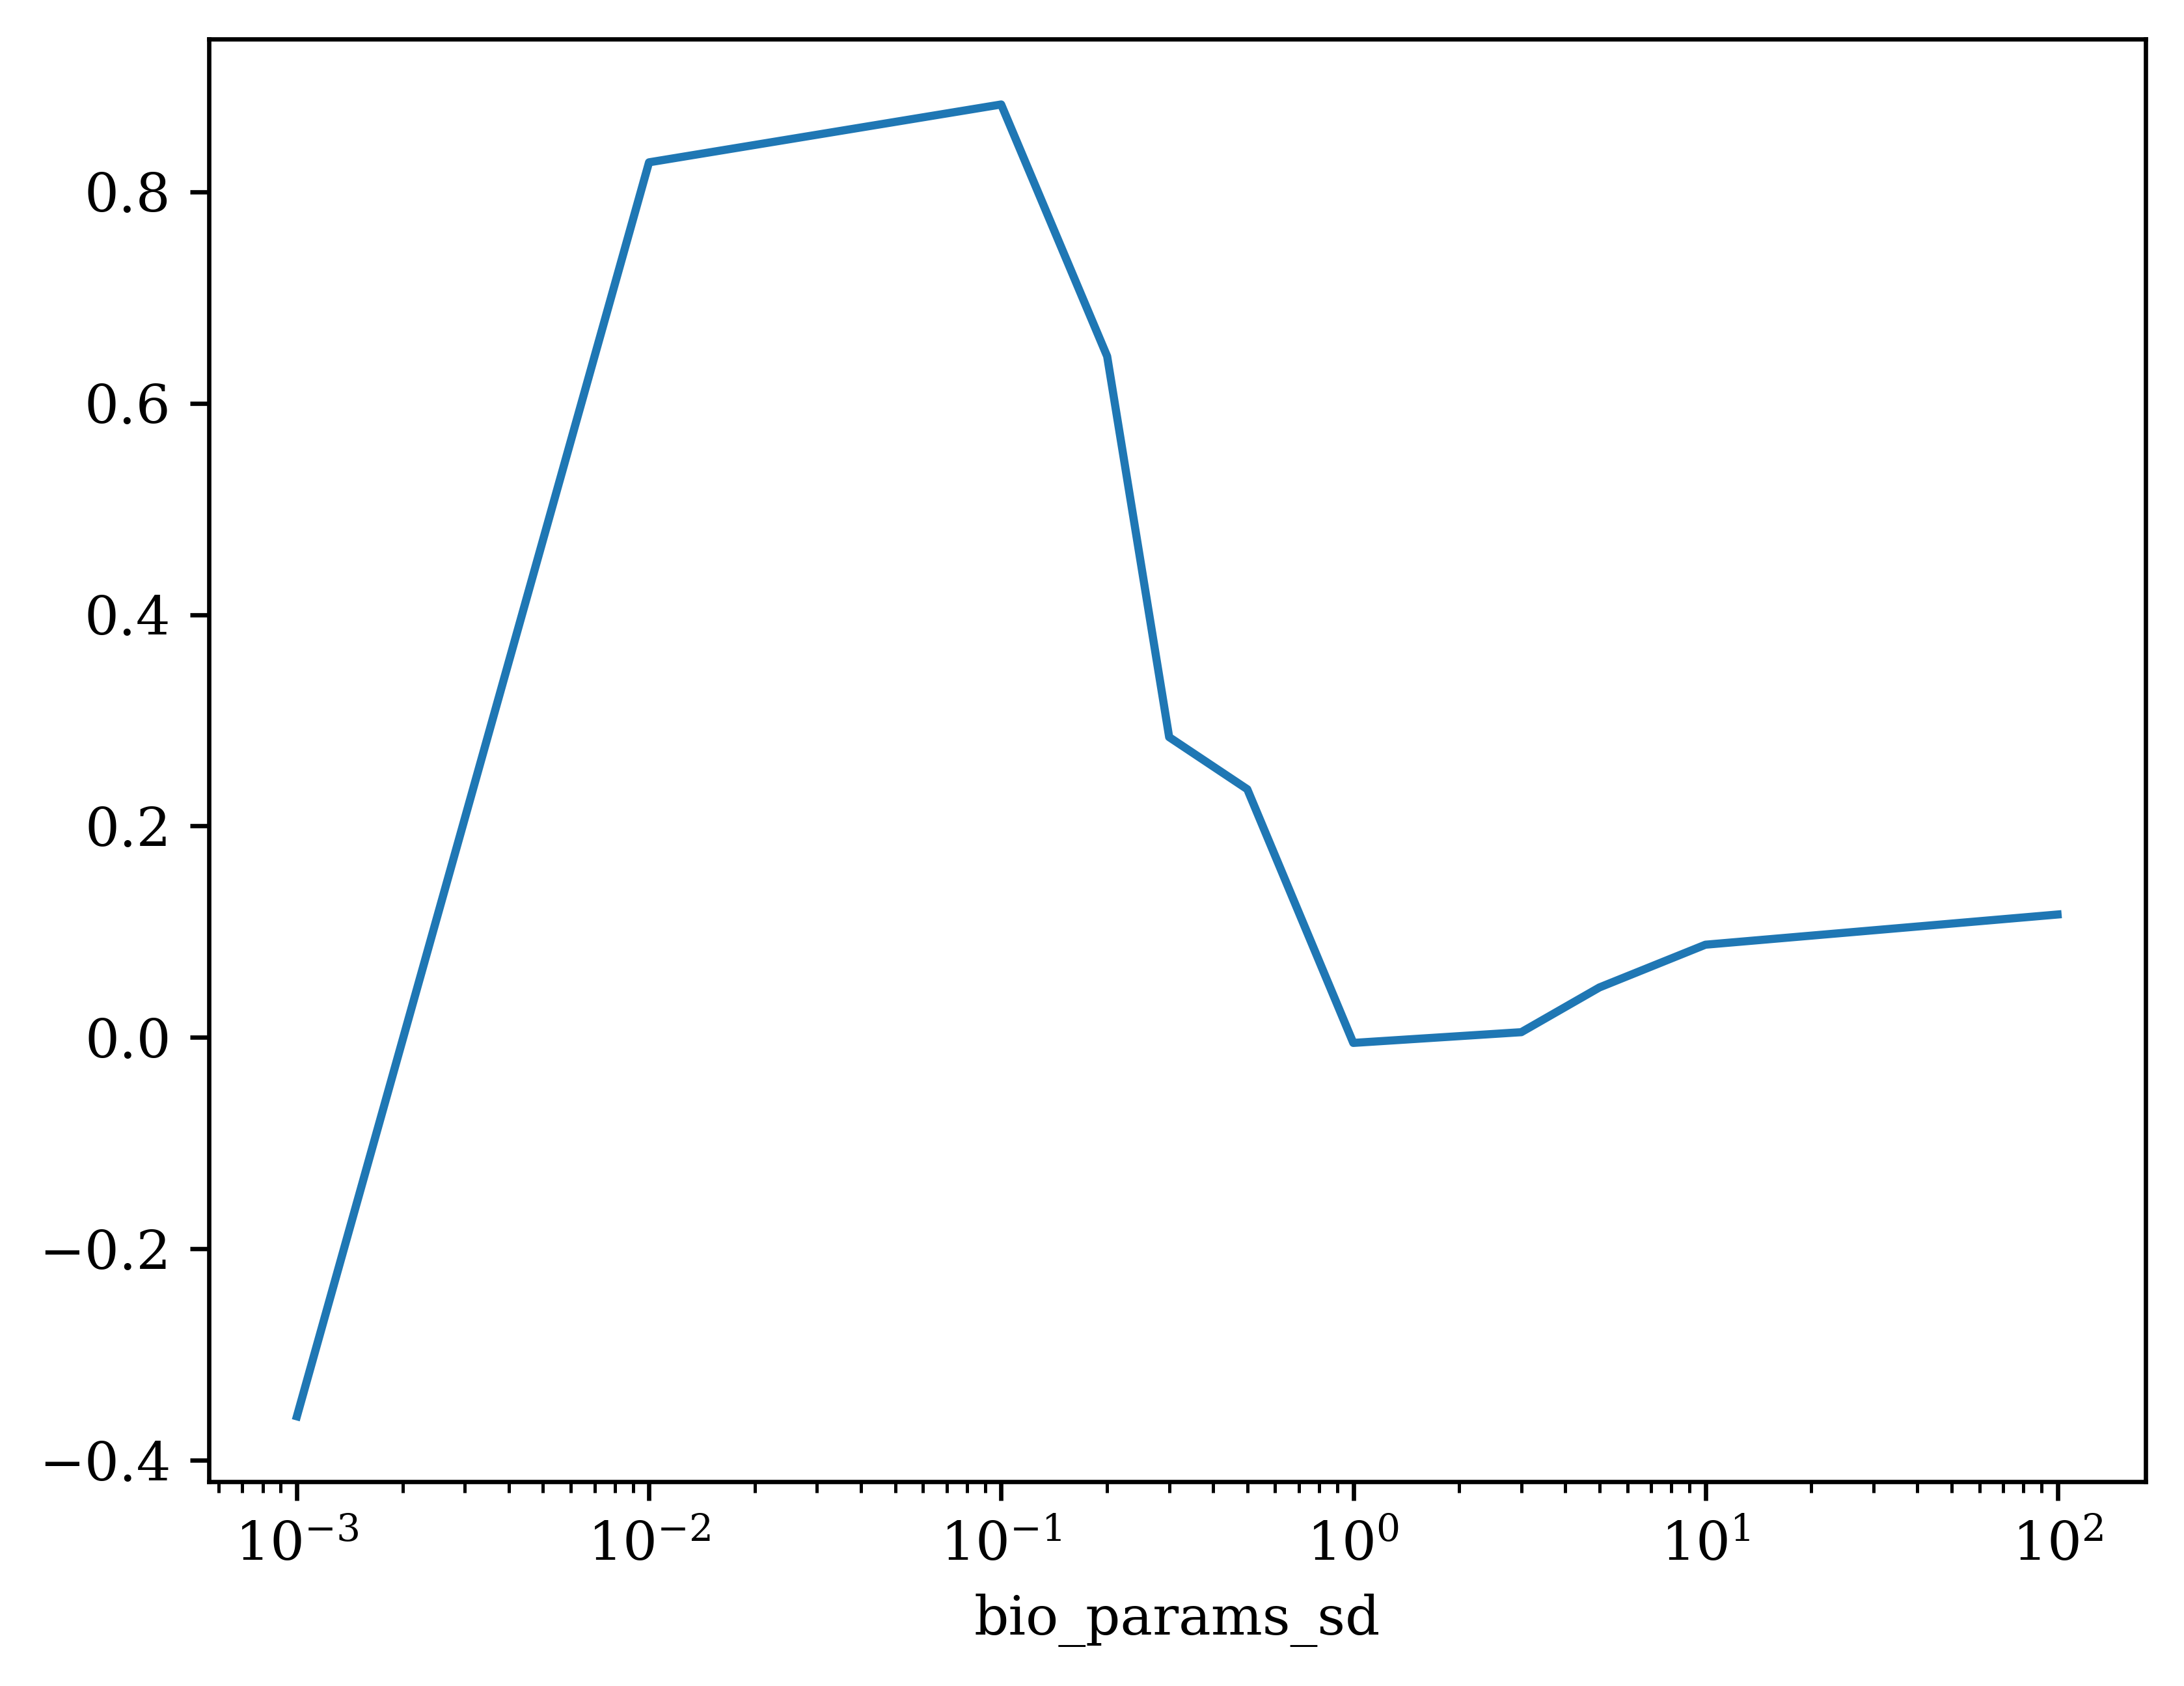

In [77]:
ax = pd.pivot_table(r2_outs.query('age_sd == 12'), columns='n_splines', index='bio_params_sd', values='heldout_full_r2')[5].plot()
ax.set(xscale='log')

<Axes: xlabel='age_sd', ylabel='bio_params_sd'>

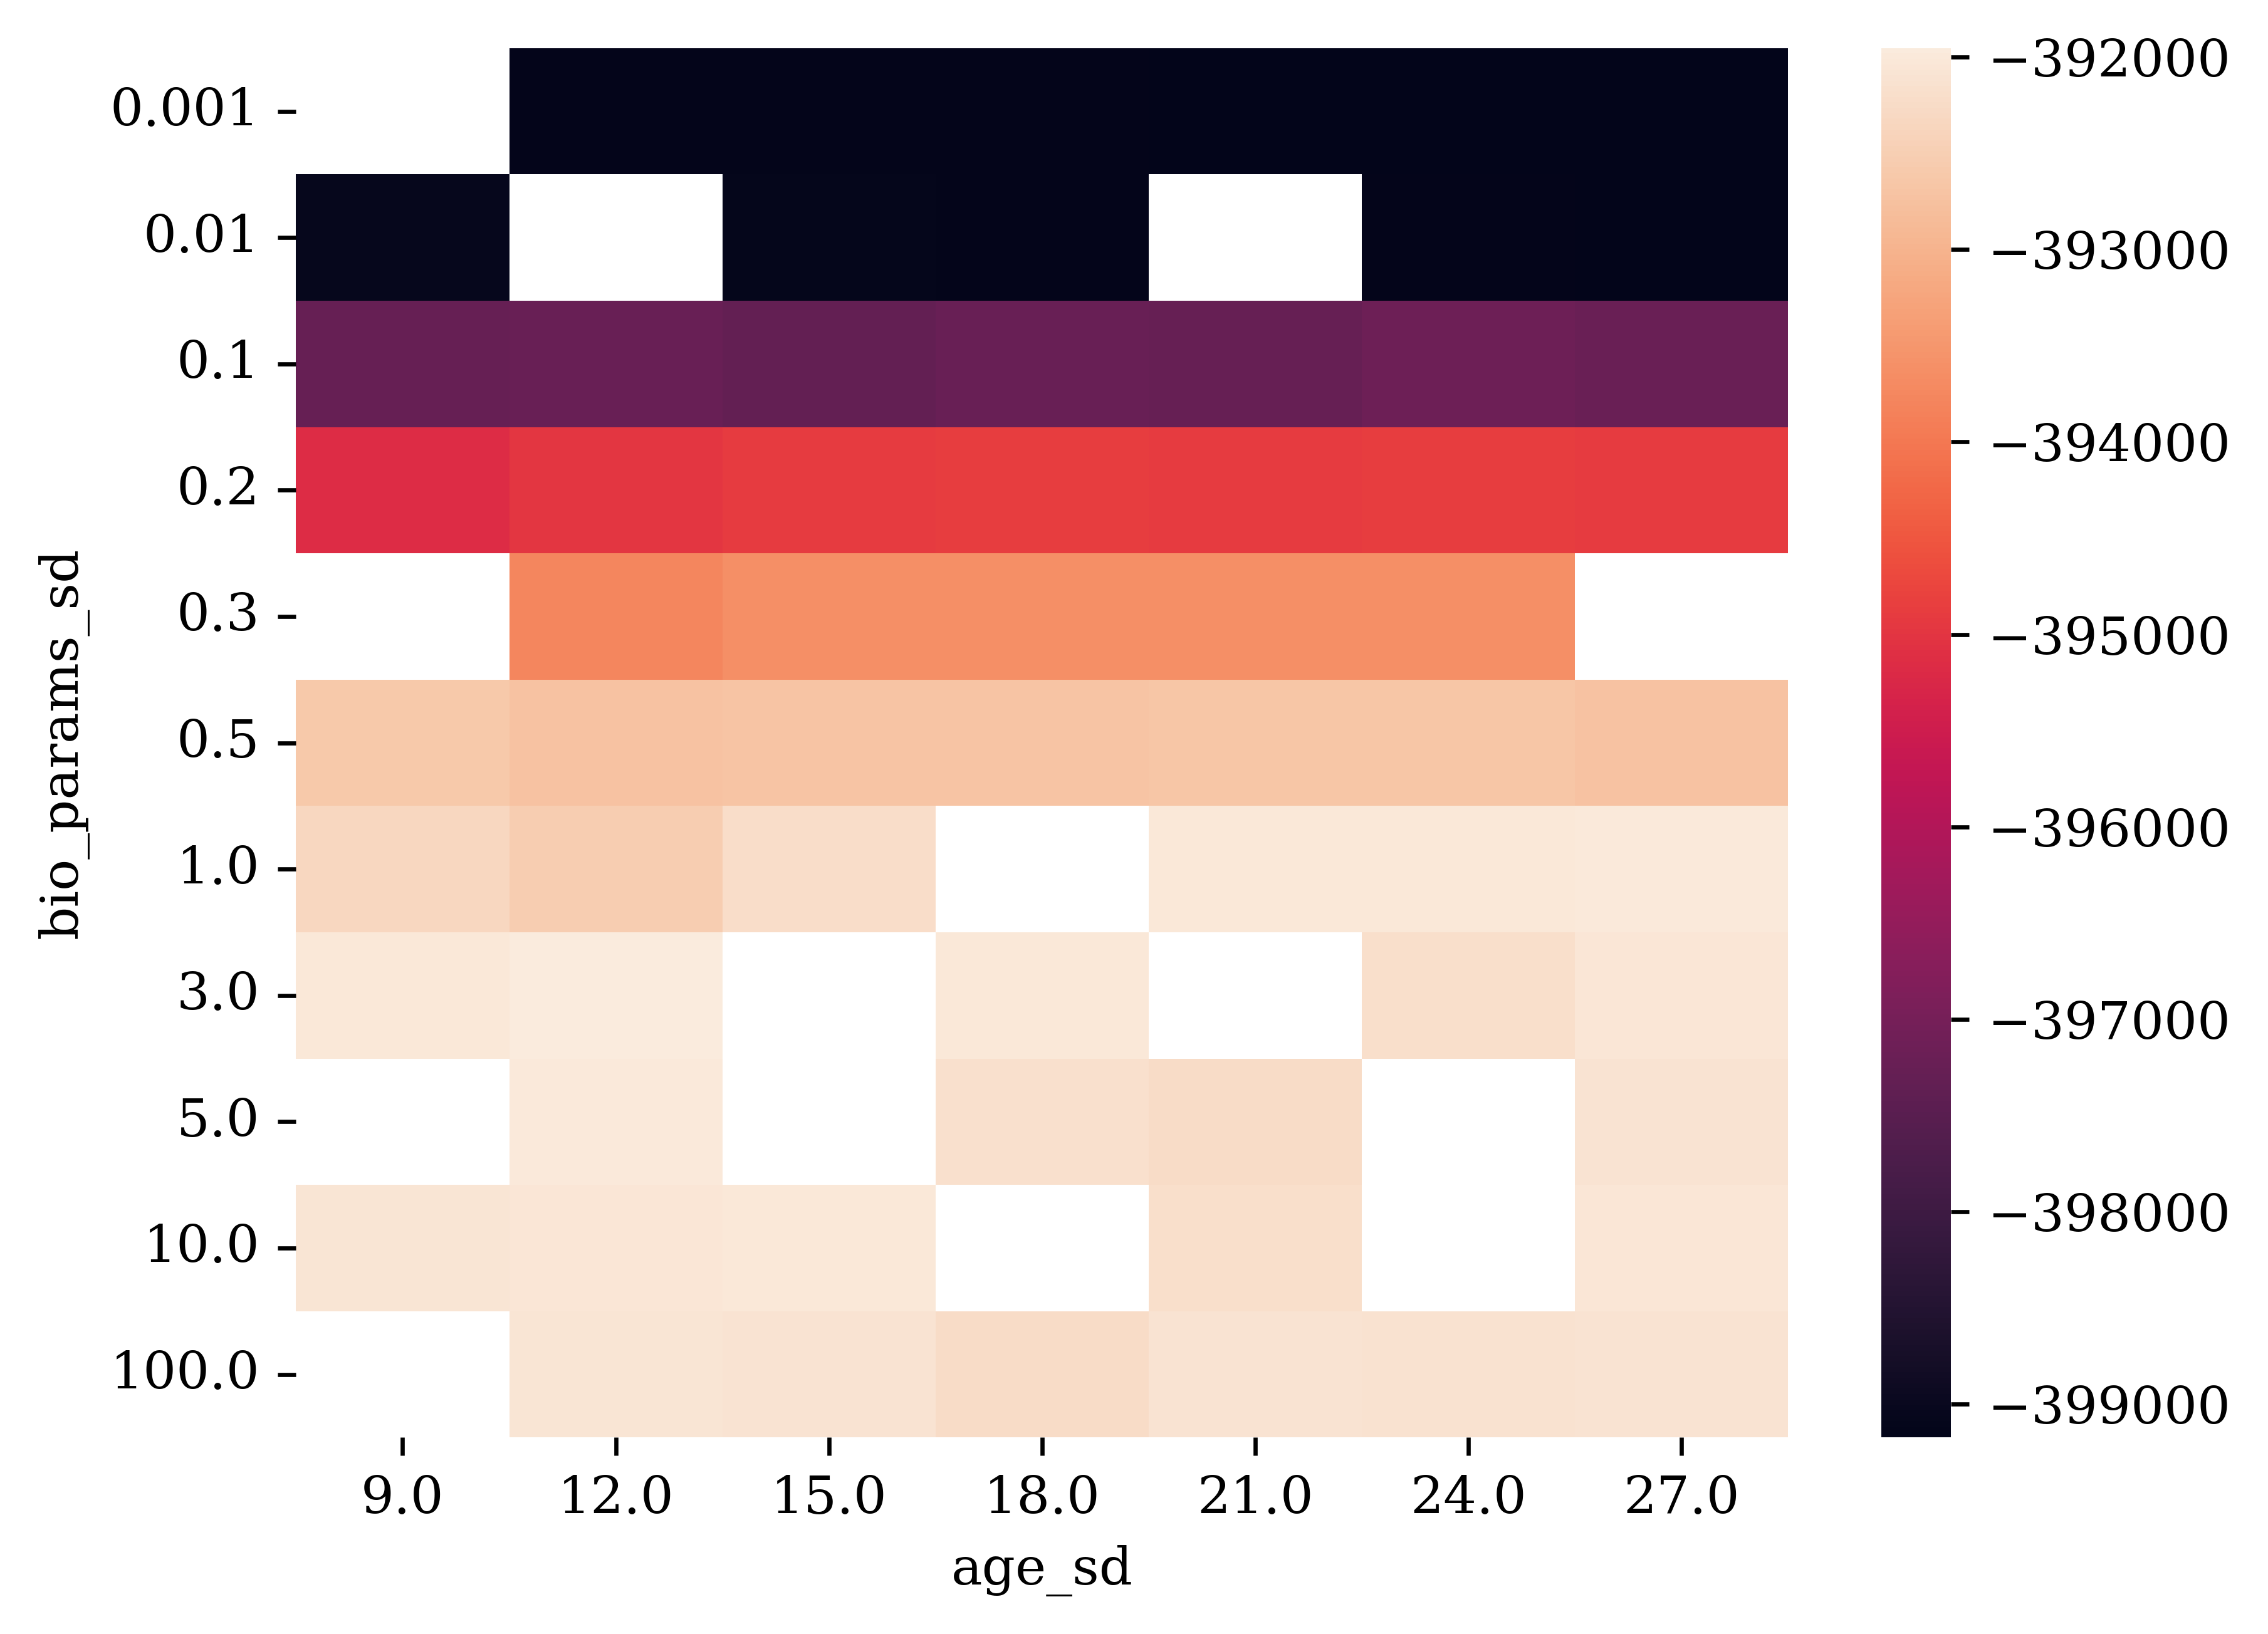

In [118]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='bio_params_sd', values='heldout_bambi_ll'))

In [119]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='n_splines', values='heldout_bambi_ll'))

<Axes: xlabel='age_sd', ylabel='n_splines'>

In [120]:
sns.heatmap(pd.pivot_table(r2_outs, columns='bio_params_sd', index='n_splines', values='heldout_bambi_ll'))

<Axes: xlabel='bio_params_sd', ylabel='n_splines'>

In [121]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='n_splines', values='heldout_bambi_ll', aggfunc='max'))

<Axes: xlabel='age_sd', ylabel='n_splines'>

In [122]:
ax = r2_outs.query('age_sd == 9 & n_splines == 9').set_index('bio_params_sd').sort_index()['heldout_bambi_ll'].plot()
ax.set(xscale='log')

[None]

In [123]:
idxmax = r2_outs['heldout_bambi_ll'].idxmax()

In [124]:
r2_outs.loc[idxmax]

age_sd                   9.000000
bio_params_sd            3.000000
n_splines                9.000000
heldout_r2               0.875012
param_norm               6.337508
heldout_full_r2         -0.006732
heldout_bambi_ll   -391871.750000
heldout_bambi_r2         0.570221
Name: 29, dtype: float64

In [125]:
idxmax = r2_outs.query('bio_params_sd < 1')['heldout_bambi_ll'].idxmax()

In [126]:
r2_outs.loc[idxmax]

age_sd                  24.000000
bio_params_sd            0.500000
n_splines                5.000000
heldout_r2               0.638432
param_norm               2.626498
heldout_full_r2          0.192166
heldout_bambi_ll   -392600.750000
heldout_bambi_r2         0.503808
Name: 20, dtype: float64

In [127]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='n_splines', values='heldout_bambi_r2'))

<Axes: xlabel='age_sd', ylabel='n_splines'>

In [128]:
sns.heatmap(pd.pivot_table(r2_outs, columns='age_sd', index='bio_params_sd', values='heldout_bambi_r2'))

<Axes: xlabel='age_sd', ylabel='bio_params_sd'>

In [134]:
f = r2_outs.query('heldout_bambi_r2 > 0.3')
f

age_sd  bio_params_sd  n_splines  heldout_r2  param_norm  \
0      15.0           10.0          8    0.835398    6.443750   
1      27.0            5.0          9    0.788349    6.553155   
4      27.0            3.0          9    0.757198    6.334558   
5      15.0          100.0          5    0.741406    5.281109   
6      24.0          100.0          6    0.789403    5.415030   
..      ...            ...        ...         ...         ...   
106    27.0            3.0          8    0.676246    5.827363   
107    24.0            0.2          4    0.746338    1.025765   
108    15.0            1.0          7    0.849305    4.306890   
109    24.0            3.0          6    0.719480    4.970345   
111     9.0            3.0          7    0.895835    5.496306   

     heldout_full_r2  heldout_bambi_ll  heldout_bambi_r2  
0          -0.276402        -391984.50          0.557366  
1           0.002414        -392092.50          0.560768  
4           0.109458        -392033.50          0.566294  
5           0.123959        -392289.00          0.526599  
6           0.051393        -392112.25          0.551234  
..               ...               ...               ...  
106         0.066978        -392071.50          0.557469  
107         0.033107        -394895.50          0.330309  
108        -0.262338        -391948.50          0.547636  
109         0.016817        -392078.75          0.551297  
111         0.023839        -392033.00          0.552656  

[75 rows x 8 columns]

In [135]:
f['heldout_full_r2'].hist()

<Axes: >

## Analyze bambi performance ONLY

In [77]:
files = sorted(Path('/n/scratch/users/w/wg41/bio-age-model').glob('ontogeny-high-resolution*.p'))

In [78]:
outs = []
for f in tqdm(files):
    tmp = joblib.load(f)
    heldout_ll = list(
        pluck("heldout_ll", keyfilter(lambda k: isinstance(k, int), tmp).values())
    )
    heldout_ll = np.mean(heldout_ll)
    heldout_r2 = list(
        pluck(
            "heldout_r2_total_v3", keyfilter(lambda k: isinstance(k, int), tmp).values()
        )
    )
    heldout_r2 = np.mean(heldout_r2)
    param_norm = np.mean(
        [
            np.linalg.norm(v["params"]["bio_basis_weights"], axis=1).mean()
            for v in keyfilter(lambda k: isinstance(k, int), tmp).values()
        ]
    )
    outs.append(
        {
            **tmp["grid_params"],
            "param_norm": param_norm,
            "heldout_bambi_ll": heldout_ll,
            "heldout_bambi_r2": heldout_r2,
        }
    )
outs = pd.DataFrame(outs)

  0%|          | 0/462 [00:00<?, ?it/s]

In [87]:
sns.heatmap(pd.pivot_table(outs, columns='age_sd', index='bio_params_sd', values='heldout_bambi_r2', aggfunc='max'), cbar_kws=dict(label="Heldout r2"))

<Axes: xlabel='age_sd', ylabel='bio_params_sd'>

In [86]:
sns.heatmap(pd.pivot_table(outs, columns='age_sd', index='bio_params_sd', values='param_norm'), cbar_kws=dict(label="Param norm"))

<Axes: xlabel='age_sd', ylabel='bio_params_sd'>

[None, Text(0, 0.5, 'Param norm')]

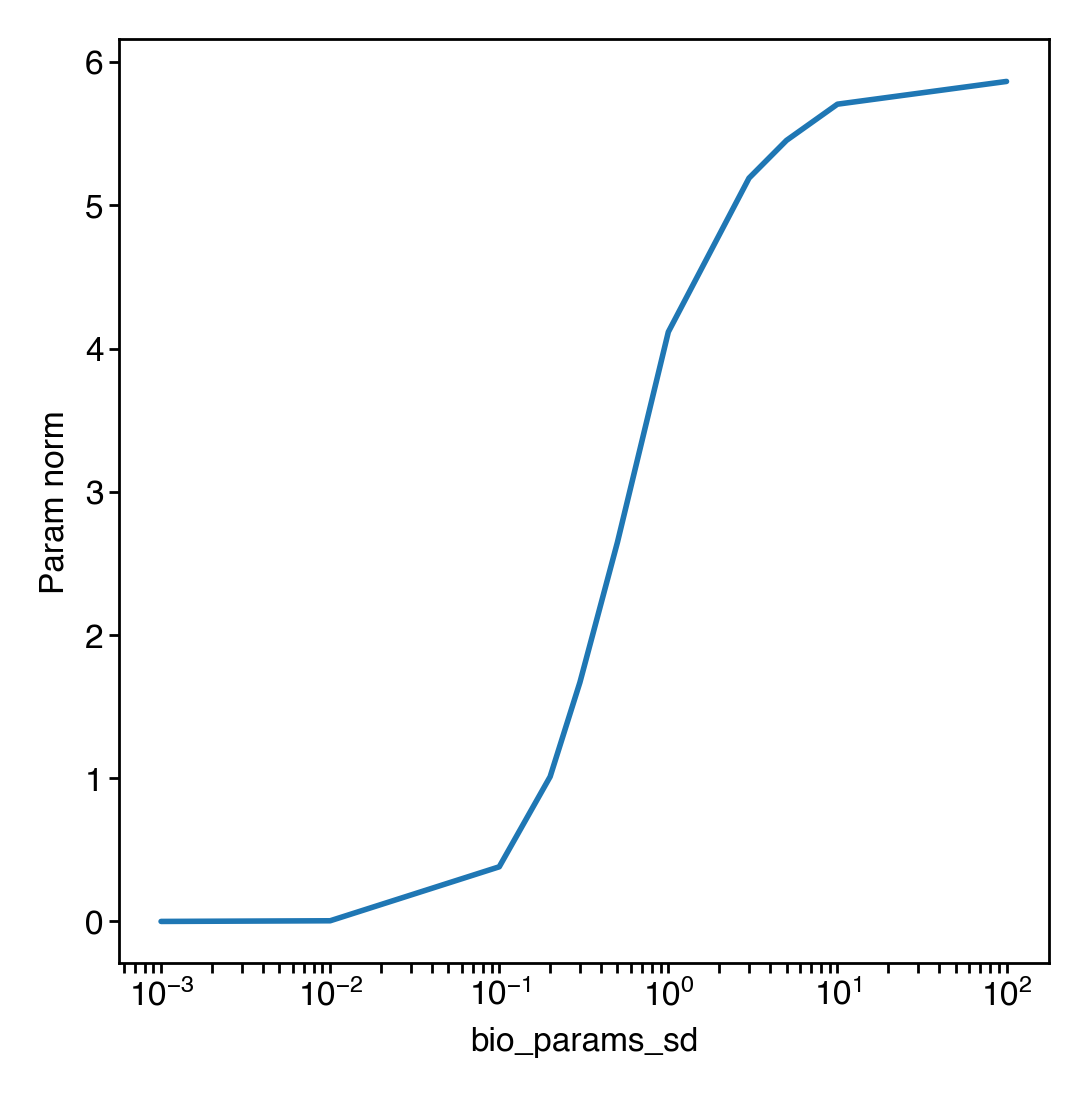

In [88]:
ax = outs.groupby('bio_params_sd')['param_norm'].mean().plot()
ax.set(xscale='log', ylabel='Param norm')

[None, Text(0, 0.5, 'Heldout r2')]

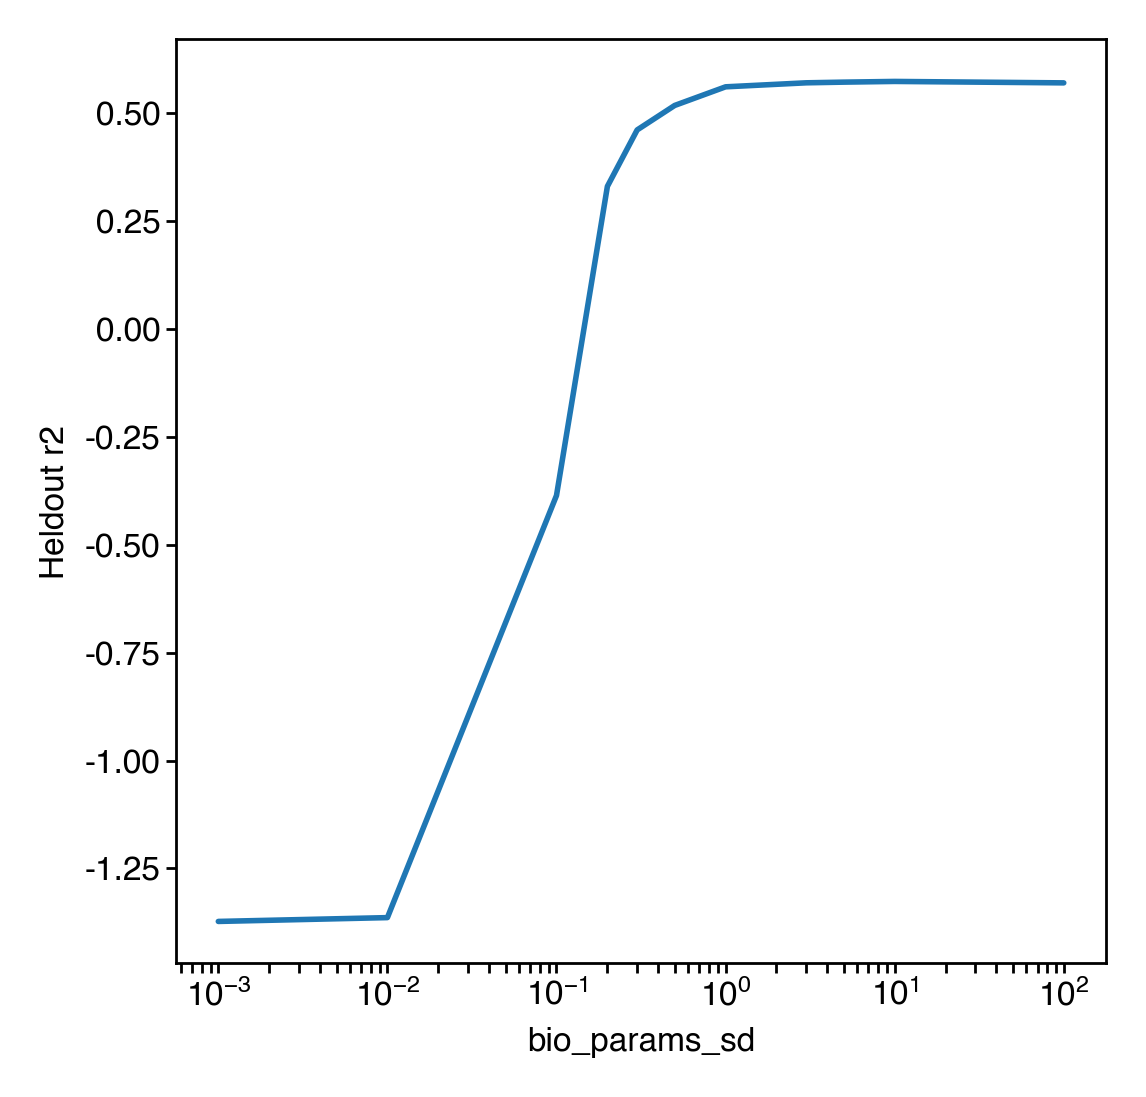

In [91]:
ax = outs.groupby('bio_params_sd')['heldout_bambi_r2'].max().plot()
ax.set(xscale='log', ylabel='Heldout r2')

[None, Text(0, 0.5, 'Heldout r2')]

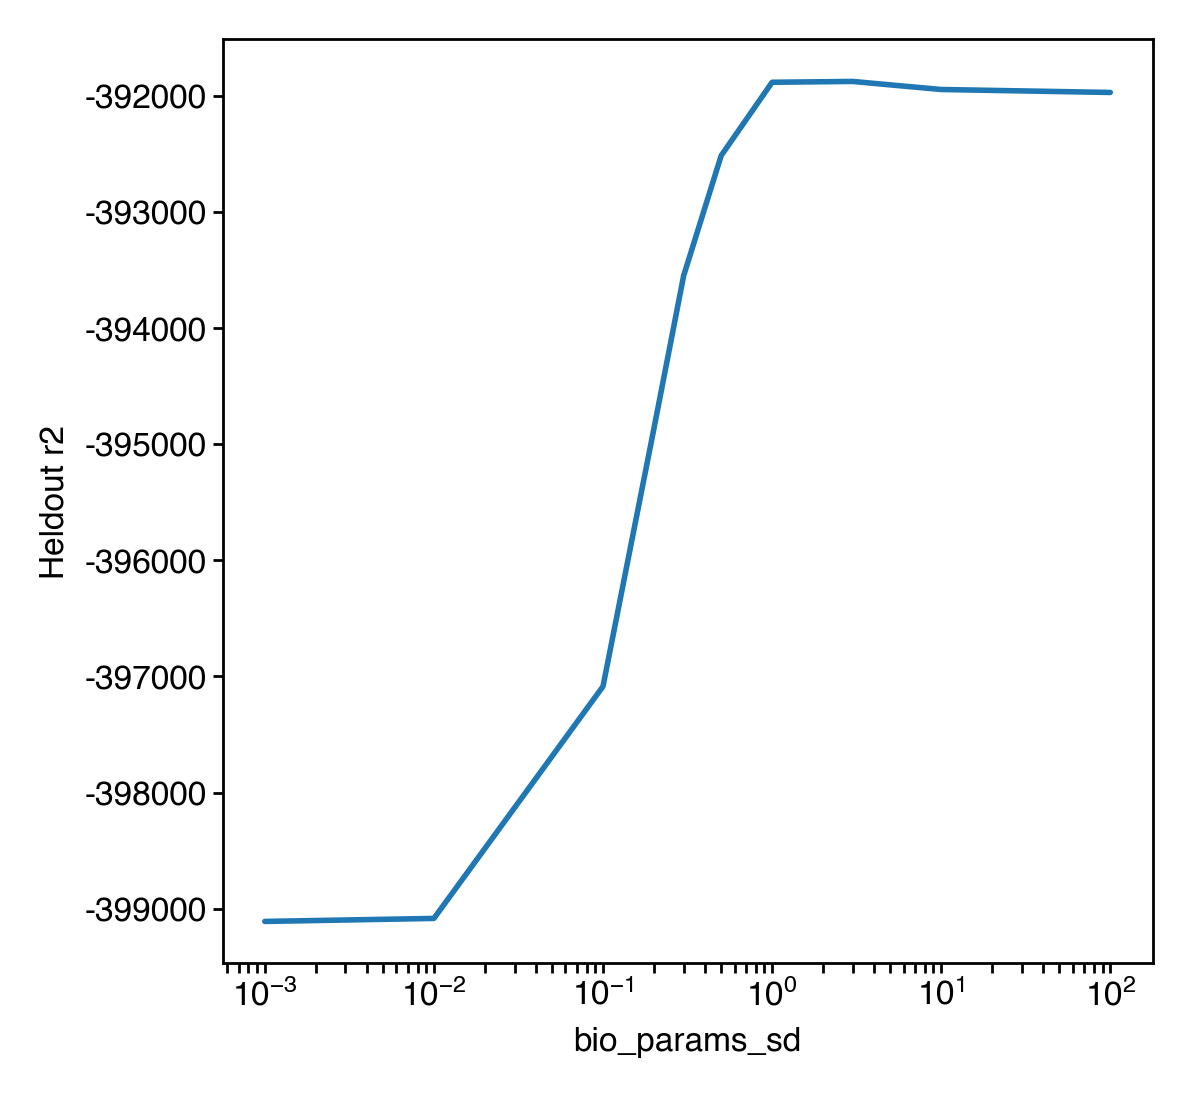

In [92]:
ax = outs.groupby('bio_params_sd')['heldout_bambi_ll'].max().plot()
ax.set(xscale='log', ylabel='Heldout r2')

[None, Text(0, 0.5, 'Heldout r2')]

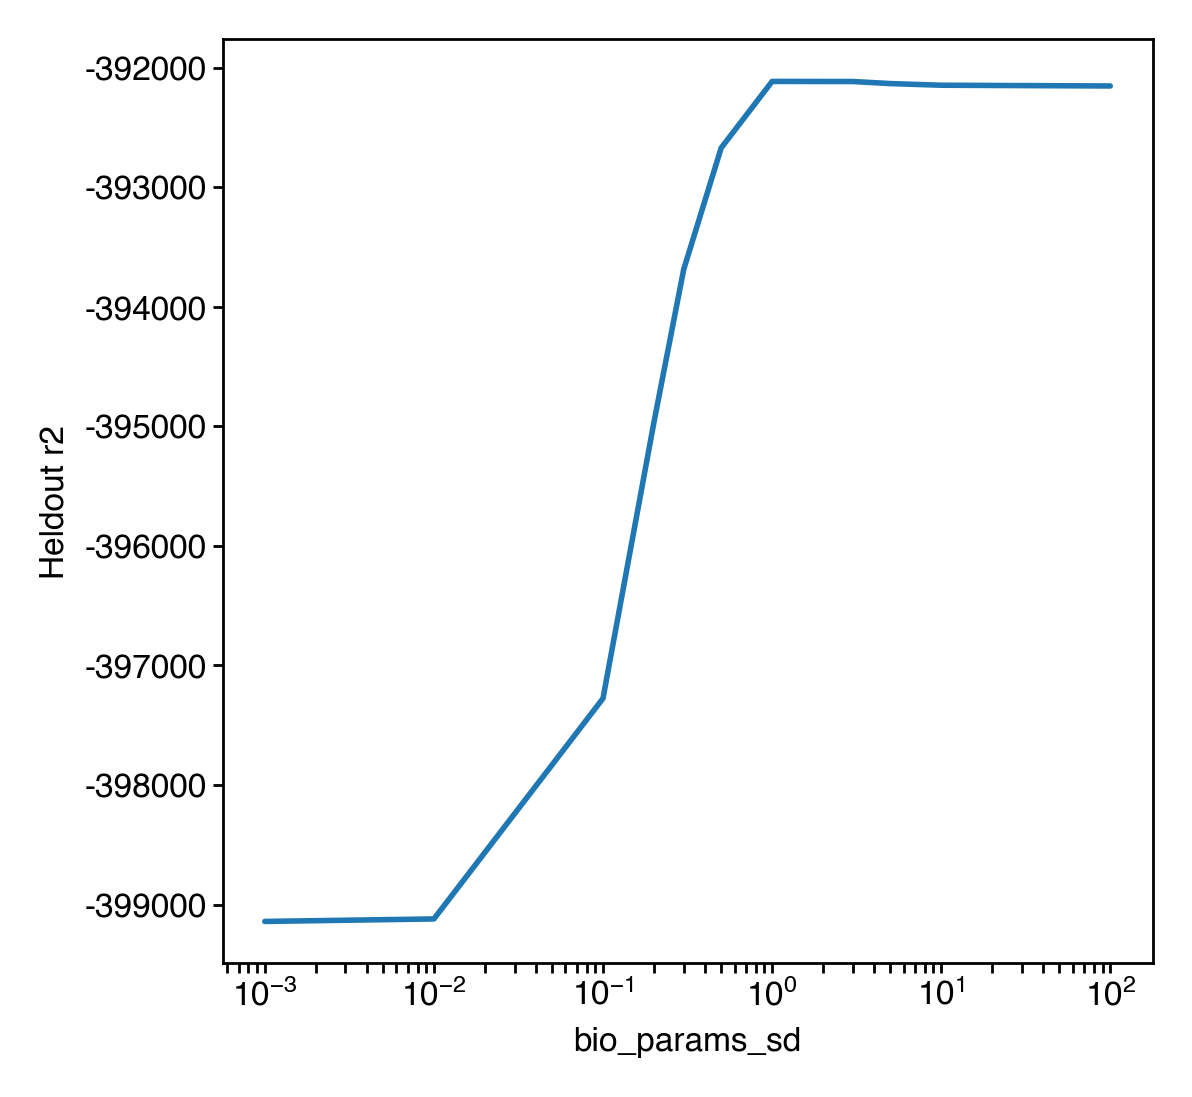

In [93]:
ax = outs.groupby('bio_params_sd')['heldout_bambi_ll'].mean().plot()
ax.set(xscale='log', ylabel='Heldout r2')

In [95]:
outs.groupby('bio_params_sd')['heldout_bambi_ll'].mean().idxmax()

1.0

In [96]:
outs.groupby('bio_params_sd')['heldout_bambi_ll'].max().idxmax()

3.0

In [97]:
outs.query('bio_params_sd == 1')

age_sd  bio_params_sd  n_splines  param_norm  heldout_bambi_ll  \
13     15.0            1.0          4    3.327409        -392440.25   
25     27.0            1.0          9    4.832551        -391998.25   
31      9.0            1.0          7    4.304104        -392017.75   
36     27.0            1.0          8    4.614047        -391999.75   
41     21.0            1.0          5    3.688196        -392177.75   
49     15.0            1.0          5    3.692313        -392250.50   
72      9.0            1.0          4    3.294528        -392661.50   
73     21.0            1.0          8    4.554599        -391978.50   
82     24.0            1.0          8    4.661929        -392026.75   
87     21.0            1.0          9    4.780982        -391946.00   
96     12.0            1.0          4    3.305563        -392526.50   
98     27.0            1.0          7    4.368862        -392029.50   
108    15.0            1.0          7    4.306890        -391948.50   
118    18.0            1.0          5    3.674249        -392201.50   
123     9.0            1.0          6    4.075554        -392130.50   
124    12.0            1.0          8    4.504949        -391962.25   
164     9.0            1.0          8    4.510186        -392009.00   
168     9.0            1.0          5    3.812180        -392209.25   
183    18.0            1.0          6    4.012933        -392128.00   
187    12.0            1.0          9    4.643342        -391879.00   
223    24.0            1.0          9    4.852847        -391959.50   
230    18.0            1.0          7    4.276394        -392008.50   
236    18.0            1.0          4    3.332140        -392402.25   
255    15.0            1.0          9    4.702055        -391893.00   
266    21.0            1.0          7    4.370283        -392016.75   
285    24.0            1.0          7    4.360267        -392022.50   
298    24.0            1.0          4    3.337705        -392389.50   
317    24.0            1.0          5    3.695398        -392175.50   
320     9.0            1.0          9    4.693482        -391925.50   
321    12.0            1.0          6    4.135009        -392031.00   
328    15.0            1.0          6    4.037055        -392046.25   
347    18.0            1.0          8    4.481893        -391946.25   
352    15.0            1.0          8    4.502224        -391926.25   
357    12.0            1.0          5    3.658596        -392306.75   
376    27.0            1.0          5    3.695177        -392203.75   
387    27.0            1.0          4    3.335889        -392396.50   
405    21.0            1.0          6    4.074174        -392121.00   
413    27.0            1.0          6    4.054450        -392132.25   
429    21.0            1.0          4    3.332929        -392389.25   
450    18.0            1.0          9    4.689877        -391890.75   
453    12.0            1.0          7    4.264304        -391997.00   
457    24.0            1.0          6    4.046622        -392137.25   

     heldout_bambi_r2  
13           0.510648  
25           0.558815  
31           0.544687  
36           0.549746  
41           0.534730  
49           0.532012  
72           0.496986  
73           0.553018  
82           0.548606  
87           0.560925  
96           0.507931  
98           0.556655  
108          0.547636  
118          0.534500  
123          0.539469  
124          0.544467  
164          0.548417  
168          0.532358  
183          0.532126  
187          0.551776  
223          0.554188  
230          0.543638  
236          0.511329  
255          0.551833  
266          0.546974  
285          0.555119  
298          0.511880  
317          0.534817  
320          0.554605  
321          0.546490  
328          0.539868  
347          0.552024  
352          0.549596  
357          0.527622  
376          0.533369  
387          0.511843  
405          0.536822  
413          0.540942  
429          0.

<Axes: xlabel='age_sd', ylabel='n_splines'>

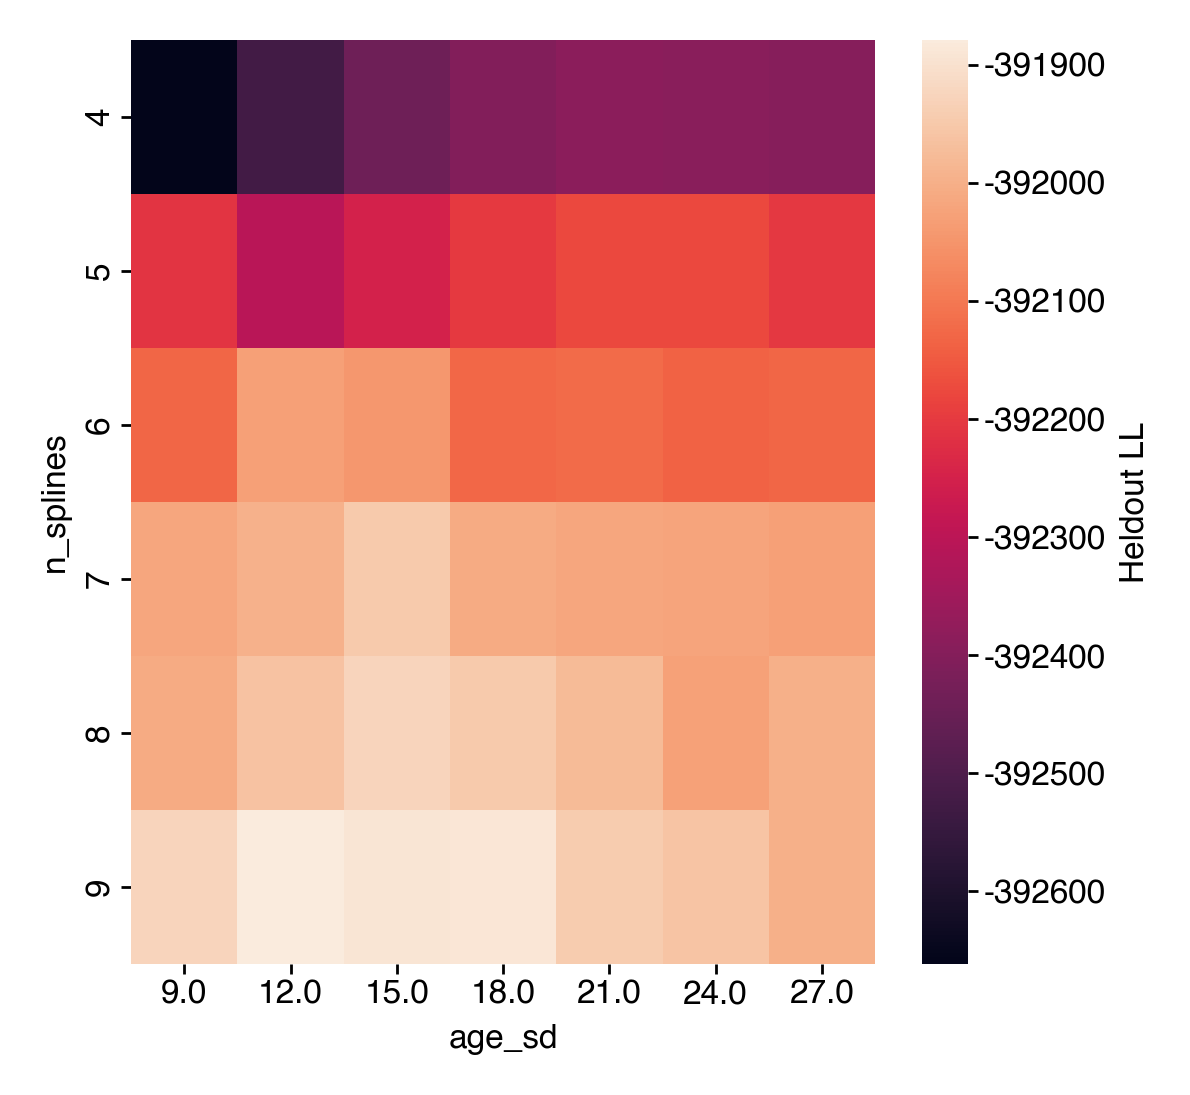

In [106]:
sns.heatmap(pd.pivot_table(outs.query('bio_params_sd == 1'), columns='age_sd', index='n_splines', values='heldout_bambi_ll', aggfunc='mean'), cbar_kws=dict(label="Heldout LL"))

<Axes: xlabel='age_sd', ylabel='n_splines'>

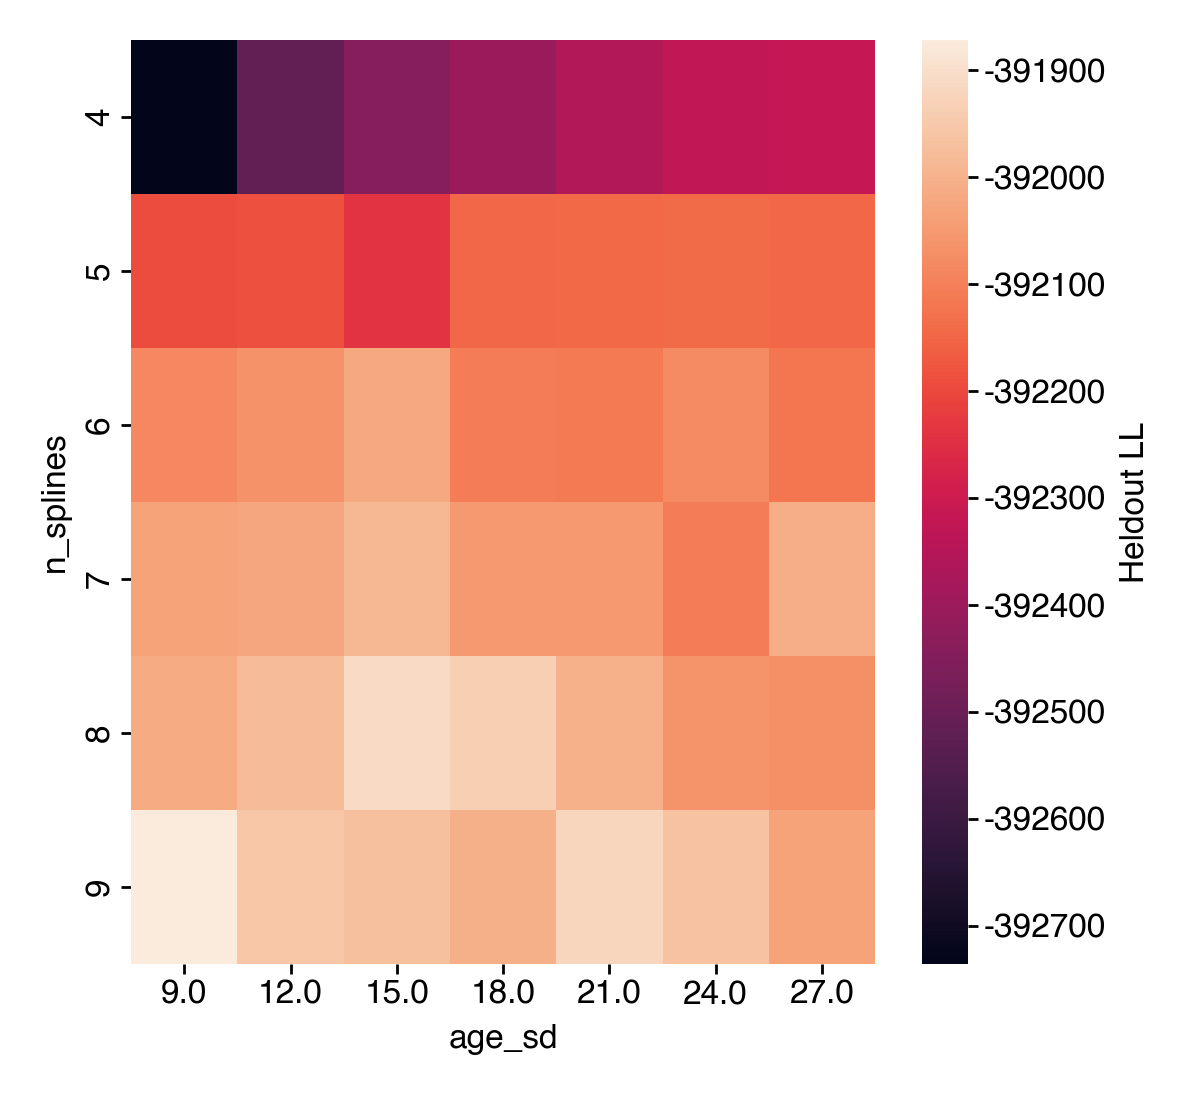

In [107]:
sns.heatmap(pd.pivot_table(outs.query('bio_params_sd == 3'), columns='age_sd', index='n_splines', values='heldout_bambi_ll', aggfunc='mean'), cbar_kws=dict(label="Heldout LL"))

In [104]:
outs.query('bio_params_sd == 1').set_index(['age_sd', 'n_splines'])['heldout_bambi_ll'].idxmax()

(12.0, 9)

In [105]:
outs.query('bio_params_sd == 3').set_index(['age_sd', 'n_splines'])['heldout_bambi_ll'].idxmax()

(9.0, 9)

In [109]:
outs.set_index(['age_sd', 'n_splines', 'bio_params_sd'])['heldout_bambi_ll'].idxmax()

(9.0, 9, 3.0)

In [149]:
# find a specific parameter set
param_set = dict(
    age_sd=9,
    n_splines=9,
    bio_params_sd=3,
)
for f in tqdm(files):
    tmp = joblib.load(f)
    matches = []
    for k, v in tmp['grid_params'].items():
        matches.append(param_set[k] == v)
    if all(matches):
        break

  0%|          | 0/462 [00:00<?, ?it/s]

In [113]:
tmp['grid_params']

{'age_sd': 9.0, 'bio_params_sd': 3, 'n_splines': 9}

In [114]:
list(tmp)

[0, 1, 2, 3, 'grid_params']

In [116]:
tmp[0]['predicted_counts'].shape

(351, 56)

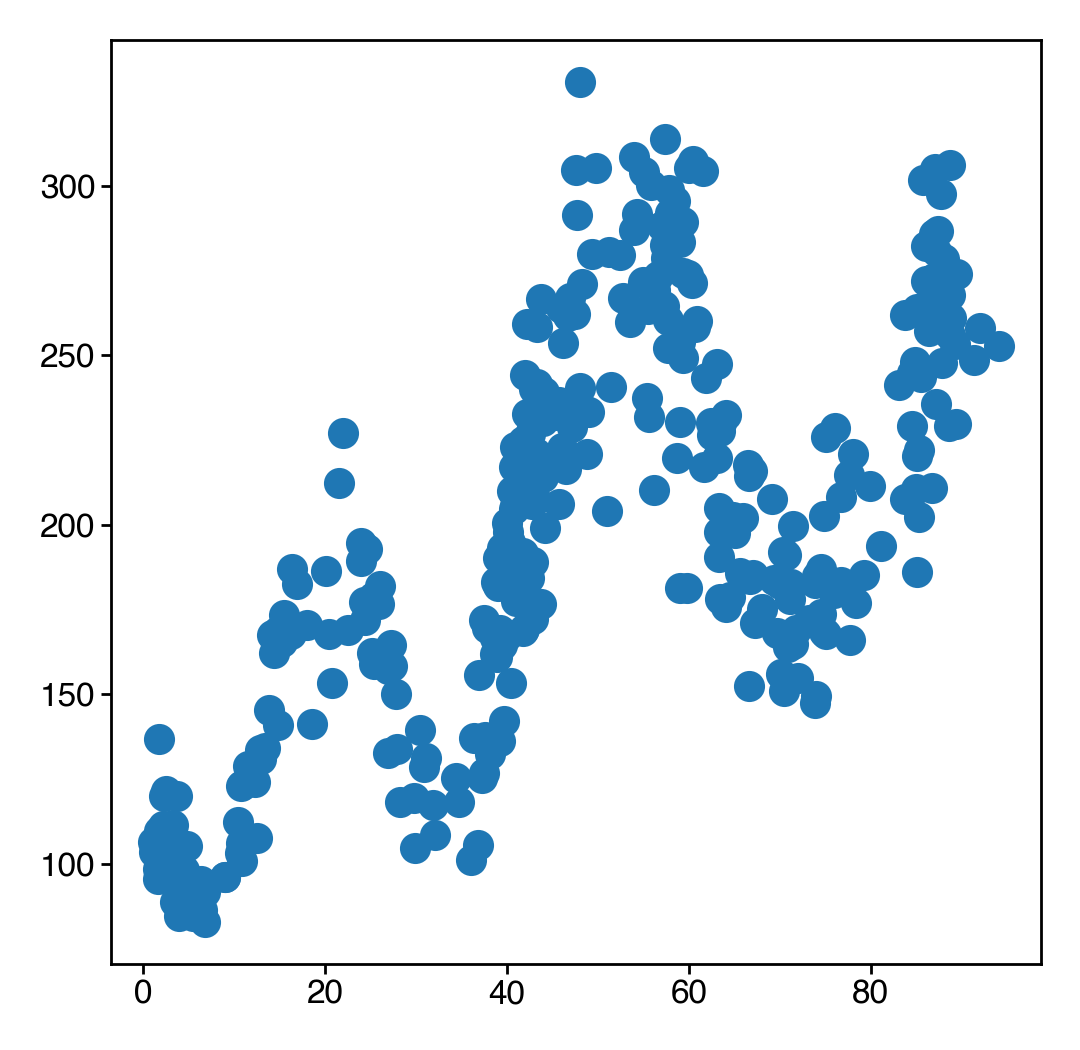

In [118]:
ba = tmp[0]['bio_ages']
ca = tmp[0]['true_ages']
c = tmp[0]['predicted_counts'][:, 0]
plt.scatter(ba, c)

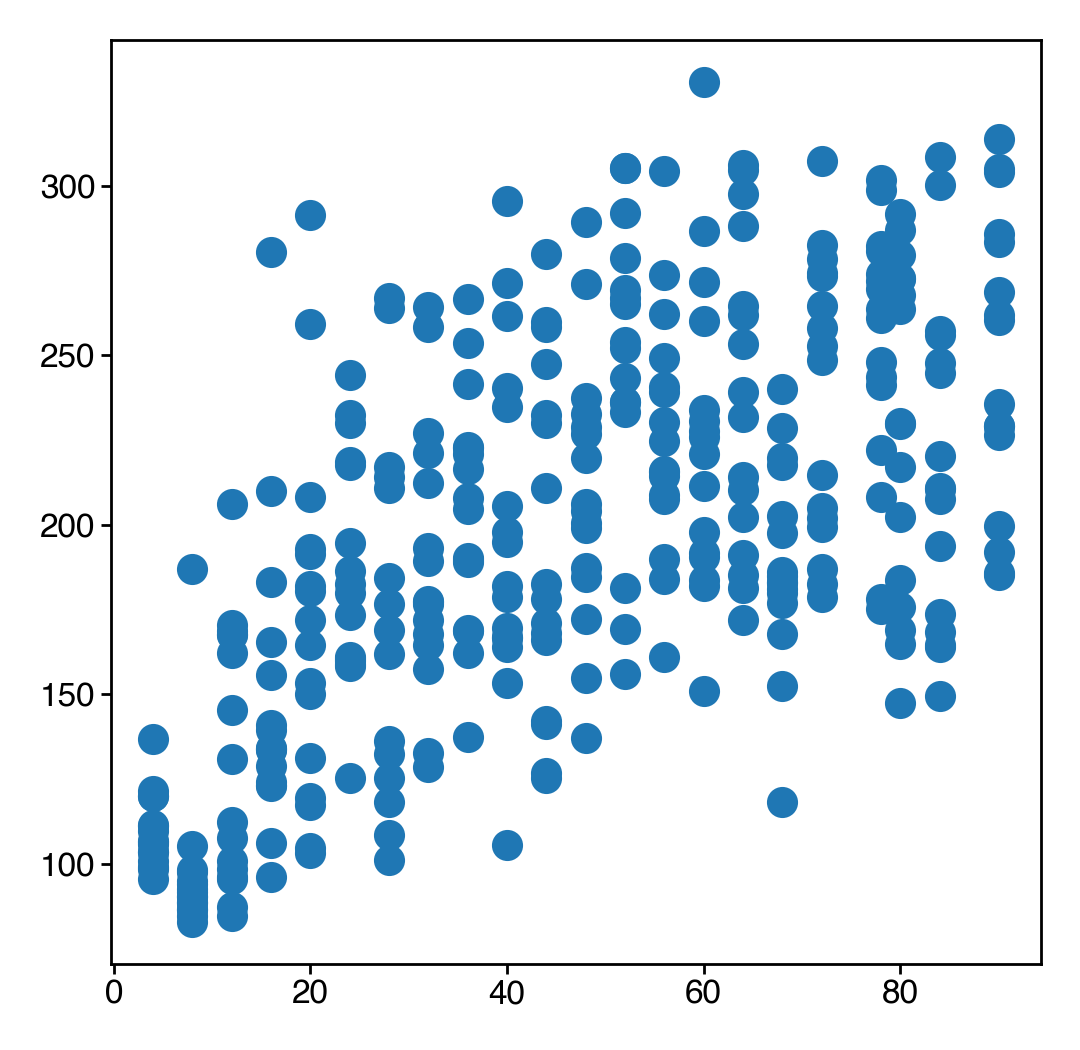

In [119]:
plt.scatter(ca, c)

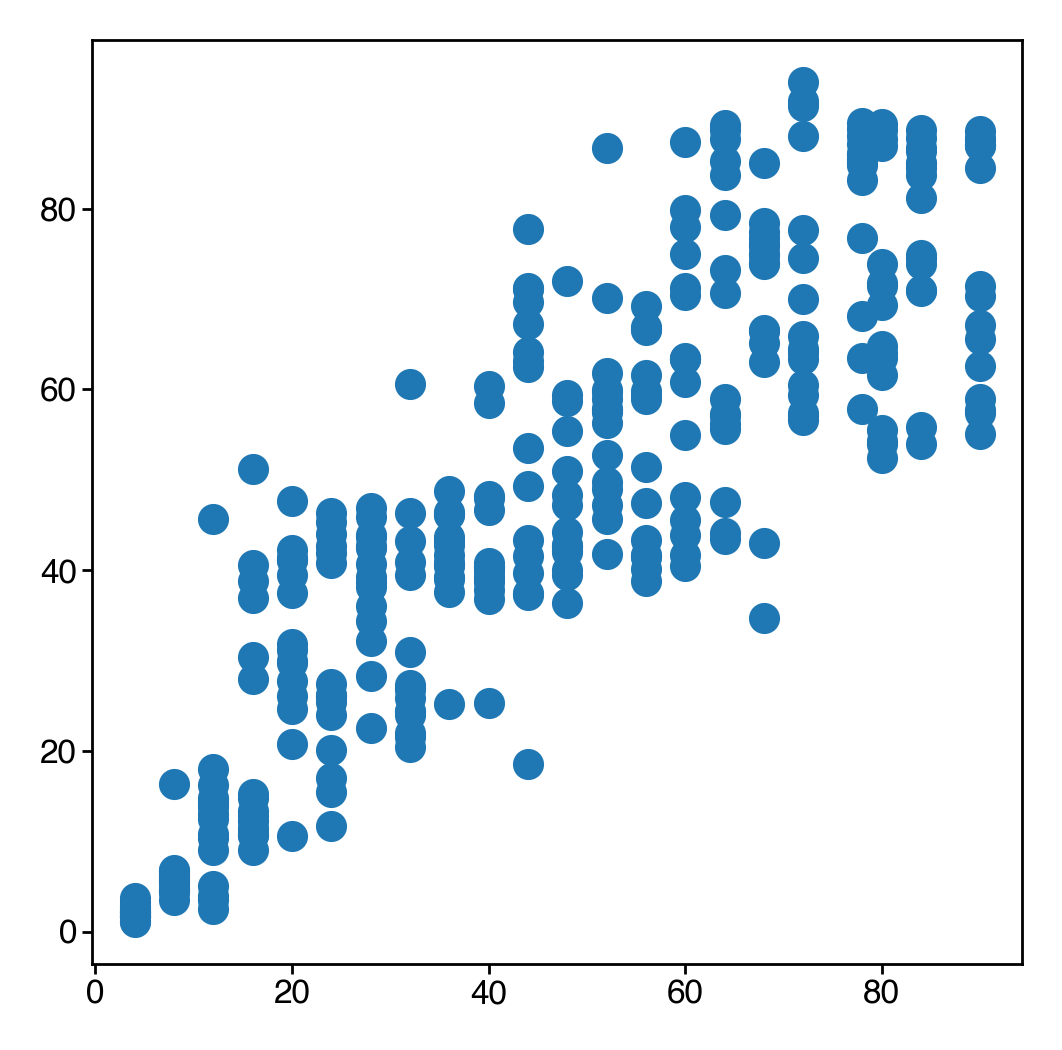

In [120]:
plt.scatter(ca, ba)

In [121]:
# find a specific parameter set
param_set = dict(
    age_sd=9,
    n_splines=4,
    bio_params_sd=3,
)
for f in tqdm(files):
    tmp = joblib.load(f)
    matches = []
    for k, v in tmp['grid_params'].items():
        matches.append(param_set[k] == v)
    if all(matches):
        break

  0%|          | 0/462 [00:00<?, ?it/s]

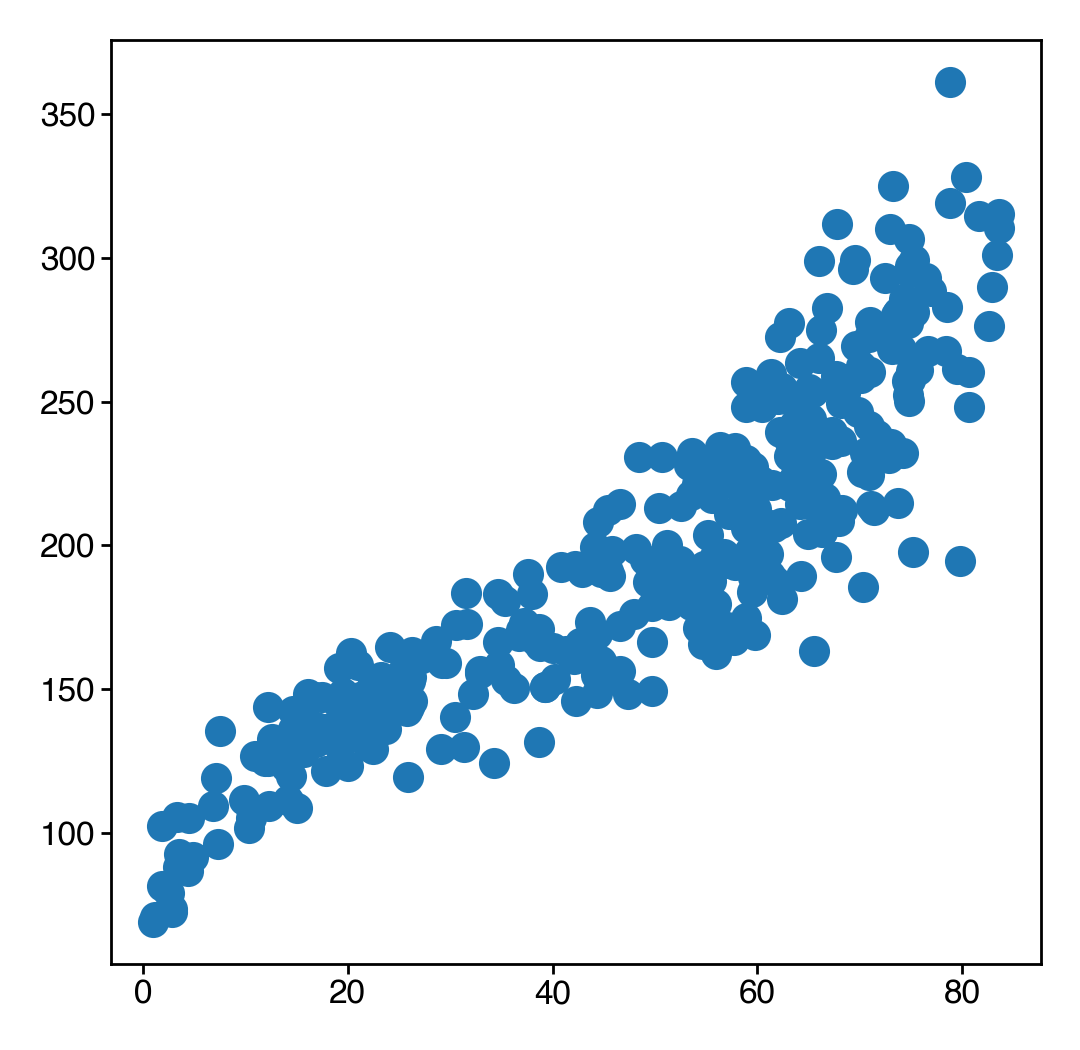

In [122]:
ba = tmp[0]['bio_ages']
ca = tmp[0]['true_ages']
c = tmp[0]['predicted_counts'][:, 0]
plt.scatter(ba, c)

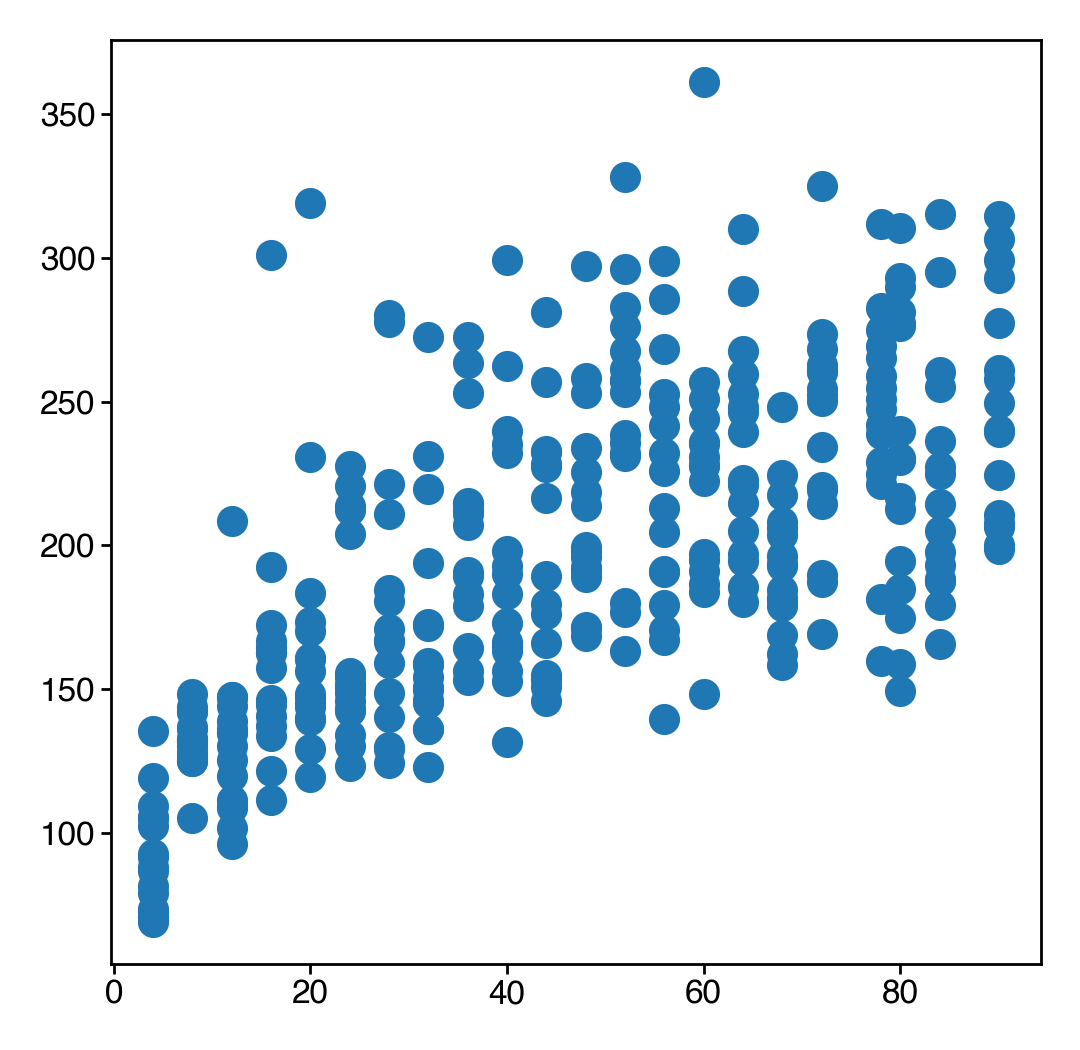

In [123]:
plt.scatter(ca, c)

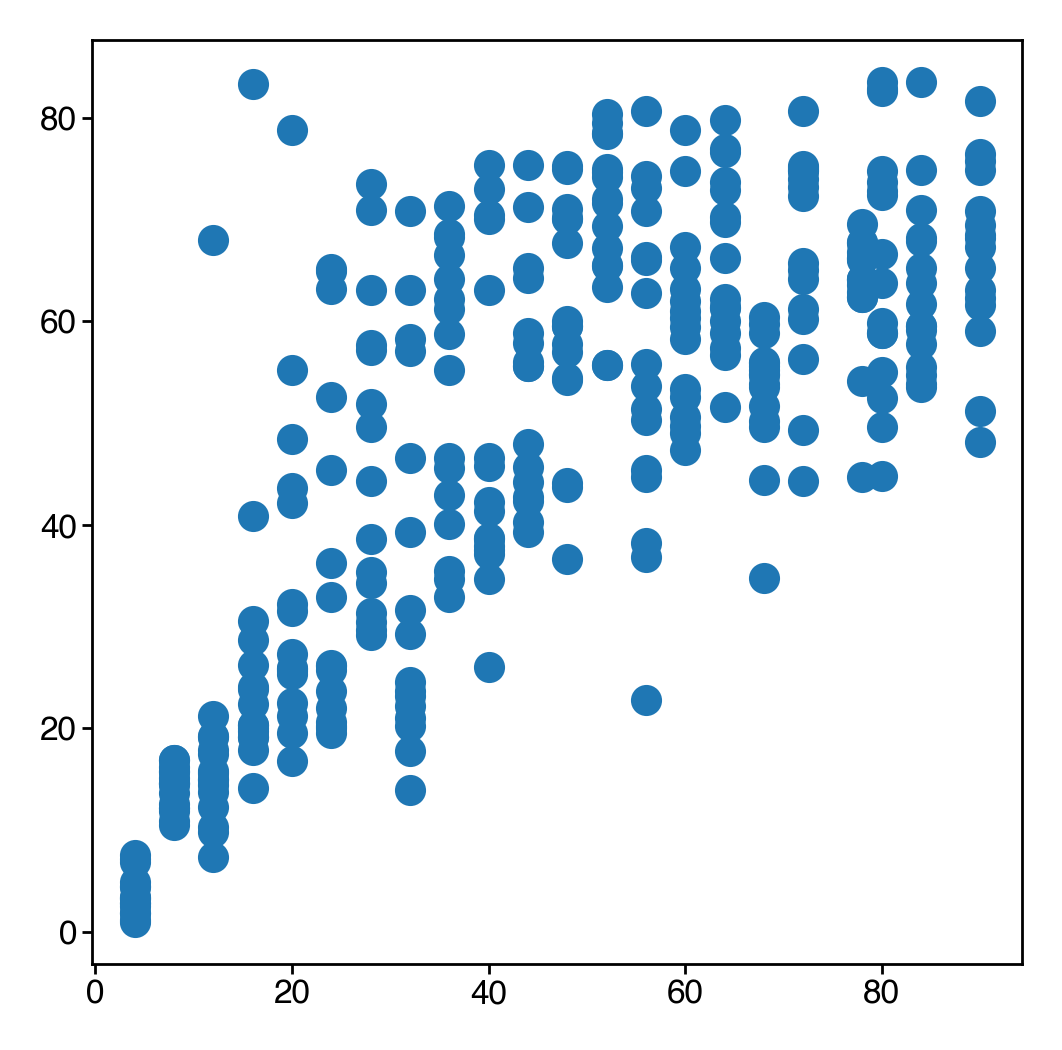

In [124]:
plt.scatter(ca, ba)

In [125]:
list(tmp[0])

['params',
 'heldout_ll',
 'loss',
 'bio_ages',
 'true_ages',
 'init_components',
 'concentrations',
 'concentration_components',
 'predicted_counts',
 'counts',
 'r2_total',
 'r2_each',
 'heldout_r2_total_v2',
 'heldout_r2_total_v3']

In [126]:
list(tmp[0]['params'])

['bio_basis_weights', 'size_slope']

In [127]:
tmp[0]['params']['bio_basis_weights'].shape

(56, 4)

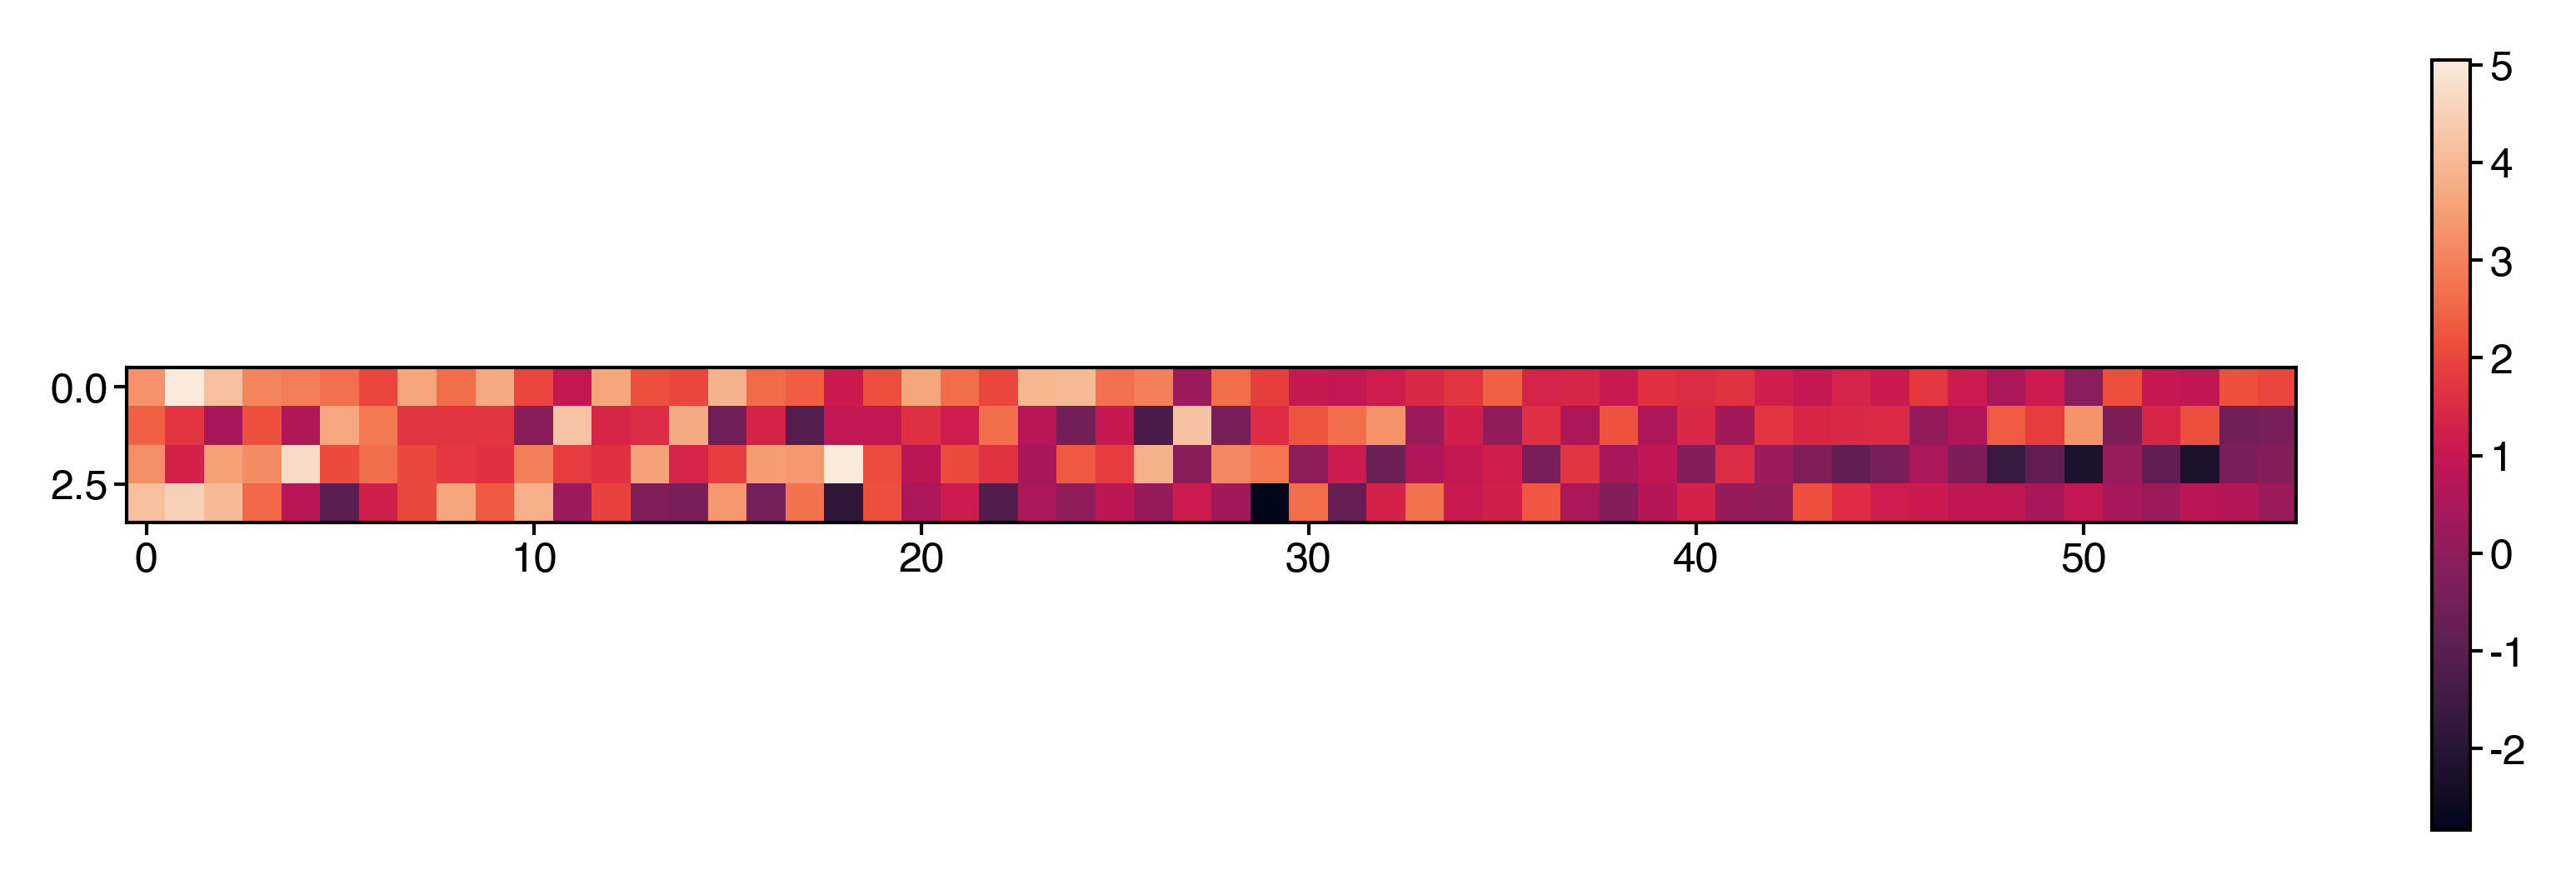

In [138]:
figure(7, 2)
plt.imshow(tmp[0]['params']['bio_basis_weights'].T)
plt.colorbar()

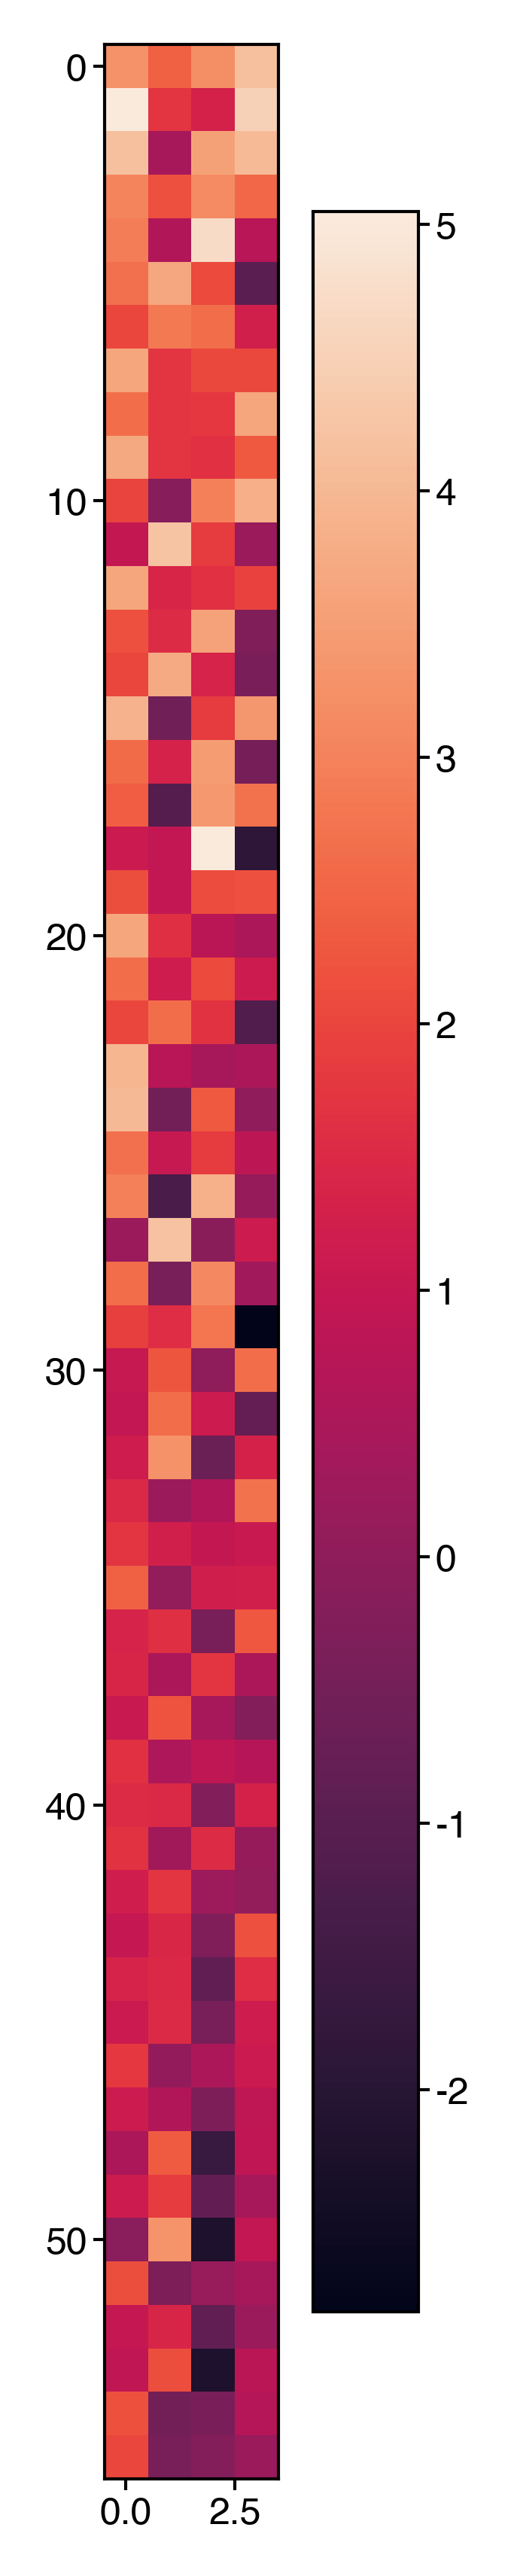

In [139]:
figure(2, 7)
plt.imshow(tmp[0]['params']['bio_basis_weights'])
plt.colorbar()

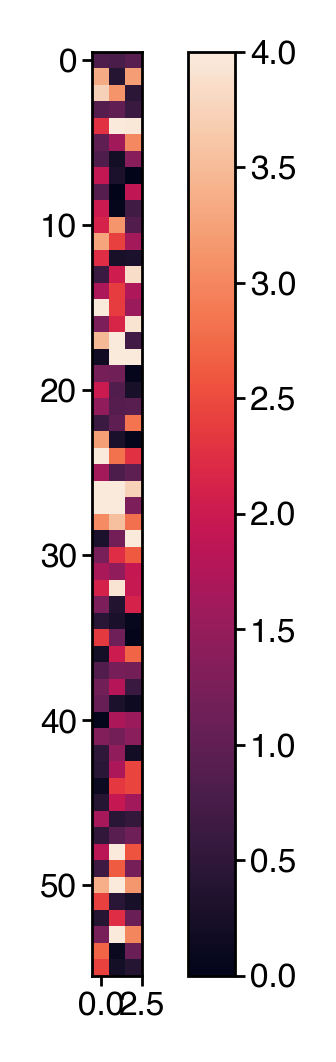

In [148]:
plt.imshow(np.abs(np.diff(tmp[0]['params']['bio_basis_weights'], axis=1)), vmin=0, vmax=4)
plt.colorbar()

In [153]:
tmp[0]['params']['bio_basis_weights'].shape

(56, 9)

### 9 spline model

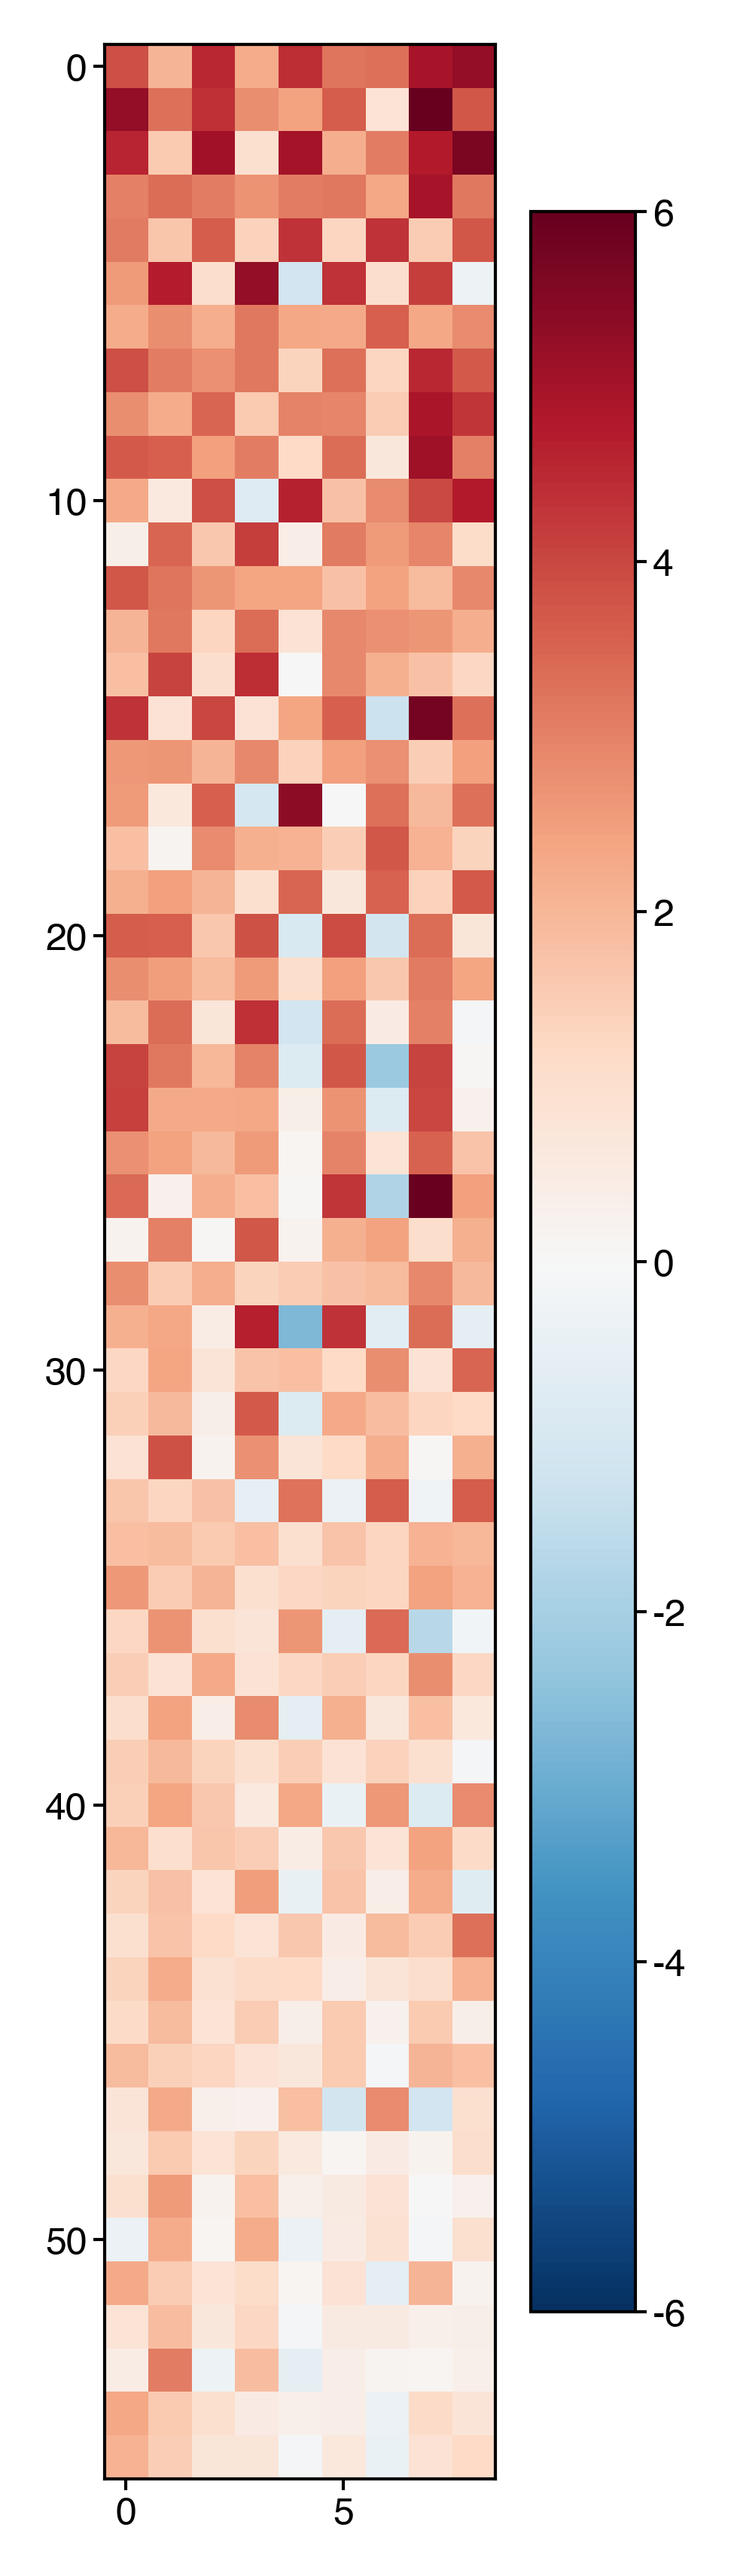

In [152]:
figure(2, 7)
plt.imshow(tmp[0]['params']['bio_basis_weights'], vmin=-6, vmax=6, cmap='RdBu_r')
plt.colorbar()

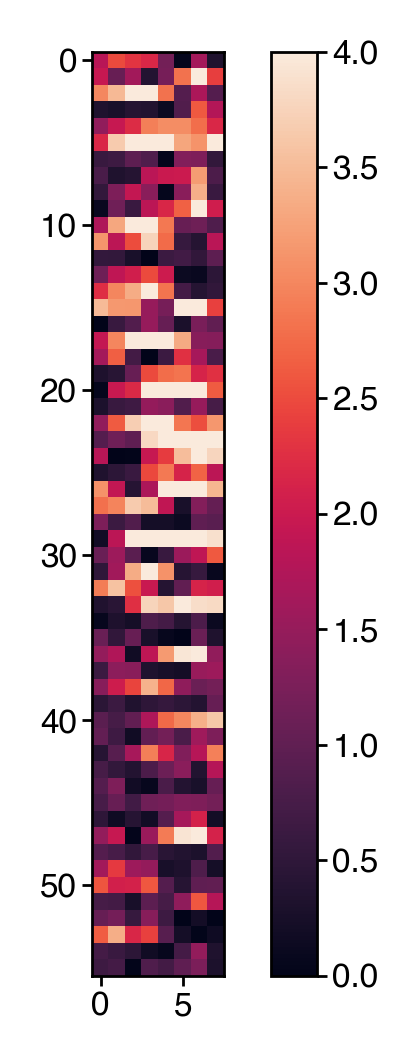

In [151]:
plt.imshow(np.abs(np.diff(tmp[0]['params']['bio_basis_weights'], axis=1)), vmin=0, vmax=4)
plt.colorbar()

In [164]:
# simulate a random walk

simulations = np.random.randn(1000, 1000)
walks = np.cumsum(simulations, axis=1)

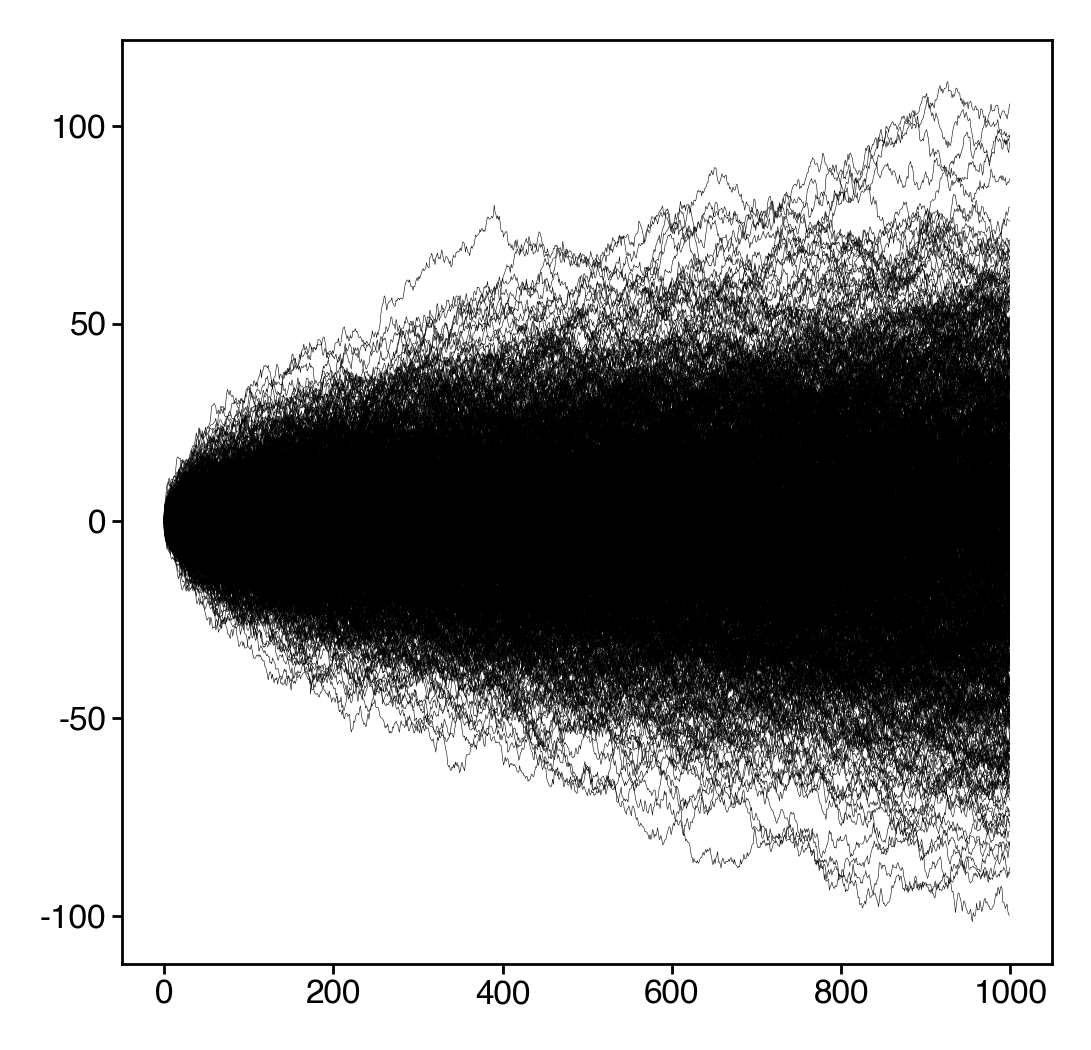

In [165]:
plt.plot(walks.T, c='k', lw=0.1);

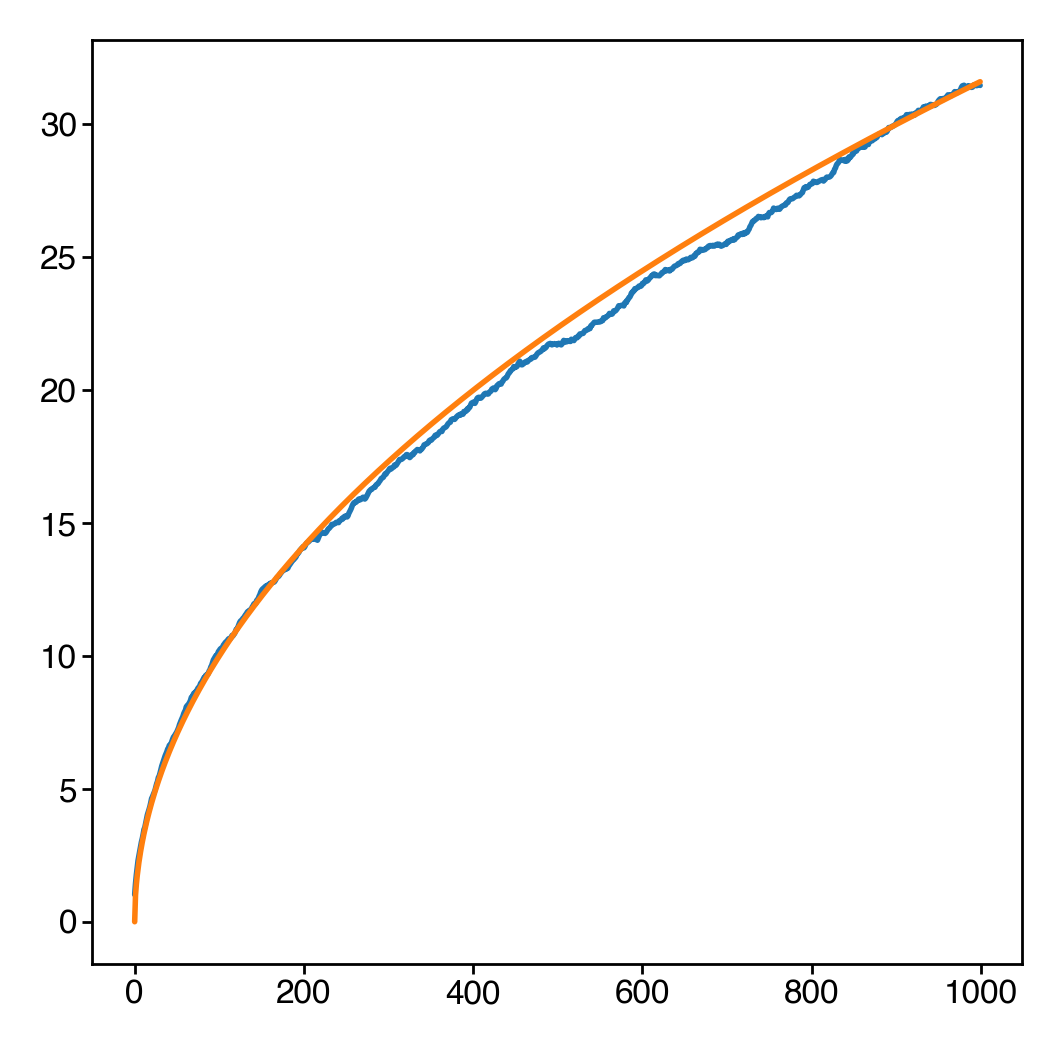

In [166]:
plt.plot(np.std(walks, axis=0))
plt.plot(np.sqrt(np.arange(1000)))